# Flatiron Health mBC: Data Wrangling Training Set

**OBJECTIVE: Identify a training cohort and create a dataframe of relevant variables which can be used to build machine learning survival models.**

**BACKGROUND: There are three sections to this notebook. First, the final cohort will be split 80-20 into a training and test set. The split will ensure the distribution of diagnosis years is the same in the training and test set given increased missingness of in earlier diagnosis years and changes in treatment practices with time.**

**The second section of this notebook involves preparing the data so that each row corresponds to a unique patient from the training set and each column is a relevant variable for mortality prognositication. There are 13 CSV files from Flatiron that will be used. The eligibility window for collecting variables is typically -90 days and +30 days from index date, which is time of metastatic diagnosis. Plus 30 was selected as the upper bound of the eligibility window given that median time to start of first line treatment is about 30 days from metastatic diagnosis.**

**The last section involves merging these datatables into a master which will be used for building machine learning survival models.** 

**Details on handling missing data is discuessed in the machine learning building notebook.** 

**OUTLINE:**
1. **Creating training and test cohort**
2. **File cleaning for patients in training set**
3. **Merge files to create master training dataframe**

## Part 1: Creating training and test cohort 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

### Splitting into training and test set

**Patients will be split into a training and test set (80/20) stratified by advanced diagnosis year.**

In [3]:
enhanced_met = pd.read_csv('Enhanced_MetastaticBreast.csv')

In [4]:
row_ID(enhanced_met)

(31677, 31677)

In [5]:
enhanced_met.loc[:, 'MetDiagnosisDate'] = pd.to_datetime(enhanced_met['MetDiagnosisDate'])

In [6]:
enhanced_met = enhanced_met.rename(columns = {'MetDiagnosisDate': 'met_date'})

In [7]:
enhanced_met['met_date'].dt.year.value_counts()/len(enhanced_met)

2018    0.098778
2017    0.096853
2015    0.095716
2016    0.095653
2019    0.095053
2014    0.091518
2020    0.086624
2013    0.083026
2021    0.079300
2012    0.074755
2011    0.062601
2022    0.040124
Name: met_date, dtype: float64

In [8]:
enhanced_met['met_date'].dt.year.describe()

count    31677.000000
mean      2016.423462
std          3.154600
min       2011.000000
25%       2014.000000
50%       2016.000000
75%       2019.000000
max       2022.000000
Name: met_date, dtype: float64

<AxesSubplot:xlabel='met_date'>

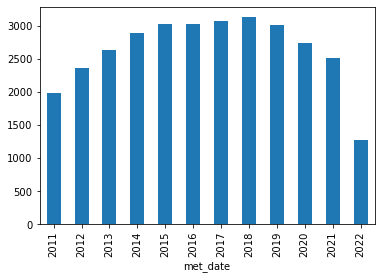

In [9]:
enhanced_met.groupby([enhanced_met['met_date'].dt.year])['PatientID'].count().plot(kind = 'bar')

<AxesSubplot:xlabel='met_date'>

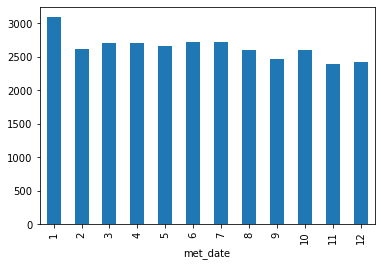

In [10]:
enhanced_met.groupby([enhanced_met['met_date'].dt.month])['PatientID'].count().plot(kind = 'bar')

In [11]:
enhanced_met['met_year_cat'] = pd.cut(enhanced_met['met_date'].dt.year,
                                      bins = [2010, 2012, 2014, 2016, 2018, 2020, 2022],
                                      labels = ['11-12', '13-14', '15-16', '17-18', '19-20', '21-22'])

In [12]:
enhanced_met['met_year_cat'].value_counts(normalize = True, dropna = False)

17-18    0.195631
15-16    0.191369
19-20    0.181678
13-14    0.174543
11-12    0.137355
21-22    0.119424
Name: met_year_cat, dtype: float64

In [13]:
enhanced_met['met_year_cat'].value_counts().sum()

31677

<AxesSubplot:xlabel='met_year_cat'>

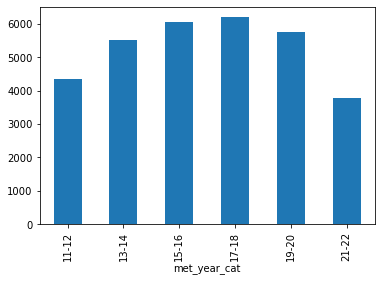

In [14]:
enhanced_met.groupby([enhanced_met['met_year_cat']])['PatientID'].count().plot(kind = 'bar')

In [15]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in sss.split(enhanced_met, enhanced_met['met_year_cat']):
    train_set = enhanced_met.iloc[train_index]
    test_set = enhanced_met.iloc[test_index]

In [16]:
train_set['met_year_cat'].value_counts()/len(train_set)

17-18    0.195612
15-16    0.191389
19-20    0.181682
13-14    0.174539
11-12    0.137366
21-22    0.119411
Name: met_year_cat, dtype: float64

In [17]:
test_set['met_year_cat'].value_counts()/len(test_set)

17-18    0.195707
15-16    0.191288
19-20    0.181660
13-14    0.174558
11-12    0.137311
21-22    0.119476
Name: met_year_cat, dtype: float64

In [18]:
row_ID(train_set)

(25341, 25341)

In [19]:
row_ID(test_set)

(6336, 6336)

In [20]:
# Array of PatientIDs in training set.
train_IDs = train_set['PatientID'].to_numpy()

In [21]:
pd.DataFrame(train_IDs, columns = ['PatientID']).to_csv('train_IDs.csv', index = False, header = True)

In [22]:
# Array of PatientIDs in test set.
test_IDs = test_set['PatientID'].to_numpy()

In [23]:
pd.DataFrame(test_IDs, columns = ['PatientID']).to_csv('test_IDs.csv', index = False, header = True)

In [24]:
%whos DataFrame

Variable       Type         Data/Info
-------------------------------------
enhanced_met   DataFrame               PatientID Diag<...>n[31677 rows x 5 columns]
test_set       DataFrame               PatientID Diag<...>\n[6336 rows x 5 columns]
train_set      DataFrame               PatientID Diag<...>n[25341 rows x 5 columns]


In [25]:
# Keep enhanced_met and visit_tele.
del test_set
del train_set

## Part 2: Data wrangling

**Relevant CSV files will be imported and cleaned. A file is considered cleaned when each row corresponds to a unique patient from the training set and each column is a relevant variable for mortality prognositication. The eligibility window for collecting variables is typically defined as -90 days and +30 days from index date. The index date is time of metastatic diagnosis. Plus 30 was selected as the upper bound of the eligibility window given that median time to start of first line treatment is about 30 days from metastatic diagnosis.** 

**The following CSV files from Flatiron will be cleaned:**
1. **Demographics and Practice**
2. **Enhanced_MetastaticBreast**
3. **Enhanced_Mortality_V2**
4. **MedicationAdministration**
5. **Enhanced_MetBreastBiomarkers**
6. **Insurance**
7. **ECOG**
8. **Vitals**
9. **Labs**
10. **Diagnosis and Enhanced_MetBreastSitesOfMet**
11. **SocialDeeterminantsOfHealth**

### 1. Demographics

In [26]:
demographics = pd.read_csv('Demographics.csv')

In [27]:
demographics = demographics[demographics['PatientID'].isin(train_IDs)]

In [28]:
demographics.sample(5)

,PatientID,BirthYear,Gender,Race,Ethnicity,State
9614,F1BF0F12C20CB,1973,F,White,Not Hispanic or Latino,NaN
6227,FE66EB8FBC03E,1959,F,Black or African American,Not Hispanic or Latino,LA
9301,F9683F47AF013,1944,F,White,Not Hispanic or Latino,TX
188,F498C4BE4122C,1953,F,White,Not Hispanic or Latino,NaN
2305,F17325A5AA275,1948,F,NaN,Not Hispanic or Latino,VA


In [29]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25341 entries, 1 to 31676
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   PatientID  25341 non-null  object
 1   BirthYear  25341 non-null  int64 
 2   Gender     25339 non-null  object
 3   Race       22818 non-null  object
 4   Ethnicity  21090 non-null  object
 5   State      20133 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.4+ MB


In [30]:
row_ID(demographics)

(25341, 25341)

#### Race and Ethnicity

In [31]:
demographics['Race'].value_counts(normalize = True, dropna = False)*100

White                        64.291070
Black or African American    11.795115
Other Race                   11.684622
NaN                           9.956197
Asian                         2.055957
Hispanic or Latino            0.217040
Name: Race, dtype: float64

In [32]:
demographics['Ethnicity'].value_counts(normalize = True, dropna = False)*100

Not Hispanic or Latino    75.364035
NaN                       16.775186
Hispanic or Latino         7.860779
Name: Ethnicity, dtype: float64

In [33]:
demographics.query('Ethnicity == "Hispanic or Latino"').sample(3)

,PatientID,BirthYear,Gender,Race,Ethnicity,State
7031,F6C5A0A95D68F,1956,F,White,Hispanic or Latino,PR
21810,F61186632AACB,1959,F,NaN,Hispanic or Latino,TX
19653,F8B9CF856C7B7,1957,F,White,Hispanic or Latino,PR


In [34]:
(
    demographics
    .query('Race == "Hispanic or Latino"')
    .query('Ethnicity != "Hispanic or Latino"')
    .head(3)
)    

,PatientID,BirthYear,Gender,Race,Ethnicity,State
210,F34BC107179EA,1979,F,Hispanic or Latino,Not Hispanic or Latino,AZ
5294,F244516920178,1950,F,Hispanic or Latino,NaN,CA
6654,FD5B0FD5469BF,1983,F,Hispanic or Latino,Not Hispanic or Latino,MA


**There are unexpected values where “Hispanic or Latino” appears as a race rather than ethnicity. Ethnicity will be recoded to align with the FDA standards for collecting race and ethnicity variables for clinical trials. Patients with a race value of “Hispanic or Latino” will have their race recoded as "Unknown" and ethnicity as “Hispanic or Latino.” Of note, ethnicity and race information is likely to be poorly captured since EHR platforms typically do not require documentation of race or ethnicity.**  

In [35]:
# If race value is 'Hispanic or Latino', code as unknown, otherwise value unchanged.
demographics['race'] = (
    np.where(demographics['Race'] == 'Hispanic or Latino', 'unknown', demographics['Race'])
)

In [36]:
demographics['race'] = demographics['race'].fillna('unknown')

In [37]:
demographics['race'].value_counts(normalize = True, dropna = False)*100

White                        64.291070
Black or African American    11.795115
Other Race                   11.684622
unknown                      10.173237
Asian                         2.055957
Name: race, dtype: float64

In [38]:
# If race value is equal to 'Hispanic or Latino', code ethnicity as 'Hispanic or Latino', otherwise unchanged. 
demographics['ethnicity'] = (
    np.where(demographics['Race'] == 'Hispanic or Latino', 'hispanic_latino', demographics['Ethnicity'])
)

In [39]:
demographics['ethnicity'] = demographics['ethnicity'].fillna('unknown')

In [40]:
demographics['ethnicity'] = demographics['ethnicity'].replace({'Hispanic or Latino': 'hispanic_latino'})

In [41]:
demographics['ethnicity'].value_counts(normalize = True, dropna = False)*100

Not Hispanic or Latino    75.336411
unknown                   16.763348
hispanic_latino            7.900241
Name: ethnicity, dtype: float64

In [42]:
(
    demographics
    .groupby(['ethnicity', 'race'])['PatientID'].count()
    .divide(len(demographics))
    .sort_values(ascending = False)
)

ethnicity               race                     
Not Hispanic or Latino  White                        0.554872
                        Black or African American    0.103784
unknown                 unknown                      0.068821
                        White                        0.055286
Not Hispanic or Latino  Other Race                   0.054497
hispanic_latino         Other Race                   0.032951
                        White                        0.032753
unknown                 Other Race                   0.029399
Not Hispanic or Latino  unknown                      0.022848
                        Asian                        0.017363
unknown                 Black or African American    0.011089
hispanic_latino         unknown                      0.010063
                        Black or African American    0.003078
unknown                 Asian                        0.003039
hispanic_latino         Asian                        0.000158
Name: PatientID, dty

In [43]:
demographics = demographics.drop(columns = ['Race', 'Ethnicity'])

#### BirthYear

In [44]:
demographics['BirthYear'].describe()

count    25341.000000
mean      1953.848033
std         12.780374
min       1937.000000
25%       1943.000000
50%       1953.000000
75%       1962.000000
max       2002.000000
Name: BirthYear, dtype: float64

array([[<AxesSubplot:title={'center':'BirthYear'}>]], dtype=object)

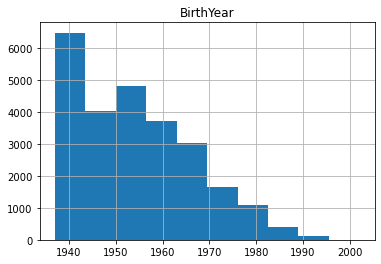

In [45]:
demographics.hist(column = 'BirthYear')

In [46]:
# Top 10 birth years.
demographics['BirthYear'].value_counts(normalize = True, dropna = False).head(10)

1937    0.140484
1947    0.030070
1948    0.028294
1954    0.028136
1956    0.027544
1949    0.027505
1951    0.027465
1953    0.027347
1950    0.027268
1955    0.026400
Name: BirthYear, dtype: float64

**Dispraportionate number of patients aged 85. Flatiron aggregates patients 85 and older into a single category of 85 years of age to limit potential for re-identification of older patients.**

In [47]:
demographics = pd.merge(demographics, enhanced_met[['PatientID', 'met_date']], on = 'PatientID')

In [48]:
demographics.loc[:, 'age'] = demographics['met_date'].dt.year - demographics['BirthYear']

In [49]:
demographics = demographics.drop(columns = ['BirthYear', 'met_date'])

#### PracticeType

In [50]:
practice = pd.read_csv('Practice.csv')

In [51]:
practice.sample(5)

,PatientID,PracticeID,PracticeType,PrimaryPhysicianID
2182,F6E8B594BCD7B,SCC8EE4FB66C3,ACADEMIC,NaN
27489,F55C5A26A8D2C,S19210F786354,COMMUNITY,T33115BB60E35
29513,F8B234596AC7A,S0225D992F9DE,COMMUNITY,TA742CB58D4E7
18910,F00D6C354A73C,SA61EDD66B815,COMMUNITY,T2BB9B8AC2E07
13751,F989BBECFABD0,S0015D5ED587A,ACADEMIC,NaN


In [52]:
practice = practice[practice['PatientID'].isin(train_IDs)]

In [53]:
row_ID(practice)

(25927, 25341)

In [54]:
practice.PracticeType.value_counts()

COMMUNITY    21380
ACADEMIC      4547
Name: PracticeType, dtype: int64

In [55]:
practice[practice.duplicated(subset = ['PatientID'], keep = False)].sort_values(by = ['PatientID']).head(10)

,PatientID,PracticeID,PracticeType,PrimaryPhysicianID
27063,F02614E91ABDD,S43F1EC350316,COMMUNITY,T789904617DFC
5652,F02614E91ABDD,S87C279DB0C8A,COMMUNITY,T0CB40AEC3836
24533,F026C43DC1FA0,S0015D5ED587A,ACADEMIC,NaN
23752,F026C43DC1FA0,SBA2549C29E0D,COMMUNITY,T6EEE2E100B03
22027,F02B3A7D3F764,SB7952CE9CAC0,COMMUNITY,TE0BDAD4233EA
23040,F02B3A7D3F764,S6DCB6AF0A70F,COMMUNITY,T35FCD3619FF4
228,F0561439F5D38,S0015D5ED587A,ACADEMIC,NaN
16482,F0561439F5D38,SBBCA1E6D01BA,COMMUNITY,T4D53ADADDD8E
18722,F056319CD0D67,SB95BF4F71E93,COMMUNITY,TC1431561B51F
19254,F056319CD0D67,S266A431D9037,COMMUNITY,NaN


In [56]:
practice_unique_count = (
    practice.groupby('PatientID')['PracticeType'].agg('nunique')
    .to_frame()
    .reset_index()
    .rename(columns = {'PracticeType': 'n_type'})
)

In [57]:
practice_n = pd.merge(practice, practice_unique_count, on = 'PatientID')

In [58]:
practice_n['p_type'] = (
    np.where(practice_n['n_type'] == 1, practice_n['PracticeType'], 'BOTH')
)

In [59]:
practice_n = (
    practice_n.drop_duplicates(subset = ['PatientID'], keep = 'first')
    .filter(items = ['PatientID', 'p_type'])
)

In [60]:
demographics = pd.merge(demographics, practice_n, on = 'PatientID')

In [61]:
demographics['p_type'].value_counts(normalize=True, dropna=False)*100

COMMUNITY    82.080423
ACADEMIC     16.684424
BOTH          1.235153
Name: p_type, dtype: float64

#### Gender

In [62]:
demographics['Gender'].value_counts(normalize = True, dropna = False)*100

F      98.776686
M       1.215422
NaN     0.007892
Name: Gender, dtype: float64

In [63]:
# Impute F as unknown given most common gender. 
demographics['Gender'] = demographics['Gender'].fillna('F')

In [64]:
demographics = demographics.rename(columns = {'Gender': 'gender'})

#### State

In [65]:
demographics['State'].isna().sum()

5208

In [66]:
demographics['State'].value_counts(normalize = True, dropna = False).head(20)

NaN    0.205517
TN     0.067598
CA     0.067006
FL     0.056983
AZ     0.049130
AL     0.044947
NY     0.044789
MI     0.042382
PA     0.041829
NJ     0.037212
TX     0.035950
VA     0.031372
IL     0.024348
PR     0.023914
OH     0.023401
GA     0.021309
OK     0.020402
MS     0.019612
WA     0.019218
SC     0.016969
Name: State, dtype: float64

**For de-identification reasons, State is nulled out for a few low-population states (e.g., AK, MT, ND, SD, VT, and WY). New variable will be created to group states into Census-Bureau regions for simplicity.** 

In [67]:
# Group states into Census-Bureau regions  
state_dict = { 
    'ME': 'northeast', 
    'NH': 'northeast',
    'VT': 'northeast', 
    'MA': 'northeast',
    'CT': 'northeast',
    'RI': 'northeast',  
    'NY': 'northeast', 
    'NJ': 'northeast', 
    'PA': 'northeast', 
    'IL': 'midwest', 
    'IN': 'midwest', 
    'MI': 'midwest', 
    'OH': 'midwest', 
    'WI': 'midwest',
    'IA': 'midwest',
    'KS': 'midwest',
    'MN': 'midwest',
    'MO': 'midwest', 
    'NE': 'midwest',
    'ND': 'midwest',
    'SD': 'midwest',
    'DE': 'south',
    'FL': 'south',
    'GA': 'south',
    'MD': 'south',
    'NC': 'south', 
    'SC': 'south',
    'VA': 'south',
    'DC': 'south',
    'WV': 'south',
    'AL': 'south',
    'KY': 'south',
    'MS': 'south',
    'TN': 'south',
    'AR': 'south',
    'LA': 'south',
    'OK': 'south',
    'TX': 'south',
    'AZ': 'west',
    'CO': 'west',
    'ID': 'west',
    'MT': 'west',
    'NV': 'west',
    'NM': 'west',
    'UT': 'west',
    'WY': 'west',
    'AK': 'west',
    'CA': 'west',
    'HI': 'west',
    'OR': 'west',
    'WA': 'west',
    'PR': 'unknown'
}

demographics['region'] = demographics['State'].map(state_dict)

In [68]:
demographics['region'] = demographics['region'].fillna('unknown')

In [69]:
demographics['region'].value_counts(normalize = True, dropna = False)

south        0.356655
unknown      0.229431
west         0.153980
northeast    0.138984
midwest      0.120950
Name: region, dtype: float64

In [70]:
demographics['region'].value_counts(dropna = False).sum()

25341

<AxesSubplot:xlabel='region'>

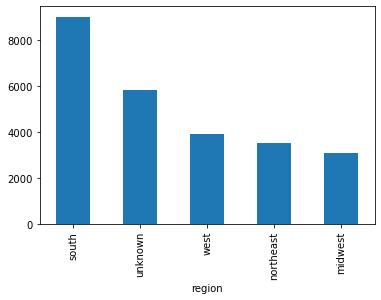

In [71]:
demographics.groupby('region')['PatientID'].count().sort_values(ascending = False).plot(kind = 'bar')

<AxesSubplot:xlabel='p_type,region'>

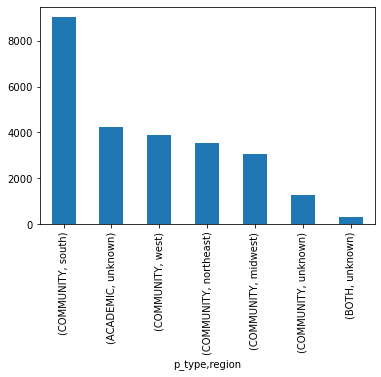

In [72]:
demographics.groupby(['p_type', 'region'])['PatientID'].count().sort_values(ascending = False).plot(kind = 'bar')

**Most patients come from community programs in the south. Interestingly, all academic patients are from an unknown region, likely for de-identification purposes.**

In [73]:
demographics = demographics.drop(columns = ['State'])

In [74]:
# Final training demographics table.
demographics.sample(5)

,PatientID,gender,race,ethnicity,age,p_type,region
9937,F17E6B2D9EFE9,F,White,Not Hispanic or Latino,67,COMMUNITY,northeast
18891,F1ADF04DC159D,F,White,Not Hispanic or Latino,79,COMMUNITY,west
24198,FCE67FD5E650B,F,White,Not Hispanic or Latino,58,COMMUNITY,midwest
12166,FD2B586FEAACA,F,Other Race,Not Hispanic or Latino,51,COMMUNITY,west
13183,F498F9B51DF30,F,White,Not Hispanic or Latino,66,COMMUNITY,west


In [75]:
%whos DataFrame

Variable                Type         Data/Info
----------------------------------------------
demographics            DataFrame               PatientID gend<...>n[25341 rows x 7 columns]
enhanced_met            DataFrame               PatientID Diag<...>n[31677 rows x 5 columns]
practice                DataFrame               PatientID     <...>n[25927 rows x 4 columns]
practice_n              DataFrame               PatientID     <...>n[25341 rows x 2 columns]
practice_unique_count   DataFrame               PatientID  n_t<...>n[25341 rows x 2 columns]


In [76]:
# Keep demographics and enhanced_met
del practice
del practice_n
del practice_unique_count

### 2. Enhanced_MetastaticBreast

In [77]:
enhanced_met.sample(5)

,PatientID,DiagnosisDate,met_date,GroupStage,met_year_cat
2204,F896EEDC48514,2002-01-01,2014-08-07,Not documented,13-14
4326,FFE328D2EE107,1999-07-01,2013-07-10,II,13-14
270,F85F804E76947,2011-09-21,2020-10-09,II,19-20
25830,F6C93D49B176F,2011-11-18,2016-12-14,III,15-16
17618,F8AD36C108A21,1981-01-01,2014-11-11,Not documented,13-14


In [78]:
enhanced_met.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31677 entries, 0 to 31676
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   PatientID      31677 non-null  object        
 1   DiagnosisDate  31553 non-null  object        
 2   met_date       31677 non-null  datetime64[ns]
 3   GroupStage     31677 non-null  object        
 4   met_year_cat   31677 non-null  category      
dtypes: category(1), datetime64[ns](1), object(3)
memory usage: 1021.2+ KB


In [79]:
enhanced_met = enhanced_met[enhanced_met['PatientID'].isin(train_IDs)]

In [80]:
row_ID(enhanced_met)

(25341, 25341)

#### GroupStage 

In [81]:
enhanced_met.GroupStage.value_counts(dropna = False, normalize = True)

IV                0.308709
II                0.256620
III               0.203110
Not documented    0.118109
I                 0.113413
0                 0.000039
Name: GroupStage, dtype: float64

In [82]:
# Dictionary for regrouping stages
stage_dict = { 
    '0': '0',
    'I': 'I',
    'II': 'II',
    'III': 'III',
    'IV': 'IV',
    'Not documented': 'unknown'
}

enhanced_met['stage'] = enhanced_met['GroupStage'].map(stage_dict)

In [83]:
enhanced_met['stage'].value_counts(normalize = True, dropna = False)

IV         0.308709
II         0.256620
III        0.203110
unknown    0.118109
I          0.113413
0          0.000039
Name: stage, dtype: float64

In [84]:
enhanced_met = enhanced_met.drop(columns = ['GroupStage'])

#### MetDiagnosisDate

In [85]:
enhanced_met['met_date'].min()

Timestamp('2011-01-01 00:00:00')

In [86]:
enhanced_met['met_date'].max()

Timestamp('2022-08-29 00:00:00')

In [87]:
enhanced_met['met_date'].dt.year.describe()

count    25341.000000
mean      2016.423227
std          3.153379
min       2011.000000
25%       2014.000000
50%       2016.000000
75%       2019.000000
max       2022.000000
Name: met_date, dtype: float64

In [88]:
enhanced_met.loc[:, 'met_year'] = enhanced_met['met_date'].dt.year

#### DiagnosisDate

In [89]:
enhanced_met['DiagnosisDate'].isna().sum()

92

In [90]:
enhanced_met = enhanced_met.rename(columns = {'DiagnosisDate': 'diagnosis_date'})

In [91]:
# Missing diagnosis_date will be replaced with met_date; other dates will be left untouched. 
enhanced_met['diagnosis_date'] = (
    np.where(enhanced_met['diagnosis_date'].isna(), enhanced_met['met_date'], enhanced_met['diagnosis_date'])
)

In [92]:
enhanced_met['diagnosis_date'] = pd.to_datetime(enhanced_met['diagnosis_date'])

In [93]:
enhanced_met['diagnosis_date'].min()

Timestamp('1967-01-01 00:00:00')

In [94]:
enhanced_met['diagnosis_date'].max()

Timestamp('2022-08-29 00:00:00')

In [95]:
enhanced_met['diagnosis_date'].dt.year.describe()

count    25341.000000
mean      2012.038396
std          6.652182
min       1967.000000
25%       2009.000000
50%       2013.000000
75%       2017.000000
max       2022.000000
Name: diagnosis_date, dtype: float64

<AxesSubplot:xlabel='diagnosis_date'>

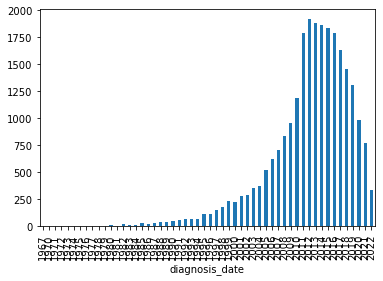

In [96]:
# Bar plot of number of new CRC diagnoses per year.
enhanced_met.groupby([enhanced_met['diagnosis_date'].dt.year])['PatientID'].count().plot(kind = 'bar')

**The range of dates for diagnosis is 1/1967 to 8/2022 with a median year of 2013.** 

In [97]:
# Percent of patients diagnosed prior to metastatic diagnosis. 
(
    enhanced_met
    .query('diagnosis_date < met_date')
    .shape[0]/(len(enhanced_met))
)

0.6875813898425477

#### Time from diagnosis date to metastatic date

In [98]:
enhanced_met.loc[:, 'delta_met_diagnosis'] = (enhanced_met['met_date'] - enhanced_met['diagnosis_date']).dt.days

In [99]:
# Brief summary statistics on time between diagnosis date and metastatic diagnosis.
(
    enhanced_met
    .query('delta_met_diagnosis > 0')
    .describe()
)

,met_year,delta_met_diagnosis
count,17424.000000,17424.000000
mean,2016.430556,2347.514635
std,3.134623,2262.552179
min,2011.000000,2.000000
25%,2014.000000,743.000000
50%,2016.000000,1572.000000
75%,2019.000000,3240.000000
max,2022.000000,18565.000000


In [100]:
# Final enhanced_met dataframe
enhanced_met.sample(5)

,PatientID,diagnosis_date,met_date,met_year_cat,stage,met_year,delta_met_diagnosis
8537,FB46B6DF61B21,2012-11-21,2012-11-21,11-12,IV,2012,0
4551,FB0331B290157,2009-10-01,2014-09-16,13-14,unknown,2014,1811
3013,FC0D88F4A9FBF,2015-05-01,2020-09-17,19-20,I,2020,1966
14248,F4FA9630C17C1,2017-10-20,2017-10-20,17-18,IV,2017,0
29627,F7945A2B5A122,2002-10-15,2020-11-30,19-20,III,2020,6621


In [101]:
%whos DataFrame

Variable       Type         Data/Info
-------------------------------------
demographics   DataFrame               PatientID gend<...>n[25341 rows x 7 columns]
enhanced_met   DataFrame               PatientID diag<...>n[25341 rows x 7 columns]


### 3. Enhanced_Mortality_V2

In [102]:
mortality = pd.read_csv('Enhanced_Mortality_V2.csv')

In [103]:
mortality = mortality[mortality['PatientID'].isin(train_IDs)]

In [104]:
mortality.sample(5)

,PatientID,DateOfDeath
7384,FCACF697C1E6B,2020-06
9434,F836D4BA46A8C,2019-12
5063,F333D69B787B2,2012-12
12598,F2753D7C27267,2022-04
13454,F48A5C9F1DF2D,2013-04


In [105]:
mortality.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14679 entries, 0 to 18368
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PatientID    14679 non-null  object
 1   DateOfDeath  14679 non-null  object
dtypes: object(2)
memory usage: 344.0+ KB


In [106]:
row_ID(mortality)

(14679, 14679)

In [107]:
mortality = mortality.rename(columns = {'DateOfDeath': 'death_date'})

In [108]:
# Patients with year granularity.
mortality[mortality['death_date'].str.len() == 4]

,PatientID,death_date
141,F3BF563A62D48,2019
3365,FC19D180301A7,2020
3463,FC611158E494E,2012
5434,F526752C62060,2021
5797,FC06920270A44,2022
6003,F57B5EED267D4,2014
6756,F325D6C944F52,2014
6876,F816712BD769E,2020
6920,F48F91B72EB0A,2022
8252,FD96BA30AC4B3,2021


**The date of death is generalized to the month for de-identification purposes, however, a small number of patients have just the year for date of death. For analyses requiring a day of death, Flatiron Health recommends imputing the 15th of the month since this approach best approximates the results generated from using the exact date of death. For those with a date of death with year granularity, Flatiron recommends imputing the middle of the year and conducting a sensitivty analysis to evaluate assumption.**

In [109]:
# For patients with year granularity, impute middle of the year (ie., July 1)
mortality['death_date'] = (
    np.where(mortality['death_date'].str.len() == 4, mortality['death_date'] + '-07-01', mortality['death_date'])
)

In [110]:
# For patients with month granularity, impute 15th of the month.
mortality['death_date'] = (
    np.where(mortality['death_date'].str.len() == 7, mortality['death_date'] + '-15', mortality['death_date'])
)

In [111]:
mortality['death_date'] = pd.to_datetime(mortality['death_date'])

In [112]:
# Percent of patients with death date.  
len(mortality)/len(train_IDs)

0.5792589084882207

<AxesSubplot:xlabel='death_date'>

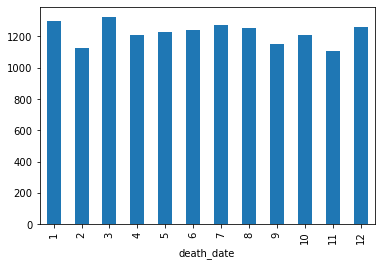

In [113]:
# Bar plot of monthly mortality for aNSCLC. 
mortality.groupby([mortality['death_date'].dt.month])['PatientID'].count().plot(kind = 'bar')

<AxesSubplot:xlabel='death_date'>

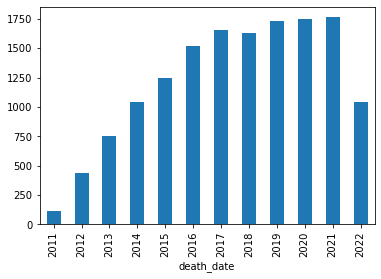

In [114]:
# Bar plot of yearly mortality for aNSCLC. 
mortality.groupby([mortality['death_date'].dt.year])['PatientID'].count().plot(kind = 'bar')

#### Censoring

**For patients for whom a date of death is not known, the censor date can be defined either as the data cutoff date or as the last confirmed activity date. The last confirmed activity date is broadly defined as the last date at which there is evidence in the EHR that a patient is alive. Evidence of a record in at least one of the items listed below qualifies as patient-level confirmed activity:**
* Visit: VisitDate
* Telemedicine: VisitDate
* Enhanced_MetBreast_Orals: StartDate or EndDate
* Enhanced_MetBreastBiomarkers: SpecimenCollectedDate
* Enhanced_MetBreastProgression: LastClinicNoteDate or ProgressionDate
* Enhanced_MetBreastSitesOfMet: DateOfMetastasis

In [115]:
visit = pd.read_csv('Visit.csv')
telemedicine = pd.read_csv('Telemedicine.csv')
orals = pd.read_csv('Enhanced_MetBreast_Orals.csv')
biomarkers = pd.read_csv('Enhanced_MetBreastBiomarkers.csv')
progression = pd.read_csv('Enhanced_MetBreastProgression.csv')
mets = pd.read_csv('Enhanced_MetBreastSitesOfMet.csv')

##### Visit and Telemedicine

In [116]:
visit.sample(5)

,PatientID,PracticeID,VisitDate,VisitType,IsVitalsVisit,IsTreatmentVisit,IsLabVisit
1505937,F3C7EA810813E,SA060E3ECE536,2015-10-28,Treatment,True,True,True
1443969,F932EB2BC41D8,SD2555DC0ACD7,2017-10-20,Treatment,True,True,True
1631714,F4E1DF0F41A2A,SF193051201DD,2020-04-14,Treatment,True,True,True
1156014,F198F961C13A1,SD6317E5462ED,2019-11-01,Treatment,True,True,True
1422245,F3F9BC6056B7F,SC68062CB3794,2014-03-18,Lab,False,False,True


In [117]:
visit.shape

(1936611, 7)

In [118]:
telemedicine.sample(5)

,PatientID,PracticeID,VisitDate
17611,F76E85EE189E1,S98D0ED5E3A94,2020-11-13
11801,F09F3C2556CF1,S044262E32626,2021-11-11
7827,FACBC2F2CC62D,S87C279DB0C8A,2020-05-13
16474,FD69BBF6DF731,SE1DBAB3F93C9,2022-04-25
752,FBD04774E4D1E,SCC8EE4FB66C3,2021-05-27


In [119]:
telemedicine.shape

(23412, 3)

In [120]:
visit_tele = (
    visit[['PatientID', 'VisitDate']]
    .append(telemedicine[['PatientID', 'VisitDate']])
) 

In [121]:
visit_tele.shape

(1960023, 2)

In [122]:
visit_tele.loc[:,'VisitDate'] = pd.to_datetime(visit_tele['VisitDate'])

In [123]:
visit_tele.sample(5)

,PatientID,VisitDate
899948,F5F5F7DEECA15,2021-08-09
34273,F0F9A090A71AB,2014-04-18
1635331,F665232437494,2021-08-23
13471,FEB15AB6AD176,2020-11-19
1585001,F86187B002E20,2021-12-17


In [124]:
# Select max VisitDate from combined Visit and Telemedicine table.
visit_tele_max = (
    visit_tele
    [visit_tele['PatientID'].isin(train_IDs)]
    .groupby('PatientID')['VisitDate'].max()
    .to_frame(name = 'visit_max')
    .reset_index()
)

In [125]:
row_ID(visit_tele_max)

(25341, 25341)

##### Orals

In [126]:
orals = orals[orals['PatientID'].isin(train_IDs)]

In [127]:
orals.loc[:, 'StartDate'] = pd.to_datetime(orals['StartDate'])

In [128]:
orals.loc[:, 'EndDate'] = pd.to_datetime(orals['EndDate'])

In [129]:
orals_max = (
    orals
    .assign(max_date = orals[['StartDate', 'EndDate']].max(axis = 1))
    .groupby('PatientID')['max_date'].max()
    .to_frame(name = 'orals_max')
    .reset_index()
)

##### Biomarkers

In [130]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(train_IDs)]

In [131]:
biomarkers.loc[:, 'SpecimenCollectedDate'] = pd.to_datetime(biomarkers['SpecimenCollectedDate'])

In [132]:
biomarkers_max = (
    biomarkers
    .groupby('PatientID')['SpecimenCollectedDate'].max()
    .to_frame(name = 'biomarkers_max')
    .reset_index()
)

##### Progression

In [133]:
progression = progression[progression['PatientID'].isin(train_IDs)]

In [134]:
progression.loc[:, 'ProgressionDate'] = pd.to_datetime(progression['ProgressionDate'])

In [135]:
progression.loc[:, 'LastClinicNoteDate'] = pd.to_datetime(progression['LastClinicNoteDate'])

In [136]:
progression_max = (
    progression
    .assign(max_date = progression[['ProgressionDate', 'LastClinicNoteDate']].max(axis = 1))
    .groupby('PatientID')['max_date'].max()
    .to_frame(name = 'progression_max')
    .reset_index()
)

##### Sites of metastasis

In [137]:
mets = mets[mets['PatientID'].isin(train_IDs)]

In [138]:
mets.loc[:, 'DateOfMetastasis'] = pd.to_datetime(mets['DateOfMetastasis'])

In [139]:
mets_max = (
    mets
    .groupby('PatientID')['DateOfMetastasis'].max()
    .to_frame(name = 'mets_max')
    .reset_index()
)

##### Max date merge

In [140]:
last_activity = pd.merge(visit_tele_max, orals_max, on = 'PatientID', how = 'outer')

In [141]:
last_activity = pd.merge(last_activity, biomarkers_max, on = 'PatientID', how = 'outer')

In [142]:
last_activity = pd.merge(last_activity, progression_max, on = 'PatientID', how = 'outer')

In [143]:
last_activity = pd.merge(last_activity, mets_max, on = 'PatientID', how = 'outer')

In [144]:
row_ID(last_activity)

(25341, 25341)

In [145]:
last_activity.sample(5)

,PatientID,visit_max,orals_max,biomarkers_max,progression_max,mets_max
23399,FEC694A5223F5,2022-08-24,2022-08-24,2022-05-24,2022-08-24,2022-05-01
23725,FEF8BFA3857B7,2017-03-10,2017-01-04,2016-12-22,2017-03-10,2017-03-01
18997,FBF93AB5D35FF,2022-08-30,2022-08-22,2017-07-17,2022-08-22,2017-07-01
7684,F4D6A604BBB0E,2022-08-10,2022-08-31,2021-01-07,2022-05-18,2021-01-01
19799,FC841337E1C53,2014-09-12,NaT,2014-09-24,2014-09-30,2014-06-01


In [146]:
# Find max of each row. 
last_activity = (
    last_activity
    .assign(last_activity = last_activity[['visit_max', 'orals_max', 'biomarkers_max', 'progression_max', 'mets_max']].max(axis = 1))
    .filter(items = ['PatientID', 'last_activity'])
)

In [147]:
len(last_activity) == len(train_IDs)

True

In [148]:
last_activity['last_activity'].isna().sum()

0

In [149]:
# Append missing training IDs.
mortality = (
    mortality
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(mortality['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False
    )
)

In [150]:
row_ID(mortality)

(25341, 25341)

In [151]:
mortality = pd.merge(mortality, enhanced_met[['PatientID', 'met_date']], on = 'PatientID')

In [152]:
mortality = pd.merge(mortality, last_activity, on = 'PatientID')

In [153]:
row_ID(mortality)

(25341, 25341)

In [154]:
mortality.loc[:, 'death_status'] = np.where(mortality['death_date'].isna(), 0, 1)

In [155]:
# timerisk_activity is time from metastatic diagnosis to death or last activity if no death date.
mortality.loc[:, 'timerisk_activity'] = (
    np.where(mortality['death_date'].isna(),
             (mortality['last_activity'] - mortality['met_date']).dt.days,
             (mortality['death_date'] - mortality['met_date']).dt.days)
)

In [156]:
# If timerisk_activity is less than 0, set to 0 otherwise remains unchanged. 
mortality['timerisk_activity'] = np.where(mortality['timerisk_activity'] < 0, 0, mortality['timerisk_activity'])

In [157]:
mortality.sample(5)

,PatientID,death_date,met_date,last_activity,death_status,timerisk_activity
1092,F2BF981EEDC98,2017-11-15,2017-06-14,2017-11-15,1,154.0
19009,F6906C6C4ECF7,NaT,2017-05-08,2017-05-01,0,0.0
20730,FA3155311F030,NaT,2022-04-19,2022-08-26,0,129.0
15482,F57C740DEA304,NaT,2019-12-30,2022-05-11,0,863.0
18020,F6D75A1E1E9E4,NaT,2022-04-14,2022-08-18,0,126.0


In [158]:
mortality.timerisk_activity.describe()

count    25341.000000
mean       892.760862
std        827.314034
min          0.000000
25%        249.000000
50%        651.000000
75%       1293.000000
max       4258.000000
Name: timerisk_activity, dtype: float64

In [159]:
# Percent of patients censored overall. 
(mortality.shape[0] - mortality['death_status'].sum())/mortality.shape[0]

0.42074109151177935

In [160]:
# Percent of patients dying within 365 days. 
((mortality['death_status'] == 1) & (mortality['timerisk_activity'] <= 365)).sum()/mortality.shape[0]

0.20492482538179235

In [161]:
# Percent of patients dying within 720 days. 
((mortality['death_status'] == 1) & (mortality['timerisk_activity'] <= 720)).sum()/mortality.shape[0]

0.328716309537903

Median survival in days: 1057.0


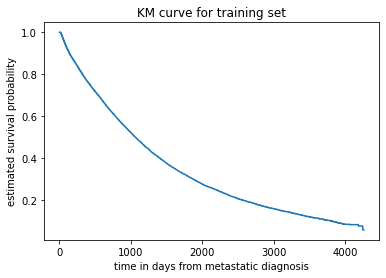

In [162]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

%matplotlib inline

time, survival_prob = kaplan_meier_estimator(mortality['death_status'].astype('bool'), mortality['timerisk_activity'])
plt.step(time, survival_prob, where = 'post')

plt.title('KM curve for training set')
plt.ylabel('estimated survival probability')
plt.xlabel('time in days from metastatic diagnosis')
print('Median survival in days:', time[np.where(survival_prob <0.5)][0])

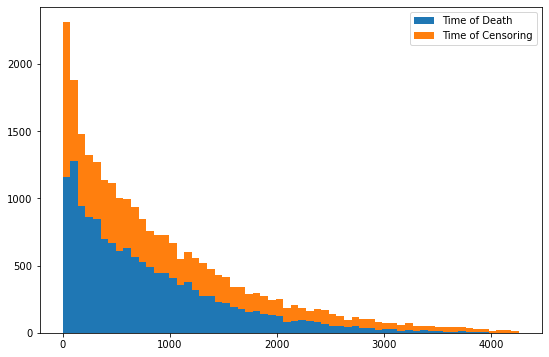

In [163]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((mortality['timerisk_activity'][mortality['death_status'].astype('bool')],
                               mortality['timerisk_activity'][~mortality['death_status'].astype('bool')]),
                              bins = 60, stacked = True)
_ = plt.legend(patches, ["Time of Death", "Time of Censoring"])

In [164]:
mortality = pd.merge(mortality, enhanced_met[['PatientID', 'diagnosis_date']], on = 'PatientID', how = 'outer')

In [165]:
# timerisk_activity_first is time from first diagnosis (metastatic or not) to death or last activity if no death date.
mortality.loc[:, 'timerisk_activity_first'] = (
    np.where(mortality['death_date'].isna(),
             (mortality['last_activity'] - mortality['diagnosis_date']).dt.days,
             (mortality['death_date'] - mortality['diagnosis_date']).dt.days)
)

In [166]:
# If timerisk_activity is less than 0, set to 0 otherwise remains unchanged. 
mortality['timerisk_activity_first'] = np.where(
    mortality['timerisk_activity_first'] < 0, 0, mortality['timerisk_activity_first'])

In [167]:
mortality.to_csv('mortality_cleaned_tr.csv', index = False, header = True)

In [168]:
mortality = mortality.filter(items = ['PatientID', 'death_status', 'timerisk_activity'])

In [169]:
mortality.sample(5)

,PatientID,death_status,timerisk_activity
3421,F51A7288AA1E7,1,803.0
25298,FC5D5D8E12939,0,1008.0
22913,FBFB17747678C,0,188.0
7712,F884724231615,1,392.0
10785,F901CA04CC1AE,1,1027.0


In [170]:
%whos DataFrame

Variable          Type         Data/Info
----------------------------------------
biomarkers        DataFrame                PatientID Bio<...>191261 rows x 19 columns]
biomarkers_max    DataFrame               PatientID biom<...>n[25131 rows x 2 columns]
demographics      DataFrame               PatientID gend<...>n[25341 rows x 7 columns]
enhanced_met      DataFrame               PatientID diag<...>n[25341 rows x 7 columns]
last_activity     DataFrame               PatientID last<...>n[25341 rows x 2 columns]
mets              DataFrame               PatientID Date<...>n[62969 rows x 3 columns]
mets_max          DataFrame               PatientID   me<...>n[25234 rows x 2 columns]
mortality         DataFrame               PatientID  dea<...>n[25341 rows x 3 columns]
orals             DataFrame               PatientID     <...>n[60303 rows x 5 columns]
orals_max         DataFrame               PatientID  ora<...>n[20879 rows x 2 columns]
progression       DataFrame               Patien

In [171]:
# Keep demographics, enhanced_met, and mortality
del biomarkers
del biomarkers_max
del last_activity
del mets
del mets_max
del orals
del orals_max
del progression
del progression_max
del telemedicine
del visit
del visit_tele
del visit_tele_max

### 4. MedicationAdministration

In [172]:
med_admin = pd.read_csv('MedicationAdministration.csv')

In [173]:
med_admin = med_admin[med_admin['PatientID'].isin(train_IDs)]

In [174]:
row_ID(med_admin)

(2039811, 20890)

In [175]:
med_admin.sample(5)

,PatientID,PracticeID,OrderID,DrugName,CommonDrugName,Route,DrugCategory,DetailedDrugCategory,AdministeredDate,AdministeredAmount,AdministeredUnits
1892711,FD937E35428C5,S1C794CE45C2A,MBE1A592374C62D032C0312EA6FA8CB5A,filgrastim,filgrastim,Subcutaneous,hematological agent,growth factor,2018-02-22,480.0,ug
413120,FB86A1476E9DB,SCC8EE4FB66C3,M4E7F7A7119FC98E9AE032B8EA7787775,trastuzumab-qyyp,trastuzumab-qyyp,Intravenous,antineoplastic,targeted/biologic,2022-04-06,693.0,mg
2033915,FE3AE5B6DB0CB,SA060E3ECE536,MAD74A3B1C9E65A452FAB5409AC446D5A,capecitabine,capecitabine,Intravenous,antineoplastic,chemotherapy,2022-03-21,21000.0,mg
149120,FA823288650AB,S0015D5ED587A,MBAC9DA612141051BC58EA37AEAA86392,ciprofloxacin hcl,ciprofloxacin,Oral,anti-infective,anti-infective,2021-07-01,500.0,mg
1027014,F95E79AD6EF26,S87C279DB0C8A,MCCCEEA6A2043A169BEF7090D322A839D,paclitaxel,paclitaxel,Intravenous,antineoplastic,chemotherapy,2015-01-09,174.0,mg


**An indicator variable will be created for key medications (ie., steroids, opioids, other pain meds, antibiotics, anticoagulation, diabetic medicaitons, etc.) around time of metastatic diagnosis. The elgibility window is -90 days from metastatic diagnosis to first line of therapy or +30, whichever comes first. First line of therapy is included as an upper bound because steroids are frequently administered as part of treatment for chemotherapy induced-nausea, so steroids might inadvertently capture chemotherapy treatment if upper bound is set after first line of therapy.** 

In [176]:
med_admin.shape

(2039811, 11)

In [177]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [178]:
line_therapy = line_therapy[line_therapy['PatientID'].isin(med_admin['PatientID'])]

In [179]:
line_therapy_1 = (
    line_therapy 
    .query('LineNumber == 1 and IsMaintenanceTherapy == False')
)

In [180]:
# If patients have 2 first line therapies, select earliest
line_therapy_1 = line_therapy_1.drop_duplicates(subset = ['PatientID'], keep = 'first')

In [181]:
med_admin = pd.merge(med_admin, line_therapy_1[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [182]:
med_admin = pd.merge(med_admin, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [183]:
med_admin.loc[:, 'AdministeredDate'] = pd.to_datetime(med_admin['AdministeredDate'])

In [184]:
med_admin.loc[:, 'StartDate'] = pd.to_datetime(med_admin['StartDate'])

In [185]:
med_admin['AdministeredDate'].isna().sum()

0

In [186]:
# Median days from metastatic date to start of first line of therapy. 
(
    med_admin
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .assign(start_met_diff = lambda x: (x.StartDate - x.met_date).dt.days)
    .start_met_diff
    .median()
)

22.0

In [187]:
# New variable upper_bound which defines upper bound
# If no StartDate (ie., no treatment received), then upper bound +30 from metastatic diagnosis 
# If StartDate is greater than 30 days from metastatic diagnosis, then upper bound +30 from metastatic diagnosis
# If StartDate is less than or equal 30 from metastatic diagnosis, then upper bound is one day before StartDate
conditions = [
    (med_admin['StartDate'].isna()) | ((med_admin['StartDate'] - med_admin['met_date']).dt.days > 30),
    ((med_admin['StartDate'] - med_admin['met_date']).dt.days <= 30)]    

choices = [30, (med_admin['StartDate'] - med_admin['met_date']).dt.days - 1]
    
med_admin.loc[:, 'upper_bound'] = np.select(conditions, choices)

In [188]:
med_admin.loc[:, 'upper_bound_date'] = (
    np.where(med_admin['upper_bound'] != 30, 
             med_admin['StartDate'] - pd.DateOffset(days = 1), 
             med_admin['met_date'] + pd.DateOffset(days = 30))
)

In [189]:
# Select window of -90 days and from metastatic diagnosis and remove clinical study drug. 
med_admin_win = (
    med_admin
    [((med_admin['AdministeredDate'] - med_admin['met_date']).dt.days >= -90) &
    (med_admin['AdministeredDate'] <= med_admin['upper_bound_date']) &
    (med_admin['CommonDrugName'] != 'Clinical study drug')]
)

In [190]:
row_ID(med_admin_win)

(57119, 3626)

In [191]:
med_admin_win.DrugCategory.value_counts()

pain agent                      12862
solution-fluid                   8706
hematological agent              6251
antineoplastic                   5071
steroid                          4862
antiemetic                       4596
anti-infective                   4166
anesthetic                       3679
proton pump inhibitor            1803
antihyperglycemic                1281
bone therapy agent (bta)         1071
antidepressant                    996
hormone                           698
cytoprotective                    609
gout and hyperurecemia agent      157
immunosuppressive                 116
hyperglycemic                      44
sedative agent                     40
antidote and reversal agent        31
endocrine                          28
antithyroid agent                  25
calcimimetic                       12
anticholinergic                    11
immunotherapy                       2
targeted therapy                    2
Name: DrugCategory, dtype: int64

#### Antineoplastic 

In [192]:
# Select window before upper bound (ie., < 30 or day before first LOT). 
med_admin_win_chemo = (
    med_admin
    [med_admin['AdministeredDate'] < med_admin['met_date']]
)

In [193]:
(
    med_admin_win_chemo.query('DrugCategory == "antineoplastic"').DrugName.value_counts().head(20)
)

paclitaxel                   19614
trastuzumab                  16601
cyclophosphamide             15081
doxorubicin hcl              10343
docetaxel                     9404
carboplatin                   5708
fulvestrant                   3693
pertuzumab                    3230
Clinical study drug           2655
leuprolide acetate            1719
goserelin acetate             1564
paclitaxel protein-bound      1347
fluorouracil                  1304
gemcitabine hcl               1126
anastrozole                    586
methotrexate sodium            451
ado-trastuzumab emtansine      450
letrozole                      417
eribulin mesylate              387
epirubicin hcl                 386
Name: DrugName, dtype: int64

#### Antiemetic

In [194]:
(
    med_admin_win
    .query('DrugCategory == "antiemetic"')
    .CommonDrugName
    .value_counts(normalize = True)
    .head(20)
)

ondansetron                   0.489121
palonosetron                  0.188860
metoclopramide                0.063751
fosaprepitant                 0.053525
prochlorperazine              0.050479
granisetron                   0.050479
olanzapine                    0.031114
aprepitant                    0.026110
promethazine                  0.016319
dronabinol                    0.009791
scopolamine                   0.008703
meclizine                     0.005657
netupitant/palonosetron       0.002393
fosnetupitant/palonosetron    0.001958
dimenhydrinate                0.001523
dolasetron                    0.000218
Name: CommonDrugName, dtype: float64

#### Solution-fluid

In [195]:
(
    med_admin_win
    .query('DrugCategory == "solution-fluid"')
    .CommonDrugName
    .value_counts(normalize = True)
)

sodium/saline preparations                     0.814266
electrolyte maintenance                        0.112911
iv solutions: dextrose-saline                  0.025270
iv solutions: dextrose-water                   0.023202
sodium chloride irrigating solution            0.014588
iv solutions: dextrose and lactated ringers    0.005858
water for irrigation, sterile                  0.003905
Name: CommonDrugName, dtype: float64

#### Steroid

In [196]:
(
    med_admin_win
    .query('DrugCategory == "steroid"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName      Route          
dexamethasone       Intravenous        2912
                    Oral               1237
prednisone          Oral                157
methylprednisolone  Intravenous         119
hydrocortisone      Intravenous          52
                    Topical              52
triamcinolone       Topical              45
prednisolone        Ophthalmic           30
dexamethasone       Nasogastric          29
                    enteral              24
fludrocortisone     Oral                 22
mometasone furoate  Inhalation           18
budesonide          Inhalation           17
dexamethasone       Intrajejunal         16
beclomethasone      Inhalation           14
clobetasol          Topical              14
budesonide          Nasal                10
dexamethasone       Intramuscular         7
triamcinolone       Intra-arterial        6
mometasone furoate  Topical               6
fluorometholone     Ophthalmic            5
methylprednisolone  Oral                

**Clinically relevant so will create glucocorticoid indicator variable. Hopefully by setting an upper bound of first line we are minimizing capturing those that received steroids for chemotherapy induced nausea.** 

In [197]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'steroid') & 
     ((med_admin_win['Route'] == 'Intravenous') | 
     (med_admin_win['Route'] == 'Oral') | 
     (med_admin_win['Route'] == 'Intrajejunal') | 
     (med_admin_win['Route'] == 'Nasogastric') | 
     (med_admin_win['Route'] == 'enteral'))]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName      Route       
dexamethasone       Intravenous     2912
                    Oral            1237
prednisone          Oral             157
methylprednisolone  Intravenous      119
hydrocortisone      Intravenous       52
dexamethasone       Nasogastric       29
                    enteral           24
fludrocortisone     Oral              22
dexamethasone       Intrajejunal      16
methylprednisolone  Oral               4
Name: PatientID, dtype: int64

In [198]:
med_admin_win.loc[:, 'steroid_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'steroid') & 
             ((med_admin_win['Route'] == 'Intravenous') | 
              (med_admin_win['Route'] == 'Oral') | 
              (med_admin_win['Route'] == 'Intrajejunal') |
              (med_admin_win['Route'] == 'Nasogastric') |
              (med_admin_win['Route'] == 'enteral')), 1, 0)
)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


#### Pain

In [199]:
(
    med_admin_win
    .query('DrugCategory == "pain agent"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending=False)
    .head(20)
)

CommonDrugName             Route      
oxycodone                  Oral           1971
acetaminophen              Oral           1577
hydromorphone              Intravenous    1460
morphine                   Intravenous     986
gabapentin                 Oral            848
lidocaine                  Transdermal     562
hydromorphone              Oral            512
ketorolac                  Intravenous     444
morphine                   Oral            427
tramadol                   Oral            353
acetaminophen/oxycodone    Oral            297
fentanyl                   Intravenous     295
lidocaine                  Topical         232
acetaminophen              Intravenous     220
cyclobenzaprine            Oral            201
ibuprofen                  Oral            187
lidocaine                  Intravenous     158
acetaminophen/hydrocodone  Oral            156
lidocaine                  Intradermal      92
pregabalin                 Oral             91
Name: PatientID, dtyp

**Three indicator variables from 'pain agent' category will be created:**
- **opioid PO: patient recieved oral opioid (fentanyl patch included)**
- **non-opioid PO: patient received non-opioid orally**
- **pain IV: patient received pain medciation intravenously**

##### Opioid PO

In [200]:
# List of avialable opioids in the US. 
opioid_list = [
    'buprenorphine',
    'codeine',
    'fentanyl',
    'hydrocodone',
    'hydromorphone',
    'methadone',
    'morphine',
    'oxycodone',
    'oxymorphone',
    'tapentadol',
    'tramadol'
]

In [201]:
(
    med_admin_win
    [((med_admin_win['Route'] == 'Oral') | 
      (med_admin_win['Route'] == 'Transdermal') | 
      (med_admin_win['Route'] == 'Sublingual')) &
     (med_admin_win['CommonDrugName'].str.contains('|'.join(opioid_list)))]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName             Route      
oxycodone                  Oral           1971
hydromorphone              Oral            512
morphine                   Oral            427
tramadol                   Oral            353
acetaminophen/oxycodone    Oral            297
acetaminophen/hydrocodone  Oral            156
acetaminophen/codeine      Oral             81
methadone                  Oral             76
fentanyl                   Transdermal      60
codeine                    Oral             30
morphine                   Sublingual        6
fentanyl                   Oral              1
                           Sublingual        1
Name: PatientID, dtype: int64

In [202]:
med_admin_win.loc[:, 'opioid_PO_diag'] = (
    np.where(((med_admin_win['Route'] == 'Oral') | 
              (med_admin_win['Route'] == 'Transdermal') | 
              (med_admin_win['Route'] == 'Sublingual')) &
             (med_admin_win['CommonDrugName'].str.contains('|'.join(opioid_list))), 1, 0)
)

##### Nonopioid PO

In [203]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'pain agent') & 
     (med_admin_win['Route'] == 'Oral') & 
     (~med_admin_win['CommonDrugName'].str.contains('|'.join(opioid_list)))]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName                     Route
acetaminophen                      Oral     1577
gabapentin                         Oral      848
cyclobenzaprine                    Oral      201
ibuprofen                          Oral      187
pregabalin                         Oral       91
celecoxib                          Oral       82
tizanidine                         Oral       51
naproxen                           Oral       50
baclofen                           Oral       31
methocarbamol                      Oral       28
lidocaine                          Oral       25
benzocaine/menthol                 Oral       20
salicylates                        Oral       20
naloxegol                          Oral       10
acetaminophen/butalbital/caffeine  Oral        8
indomethacin                       Oral        7
clonidine                          Oral        6
meloxicam                          Oral        5
phenol                             Oral        5
acetaminophen/aspirin/caffei

In [204]:
med_admin_win.loc[:, 'nonopioid_PO_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'pain agent') & 
             (med_admin_win['Route'] == 'Oral') & 
             (~med_admin_win['CommonDrugName'].str.contains('|'.join(opioid_list))), 1, 0)
)

##### Pain IV

In [205]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'pain agent') & (med_admin_win['Route'] == 'Intravenous')]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
    .head(20)
)

CommonDrugName  Route      
hydromorphone   Intravenous    1460
morphine        Intravenous     986
ketorolac       Intravenous     444
fentanyl        Intravenous     295
acetaminophen   Intravenous     220
lidocaine       Intravenous     158
meperidine      Intravenous      82
methocarbamol   Intravenous      36
abatacept       Intravenous       3
droperidol      Intravenous       3
alfentanil      Intravenous       1
butorphanol     Intravenous       1
clonidine       Intravenous       1
methadone       Intravenous       1
Name: PatientID, dtype: int64

In [206]:
med_admin_win.loc[:, 'pain_IV_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'pain agent') & 
             (med_admin_win['Route'] == 'Intravenous'), 1, 0)
)

#### Hematologic agent

In [207]:
(
    med_admin_win
    [med_admin_win['DrugCategory'] == 'hematological agent']
    .CommonDrugName
    .value_counts()
    .head(20)
)

heparin (porcine)         2665
enoxaparin                 984
aspirin                    665
pegfilgrastim              379
dalteparin,porcine         286
filgrastim                 228
epoetin alfa               155
filgrastim-sndz            143
apixaban                   122
alteplase                   90
warfarin                    72
darbepoetin alfa            65
rivaroxaban                 42
albumin human               42
clopidogrel                 35
epoetin alfa-epbx           33
sargramostim                26
fondaparinux                25
ticagrelor                  20
thrombin (recombinant)      19
Name: CommonDrugName, dtype: int64

**A therapeutic anticoagulation indicator variable will be created from the hematological agent category and will consist of:** 
* **Heparin: patients on a heparin gtt or other pareneral agents (eg., bivilrudin or argatroban)**
* **Enoxaparin: patients administered greater than prophylactic dosing of enoxaparin or other subcutaneous agents (eg., dalteparin or fondaparinux)**
* **DOAC: patients administered any dose of apxiaban, rivaroxabn, edoxaban, or dabigatran**
* **Warfarin: patients administered any dose of warfarin.**  

##### Heparin and other parenteral agents

In [208]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('heparin')]
    .AdministeredAmount
    .value_counts(normalize = True)
    .head(20)
)

5000.0000    0.497283
500.0000     0.267469
5.0000       0.051630
18.0000      0.020575
7500.0000    0.015528
15.0000      0.013587
30.0000      0.009317
16.0000      0.006211
300.0000     0.005823
12.0000      0.005823
17.0000      0.005047
3000.0000    0.004658
20.0000      0.004270
50.0000      0.003494
26.0000      0.003494
100.0000     0.003494
13.0000      0.003106
10.9987      0.003106
19.0000      0.003106
10.0000      0.002329
Name: AdministeredAmount, dtype: float64

**About 75% of administered doses of heparin are either 5000 or 500 units, likely reflecting prophylacitc dosing and catheter lock therapy, respectively. Doses in the teens likely indicate heparin gtt doses.** 

In [209]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('heparin')) & (med_admin_win['AdministeredAmount'] == 5000)]
    .Route
    .value_counts(normalize = True)
)

Subcutaneous           0.992963
Intravenous            0.006255
Other/Miscellaneous    0.000782
Name: Route, dtype: float64

In [210]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('heparin')) & (med_admin_win['AdministeredAmount'] == 500)]
    .Route
    .value_counts(normalize = True)
)

Intravenous            0.585903
Intrajejunal           0.402349
Other/Miscellaneous    0.010279
Intravesical           0.001468
Name: Route, dtype: float64

In [211]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('heparin')) & (med_admin_win['AdministeredUnits'] == 'unit/kg/hr')]
    .AdministeredAmount
    .value_counts(normalize = True)
    .head(10)
)

18.0000    0.223629
15.0000    0.143460
16.0000    0.067511
12.0000    0.059072
17.0000    0.054852
26.0000    0.037975
20.0000    0.037975
10.9987    0.033755
19.0000    0.033755
13.0000    0.033755
Name: AdministeredAmount, dtype: float64

In [212]:
# Total number of instances of a patient receiving heparin, bivalrudin, or argatroban drip
(
    med_admin_win
    [((med_admin_win['CommonDrugName'].str.contains('heparin')) & 
      (med_admin_win['AdministeredUnits'] == 'unit/kg/hr')) | 
     (med_admin_win['CommonDrugName'].str.contains('bivalirudin')) | 
     (med_admin_win['CommonDrugName'].str.contains('argatroban'))]
    .groupby(['CommonDrugName', 'AdministeredUnits'])['PatientID'].count()
    .sort_values(ascending = False)
 )

CommonDrugName     AdministeredUnits
heparin (porcine)  unit/kg/hr           243
Name: PatientID, dtype: int64

In [213]:
med_admin_win.loc[:, 'heparin_diag'] = (
    np.where(((med_admin_win['CommonDrugName'].str.contains('heparin')) & 
              (med_admin_win['AdministeredUnits'] == 'unit/kg/hr')) | 
             (med_admin_win['CommonDrugName'].str.contains('bivalirudin')) | 
             (med_admin_win['CommonDrugName'].str.contains('argatroban')), 1, 0)
)

###### Enoxaparin and other subcutaneous agents 

In [214]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('enoxaparin')]
    .AdministeredAmount
    .value_counts(normalize = True)
    .head(10)
)

40.0     0.673913
30.0     0.154244
60.0     0.062112
50.0     0.046584
80.0     0.027950
100.0    0.022774
70.0     0.004141
130.0    0.002070
90.0     0.002070
120.0    0.002070
Name: AdministeredAmount, dtype: float64

**Doses of 40 or 30 likley reflect prophylactic VTE dosing and are less clinically relevant than higher doses.** 

In [215]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('dalteparin')]
    .AdministeredAmount
    .value_counts(normalize = True)
    .head(10)
)

5000.0     0.604895
15000.0    0.199301
18000.0    0.073427
17500.0    0.034965
7500.0     0.027972
12500.0    0.027972
10000.0    0.027972
6000.0     0.003497
Name: AdministeredAmount, dtype: float64

**Dose of 5,000 or less likley reflects prophylactic VTE dosing and is less clinically relevant than higher doses.** 

In [216]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('fondaparinux')]
    .AdministeredAmount
    .value_counts(normalize = True)
)

2.5     0.80
7.5     0.16
10.0    0.04
Name: AdministeredAmount, dtype: float64

**Dose of 2.5 likley reflects prophylactic VTE dosing and is less clinically relevant than higher doses.** 

In [217]:
(
    med_admin_win
    [((med_admin_win['CommonDrugName'].str.contains('enoxaparin')) & 
      (med_admin_win['AdministeredAmount'] > 40)) | 
     ((med_admin_win['CommonDrugName'].str.contains('dalteparin')) & 
      (med_admin_win['AdministeredAmount'] > 5000)) | 
     ((med_admin_win['CommonDrugName'].str.contains('fondaparinux')) & 
      (med_admin_win['AdministeredAmount'] > 2.5))]
    .groupby(['CommonDrugName', 'AdministeredAmount'])['PatientID'].count()
    .sort_values(ascending = False)
    .head(20)
)

CommonDrugName      AdministeredAmount
enoxaparin          60.0                  60
dalteparin,porcine  15000.0               57
enoxaparin          50.0                  45
                    80.0                  27
                    100.0                 22
dalteparin,porcine  18000.0               21
                    17500.0               10
                    10000.0                8
                    12500.0                8
                    7500.0                 8
enoxaparin          70.0                   4
fondaparinux        7.5                    4
enoxaparin          90.0                   2
                    120.0                  2
                    130.0                  2
dalteparin,porcine  6000.0                 1
enoxaparin          150.0                  1
fondaparinux        10.0                   1
Name: PatientID, dtype: int64

In [218]:
med_admin_win.loc[:, 'enoxaparin_diag'] = (
    np.where(((med_admin_win['CommonDrugName'].str.contains('enoxaparin')) & 
              (med_admin_win['AdministeredAmount'] > 40)) | 
             ((med_admin_win['CommonDrugName'].str.contains('dalteparin')) & 
              (med_admin_win['AdministeredAmount'] > 5000)) | 
             ((med_admin_win['CommonDrugName'].str.contains('fondaparinux')) & 
              (med_admin_win['AdministeredAmount'] > 2.5)), 1, 0)
)

##### DOAC

In [219]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('apixaban')) | 
     (med_admin_win['CommonDrugName'].str.contains('rivaroxaban')) | 
     (med_admin_win['CommonDrugName'].str.contains('dabigatran')) | 
     (med_admin_win['CommonDrugName'].str.contains('edoxaban'))]
    .CommonDrugName
    .value_counts()
)

apixaban                122
rivaroxaban              42
dabigatran etexilate      9
Name: CommonDrugName, dtype: int64

In [220]:
med_admin_win.loc[:, 'doac_diag'] = (
    np.where((med_admin_win['CommonDrugName'].str.contains('apixaban')) | 
             (med_admin_win['CommonDrugName'].str.contains('rivaroxaban')) | 
             (med_admin_win['CommonDrugName'].str.contains('dabigatran')) | 
             (med_admin_win['CommonDrugName'].str.contains('edoxaban')), 1, 0)
)

##### Warfarin

In [221]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('warfarin'))]
    .AdministeredAmount
    .value_counts()
)

5.00     20
2.50     13
2.00     10
4.00     10
3.00      3
6.00      3
7.50      2
8.00      2
1.25      2
1.00      2
10.00     1
1.50      1
3.50      1
Name: AdministeredAmount, dtype: int64

In [222]:
med_admin_win.loc[:, 'warfarin_diag'] = np.where((med_admin_win['CommonDrugName'].str.contains('warfarin')), 1, 0)

##### Anticoagulation merge 

In [223]:
# Combine heparin, enoxparin, DOAC, and warfarin columns into a single anticoagulation indicator variable. 
med_admin_win['ac_diag'] = (
    med_admin_win['heparin_diag'] + med_admin_win['enoxaparin_diag'] + med_admin_win['doac_diag'] + med_admin_win['warfarin_diag']
)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [224]:
# Drop heparin, enoxaparin, DOAC, and warfarin columns. 
med_admin_win = med_admin_win.drop(columns = ['heparin_diag', 'enoxaparin_diag', 'doac_diag', 'warfarin_diag'])

##### DAPT

In [225]:
# Create dataframe containing patients who received aspirin or clopidogrel. 
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('aspirin')) | 
     (med_admin_win['CommonDrugName'].str.contains('clopidogrel')) | 
     (med_admin_win['CommonDrugName'].str.contains('ticagrelor')) | 
     (med_admin_win['CommonDrugName'].str.contains('prasugrel'))]
    .drop_duplicates(subset = ['PatientID', 'CommonDrugName'], keep = 'first')
    .groupby('PatientID')['PatientID'].count()
    .to_frame(name = 'dapt')
    .query('dapt == 2')
    .count()
)

dapt    9
dtype: int64

**Considering such a small number of patients are receiving DAPT, no variable created.** 

##### GCSF

In [226]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('filgrastim')]
    .CommonDrugName
    .value_counts()
)

pegfilgrastim         379
filgrastim            228
filgrastim-sndz       143
pegfilgrastim-jmdb     18
tbo-filgrastim         10
pegfilgrastim-cbqv      8
pegfilgrastim-bmez      8
pegfilgrastim-apgf      7
filgrastim-aafi         1
Name: CommonDrugName, dtype: int64

##### Epoetin

In [227]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('epoetin')]
    .CommonDrugName
    .value_counts()
)

epoetin alfa         155
darbepoetin alfa      65
epoetin alfa-epbx     33
Name: CommonDrugName, dtype: int64

**Both GCSF and epotein likely reflect chemotherapy toxicity and so will not be coded.** 

##### tPA

In [228]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('alteplase')]
    .groupby(['AdministeredAmount', 'Route'])['PatientID'].count()
    .sort_values (ascending = False)
)

AdministeredAmount  Route              
2.0                 Intravenous            57
                    Other/Miscellaneous    10
1.0                 Other/Miscellaneous     7
                    Intravenous             2
50.0                Intravenous             2
2.0                 Intrajejunal            1
5.0                 Intrapleural            1
                    Intravenous             1
10.0                Intrapleural            1
49.0                Intravenous             1
Name: PatientID, dtype: int64

**No indicator variable created since doses received are for catheter clearance rather than for acute ischemic stroke or pulmonary embolism.** 

#### Anti-infective 

In [229]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'anti-infective')] 
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
    .head(20)
)

CommonDrugName                 Route      
cefazolin                      Intravenous    742
vancomycin                     Intravenous    390
piperacillin/tazobactam        Intravenous    327
cefepime                       Intravenous    264
ceftriaxone                    Intravenous    238
nystatin                       Topical        199
doxycycline                    Oral           109
fluconazole                    Oral           103
ciprofloxacin                  Oral            94
metronidazole                  Intravenous     87
meropenem                      Intravenous     80
metronidazole                  Oral            76
cephalexin                     Oral            75
bacitracin                     Topical         72
nystatin                       Oral            68
sulfamethoxazole/trimethoprim  Oral            67
acyclovir                      Oral            66
clindamycin                    Intravenous     58
metronidazole                  Topical         54
levoflo

**Clinically relevant; two separate indicator variables from the anti-infective drug category will be created:** 
* **antiinfective IV group** 
* **antiinfective PO group**

##### Anti-infective IV

In [230]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'anti-infective') & 
     (med_admin_win['Route'] == 'Intravenous')]
    .CommonDrugName
    .value_counts(normalize = True)
    .head(20)
)

cefazolin                                        0.286819
vancomycin                                       0.150754
piperacillin/tazobactam                          0.126401
cefepime                                         0.102049
ceftriaxone                                      0.091998
metronidazole                                    0.033630
meropenem                                        0.030924
clindamycin                                      0.022420
levofloxacin                                     0.020874
acyclovir                                        0.014689
fluconazole                                      0.014302
ampicillin/sulbactam                             0.013916
dextrose, iso-osmotic/piperacillin/tazobactam    0.013916
gentamicin                                       0.013143
ciprofloxacin                                    0.012756
ceftazidime                                      0.010437
tigecycline                                      0.006958
azithromycin  

**This group consists mainly of antibacterials. Antifungals and antivirals are also included.** 

In [231]:
med_admin_win.loc[:, 'antiinfective_IV_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'anti-infective') & 
             (med_admin_win['Route'] == 'Intravenous'), 1, 0)
)

##### Anti-infective PO

In [232]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'anti-infective') & 
     (med_admin_win['Route'] == 'Oral')]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
    .head(20)
)

CommonDrugName                 Route
doxycycline                    Oral     109
fluconazole                    Oral     103
ciprofloxacin                  Oral      94
metronidazole                  Oral      76
cephalexin                     Oral      75
nystatin                       Oral      68
sulfamethoxazole/trimethoprim  Oral      67
acyclovir                      Oral      66
hydroxychloroquine             Oral      36
levofloxacin                   Oral      32
azithromycin                   Oral      30
amoxicillin/clavulanic acid    Oral      28
cefuroxime                     Oral      25
vancomycin                     Oral      24
amoxicillin                    Oral      22
oseltamivir                    Oral      22
valacyclovir                   Oral      18
moxifloxacin                   Oral      18
nitrofurantoin                 Oral      18
cefpodoxime                    Oral      15
Name: PatientID, dtype: int64

In [233]:
med_admin_win.loc[:, 'antiinfective_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'anti-infective') & 
             (med_admin_win['Route'] == 'Oral'), 1, 0)
)

#### Anesthetic

In [234]:
(
    med_admin_win
    .query('DrugCategory == "anesthetic"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName  Route        
fentanyl        Intravenous      1402
propofol        Intravenous      1049
midazolam       Intravenous       934
remifentanil    Intravenous       173
ketamine        Intravenous        43
etomidate       Intravenous        11
sufentanil      Intravenous         5
                Epidural            4
fentanyl        Buccal              3
midazolam       Intramuscular       2
fentanyl        Intrathecal         1
                Oral                1
Name: PatientID, dtype: int64

**Most likely capturing patients undergoing biopsy or procedure related to new metastatic diagnosis. Unclear prognostic value so no indicator variable created.** 

#### Cytoprotective

In [235]:
(
    med_admin_win
    .query('DrugCategory == "cytoprotective"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName            Route           
vitamin b12 preparations  Intramuscular       195
                          Oral                185
folic acid                Oral                141
vitamin b12 preparations  Subcutaneous         44
                          Intrajejunal         14
folic acid                enteral               9
urate oxidase             Intravenous           8
folic acid                Gastrostomy Tube      7
                          Intravenous           1
Name: PatientID, dtype: int64

#### Antihyperglycemic

In [236]:
(
    med_admin_win
    .query('DrugCategory == "antihyperglycemic"')
    .CommonDrugName
    .value_counts(normalize = True)
)

insulin lispro                             0.503513
insulin glargine                           0.187354
insulin regular                            0.149102
metformin                                  0.066354
glipizide                                  0.034348
sitagliptin                                0.024200
linagliptin                                0.016393
insulin lispro/insulin lispro protamine    0.010148
dapagliflozin                              0.004684
insulin aspart                             0.001561
insulin isophane (nph)                     0.001561
glimepiride                                0.000781
Name: CommonDrugName, dtype: float64

In [237]:
med_admin_win.loc[:, 'antihyperglycemic_diag'] = np.where(med_admin_win['DrugCategory'] == 'antihyperglycemic', 1, 0)

#### Proton pump inhibitor

In [238]:
(
    med_admin_win
    .query('DrugCategory == "proton pump inhibitor"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName  Route           
lansoprazole    Oral                659
pantoprazole    Oral                462
                Intravenous         401
omeprazole      Oral                204
lansoprazole    enteral              16
                Gastrostomy Tube     12
                Nasogastric           8
esomeprazole    Oral                  3
rabeprazole     Oral                  2
pantoprazole    Intramuscular         1
Name: PatientID, dtype: int64

In [239]:
med_admin_win.loc[:, 'ppi_diag'] = np.where(med_admin_win['DrugCategory'] == 'proton pump inhibitor', 1, 0)

#### Antidepressant

In [240]:
(
    med_admin_win
    .query('DrugCategory == "antidepressant"')
    .CommonDrugName
    .value_counts()
)

escitalopram     136
duloxetine       121
mirtazapine      119
citalopram       112
sertraline        99
trazodone         89
paroxetine        75
bupropion         70
venlafaxine       65
fluoxetine        54
nortriptyline     14
amitriptyline     14
doxepin           13
vilazodone         8
vortioxetine       7
Name: CommonDrugName, dtype: int64

In [241]:
med_admin_win.loc[:, 'antidepressant_diag'] = np.where(med_admin_win['DrugCategory'] == 'antidepressant', 1, 0)

#### Bone therapy agent

In [242]:
(
    med_admin_win
    .query('DrugCategory == "bone therapy agent (bta)"')
    .CommonDrugName
    .value_counts()
)

denosumab           571
zoledronic acid     462
pamidronic acid      34
romosozumab-aqqg      2
alendronic acid       1
ibandronic acid       1
Name: CommonDrugName, dtype: int64

In [243]:
med_admin_win.loc[:, 'bta_diag'] = np.where(med_admin_win['DrugCategory'] == 'bone therapy agent (bta)', 1, 0)

#### Hormone

In [244]:
(
    med_admin_win
    .query('DrugCategory == "hormone"')
    .CommonDrugName
    .value_counts()
)

levothyroxine    573
vasopressin       49
calcitonin        36
desmopressin      20
liothyronine      14
octreotide         3
dinoprostone       1
misoprostol        1
thyroid            1
Name: CommonDrugName, dtype: int64

**Hypothyroidism might linked to higher all-cause mortality, so i ndicator variable will be created for patients receiving levothyroxine.** 

In [245]:
med_admin_win.loc[:, 'thyroid_diag'] = np.where(med_admin_win['CommonDrugName'] == 'levothyroxine', 1, 0)

#### Gout and hyperurecemia agent 

In [246]:
(
    med_admin_win
    .query('DrugCategory == "gout and hyperurecemia agent"')
    .CommonDrugName
    .value_counts()
)

allopurinol    135
colchicine      22
Name: CommonDrugName, dtype: int64

#### 4.16 Immunosuppressive 

In [247]:
(
    med_admin_win
    .query('DrugCategory == "immunosuppressive"')
    .CommonDrugName
    .value_counts()
)

tacrolimus           55
mycophenolic acid    33
cyclosporine         15
azathioprine          5
sirolimus             5
tocilizumab           3
Name: CommonDrugName, dtype: int64

In [248]:
med_admin_win.loc[:, 'is_diag'] = np.where(med_admin_win['DrugCategory'] == 'immunosuppressive', 1, 0)

#### Sedative agent

In [249]:
(
    med_admin_win
    .query('DrugCategory == "sedative agent"')
    .CommonDrugName
    .value_counts()
)

zolpidem    40
Name: CommonDrugName, dtype: int64

#### Endocrine

In [250]:
(
    med_admin_win
    .query('DrugCategory == "endocrine"')
    .CommonDrugName
    .value_counts()
)

oxytocin    28
Name: CommonDrugName, dtype: int64

#### Antidote and reversal agent

In [251]:
(
    med_admin_win
    .query('DrugCategory == "antidote and reversal agent"')
    .CommonDrugName
    .value_counts()
)

naloxone          12
acetylcysteine    10
methylene blue     3
naltrexone         3
flumazenil         2
protamine          1
Name: CommonDrugName, dtype: int64

#### Hyperglycemic

In [252]:
(
    med_admin_win
    .query('DrugCategory == "hyperglycemic"')
    .CommonDrugName
    .value_counts()
)

carbohydrates    26
glucagon         18
Name: CommonDrugName, dtype: int64

#### Antithyroid agent

In [253]:
(
    med_admin_win
    .query('DrugCategory == "antithyroid agent"')
    .CommonDrugName
    .value_counts()
)

methimazole         17
propylthiouracil     8
Name: CommonDrugName, dtype: int64

#### Anticholinergic

In [254]:
(
    med_admin_win
    .query('DrugCategory == "anticholinergic"')
    .CommonDrugName
    .value_counts()
)

atropine    11
Name: CommonDrugName, dtype: int64

#### Calciumimetic

In [255]:
(
    med_admin_win
    .query('DrugCategory == "calcimimetic"')
    .CommonDrugName
    .value_counts()
)

cinacalcet    12
Name: CommonDrugName, dtype: int64

#### Targeted therapy

In [256]:
(
    med_admin_win
    .query('DrugCategory == "targeted therapy"')
    .CommonDrugName
    .value_counts()
)

infliximab    2
Name: CommonDrugName, dtype: int64

#### Route

In [257]:
(
    med_admin_win['Route']
    .value_counts(normalize = True)
    .head(10)
)

Intravenous            0.534055
Oral                   0.274882
Subcutaneous           0.102057
Intrajejunal           0.016642
Intramuscular          0.016372
Topical                0.014128
Transdermal            0.012602
Other/Miscellaneous    0.012261
enteral                0.003249
Intradermal            0.002495
Name: Route, dtype: float64

In [258]:
(
    med_admin_win
    .query('Route == "Intrajejunal"')
    .CommonDrugName
    .value_counts()
    .head(10)
)

sodium/saline preparations    568
heparin (porcine)             276
filgrastim                     20
dexamethasone                  16
vitamin b12 preparations       14
epoetin alfa                    7
morphine                        5
darbepoetin alfa                4
ceftriaxone                     4
ondansetron                     2
Name: CommonDrugName, dtype: int64

#### Condensing

In [259]:
# Select columns with indicator variables and PatientID, then collapse rows by PatientID and sum columns. 
med_admin_wide = (
    med_admin_win
    [med_admin_win.columns[med_admin_win.columns.str.contains('diag|PatientID')]]
    .groupby('PatientID').sum()
)

In [260]:
# Replace numbers greater than 1 with 1; 0 remains unchanged. 
med_admin_wide = (
    med_admin_wide.mask(med_admin_wide > 1, 1)
    .reset_index()
)

In [261]:
row_ID(med_admin_wide)

(3626, 3626)

In [262]:
# Append missing training IDs.
med_admin_wide = (
    med_admin_wide.append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(med_admin_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False
    )
    .fillna(0)
)

In [263]:
row_ID(med_admin_wide)

(25341, 25341)

In [264]:
med_admin_wide.shape

(25341, 14)

In [265]:
med_admin_wide.sample(5)

,PatientID,steroid_diag,opioid_PO_diag,nonopioid_PO_diag,pain_IV_diag,ac_diag,antiinfective_IV_diag,antiinfective_diag,antihyperglycemic_diag,ppi_diag,antidepressant_diag,bta_diag,thyroid_diag,is_diag
1364,F1C613E1A9CFE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5472,F5B93352B49C3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6861,F696EE91CDA2B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1307,F055623532730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24179,F87174F4799A8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [266]:
# Percent of patients receiving relevant medications at time of metastatic diagnosis. 
(med_admin_wide.iloc[:, 1:].sum()/len(med_admin_wide)).sort_values(ascending = False)

bta_diag                  0.038357
steroid_diag              0.035279
pain_IV_diag              0.031372
antiinfective_IV_diag     0.023874
opioid_PO_diag            0.021901
nonopioid_PO_diag         0.021704
ppi_diag                  0.010102
antiinfective_diag        0.007695
antidepressant_diag       0.006393
antihyperglycemic_diag    0.004656
ac_diag                   0.004222
thyroid_diag              0.003275
is_diag                   0.000276
dtype: float64

In [267]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
demographics          DataFrame               PatientID gend<...>n[25341 rows x 7 columns]
enhanced_met          DataFrame               PatientID diag<...>n[25341 rows x 7 columns]
line_therapy          DataFrame               PatientID     <...>n[56675 rows x 9 columns]
line_therapy_1        DataFrame               PatientID     <...>n[19518 rows x 9 columns]
med_admin             DataFrame                 PatientID   <...>039811 rows x 15 columns]
med_admin_wide        DataFrame               PatientID  ste<...>[25341 rows x 14 columns]
med_admin_win         DataFrame                 PatientID   <...>[57119 rows x 28 columns]
med_admin_win_chemo   DataFrame                 PatientID   <...>361165 rows x 15 columns]
mortality             DataFrame               PatientID  dea<...>n[25341 rows x 3 columns]


In [268]:
# Keep demographics, enhanced_met, med_admin_wide, and mortality
del line_therapy
del line_therapy_1
del med_admin
del med_admin_win
del med_admin_win_chemo

### 5. Enhanced_MetBreastBiomarkers

In [269]:
biomarkers = pd.read_csv('Enhanced_MetBreastBiomarkers.csv')

In [270]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(train_IDs)]

In [271]:
biomarkers.shape

(191261, 19)

In [272]:
biomarkers.sample(5)

,PatientID,BiomarkerName,CellType,SpecimenCollectedDate,SpecimenReceivedDate,ResultDate,BiomarkerStatus,SampleType,ExpressionLevel,TissueCollectionSite,TestType,LabName,Assay,DnaType,IHCClone,StainingIntensity,PercentStaining,CombinedPositiveScore,BiomarkerDetail
209289,F35A6E3E21CB1,BRCA,NaN,2013-08-30,2013-09-03,2013-10-16,No BRCA mutation,Blood,NaN,NaN,NaN,Myriad,NaN,Germline,NaN,NaN,NaN,NaN,NaN
50545,FDBE3477F91DB,BRCA,NaN,2015-05-06,NaN,2015-06-05,No BRCA mutation,Tissue,NaN,NaN,NaN,Caris Life Sciences,NaN,Somatic,NaN,NaN,NaN,NaN,NaN
98544,FB0A58C422F26,HER2,NaN,2016-07-26,NaN,2016-08-02,IHC negative (0-1+),Tissue,NaN,Primary site,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88115,F991A15FAA992,HER2,NaN,2014-05-12,NaN,2014-05-18,FISH negative/not amplified,Tissue,NaN,Metastatic site,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111607,F439F4F9F5F2D,ER,NaN,2007-10-15,NaN,2007-10-17,Positive,Tissue,NaN,Primary site,NaN,NaN,NaN,NaN,NaN,NaN,30% - 39.9%,NaN,NaN


In [273]:
biomarkers.groupby('BiomarkerName')['BiomarkerStatus'].value_counts(normalize = True, dropna = False)

BiomarkerName  BiomarkerStatus                              
BRCA           No BRCA mutation                                 0.839607
               Genetic Variant of Unknown Significance (VUS)    0.049156
               BRCA2 mutation identified                        0.048803
               BRCA1 mutation identified                        0.028604
               Unsuccessful/indeterminate test                  0.023024
               Unknown                                          0.004026
               Results pending                                  0.002613
               Genetic Variant Favor Polymorphism               0.001978
               Both BRCA1 and BRCA2 mutations identified        0.001059
               BRCA mutation NOS                                0.000918
               Other                                            0.000212
ER             Positive                                         0.745933
               Negative                                        

**The Biomarkers dataframe is in a long format. The goal is to build a single-row-per-patient dataframe with columns reflecting a patient's biomarker status within a predefined elgibility window. For this project, the elgibility window is defined as negative infinity to +30 days from time of diagnosis of metastatic disease (ie., index date).** 

**Regarding biomarker date information, result date is the date the biomarker result was first reported, and so represents the date on which the clinician would be expected to have information about the patient’s biomarker status to inform the course of treatment. Flatiron recommends using result date as the relevant biomarker test date and using specimen received date as the proxy when result date is not available. The gaps between collected date and either received or result date are substantially more variable.**

**We'll begin by imputing specimen received date when result date is missing. Then we'll select all biomarkers that fall within the elbility window.**

In [274]:
biomarkers['SpecimenCollectedDate'].isna().sum()/biomarkers.shape[0]

0.018785847611379216

In [275]:
biomarkers['SpecimenReceivedDate'].isna().sum()/biomarkers.shape[0]

0.869089882411992

In [276]:
biomarkers['ResultDate'].isna().sum()/biomarkers.shape[0]

0.1293624941833411

In [277]:
biomarkers.loc[:, 'ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [278]:
biomarkers.loc[:, 'SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [279]:
# Percenage of missing 'ResultDate' that can be replaced by 'SpecimenReceivedDate'. 
(
    len(biomarkers[(biomarkers['ResultDate'].isna()) & (biomarkers['SpecimenReceivedDate'].notna())])
    /len(biomarkers[biomarkers['ResultDate'].isna()])
)

0.006426319618462534

In [280]:
# Replace missing result date with specimen received date. 
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [281]:
# Final percent of biomarkers without a result date and thus will not be included. 
biomarkers['result_date'].isna().sum()/biomarkers.shape[0]

0.12853116944907744

In [282]:
biomarkers = pd.merge(biomarkers, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [283]:
# Create new variable that captures difference in days between result date and metastatic diagnosis. 
biomarkers.loc[:, 'bio_date_diff'] = (biomarkers['result_date'] - biomarkers['met_date']).dt.days

In [284]:
# Select all patients with biomarkers < +30 from metastatic diagnosis. 
biomarker_win = biomarkers[biomarkers['bio_date_diff'] <= 30]

**The next step is defining positive and negative staus for each biomarker. For ER, PR, and HER2 the biomarker result closest to metastatic diagnosis will be selected. Positive will be selected over negative if both are on the same date.** 

**For BRCA and PIK3CA, status will be labeled as positive if ever positive and negative if always negative. Similarly for PDL1, the highest percent staining value is selected rather than value closest to metastatic diagnosis.**

#### 5.1 Assigning patient-level biomarker status for ER, PR, and HER2

In [285]:
# Identify positive and negative cases
biomarker_name = [
    'ER',
    'PR',
    'HER2']

pos_neg = [
    'Positive',
    'IHC positive (3+)',
    'FISH positive/amplified',
    'Positive NOS',
    'NGS positive (ERBB2 amplified)',
    'Negative', 
    'IHC negative (0-1+)',
    'FISH negative/not amplified',
    'Negative NOS',
    'NGS negative (ERBB2 not amplified)']

In [286]:
biomarker_hr_her2 = (
    biomarker_win
    .query('BiomarkerName == @biomarker_name')
    .query('BiomarkerStatus == @pos_neg')
)

In [287]:
row_ID(biomarker_hr_her2)

(103917, 21950)

In [288]:
# Create indicator variable where where 2 if positive, 1 if negative, and 0 if unknown or missing. 
conditions = [
    (biomarker_hr_her2['BiomarkerStatus'] == 'Positive') | 
    (biomarker_hr_her2['BiomarkerStatus'] == 'IHC positive (3+)') | 
    (biomarker_hr_her2['BiomarkerStatus'] == 'FISH positive/amplified') |
    (biomarker_hr_her2['BiomarkerStatus'] == 'Positive NOS') |
    (biomarker_hr_her2['BiomarkerStatus'] == 'NGS positive (ERBB2 amplified)'), 
    (biomarker_hr_her2['BiomarkerStatus'] == 'Negative') |
    (biomarker_hr_her2['BiomarkerStatus'] == 'IHC negative (0-1+)') |
    (biomarker_hr_her2['BiomarkerStatus'] == 'FISH negative/not amplified') |
    (biomarker_hr_her2['BiomarkerStatus'] == 'Negative NOS') |
    (biomarker_hr_her2['BiomarkerStatus'] == 'NGS negative (ERBB2 not amplified)')]

choices = [2,1]
biomarker_hr_her2.loc[:, 'bio_status'] = np.select(conditions, choices)

In [289]:
biomarker_hr_her2_wide = (
    biomarker_hr_her2
    .sort_values(by = ['PatientID', 'BiomarkerName', 'result_date', 'bio_status'], ascending = [True, True, False, False])
    .drop_duplicates(subset = ['PatientID', 'BiomarkerName'], keep = 'first')
    .pivot(index = 'PatientID', columns = 'BiomarkerName', values = 'bio_status')
    .reset_index()
)

In [290]:
row_ID(biomarker_hr_her2_wide)

(21950, 21950)

In [291]:
biomarker_hr_her2_wide = (
    biomarker_hr_her2_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(biomarker_hr_her2_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
    .fillna(0)
)

In [292]:
row_ID(biomarker_hr_her2_wide)

(25341, 25341)

#### 5.2 Assigning patient-level biomarker status for BRCA and PIK3CA

In [293]:
biomarker_brca_pik = (
    biomarker_win
    .query('BiomarkerName == "BRCA" or BiomarkerName == "PIK3CA"')
)

In [294]:
row_ID(biomarker_brca_pik)

(6910, 4928)

In [295]:
# Create indicator variable where where 2 if positive, 1 if negative, and 0 if unknown or missing. 
conditions = [
    (biomarker_brca_pik['BiomarkerStatus'] == 'BRCA1 mutation identified') |
    (biomarker_brca_pik['BiomarkerStatus'] == 'BRCA2 mutation identified') |
    (biomarker_brca_pik['BiomarkerStatus'] == 'Both BRCA1 and BRCA2 mutations identified') |
    (biomarker_brca_pik['BiomarkerStatus'] == 'BRCA mutation NOS') | 
    (biomarker_brca_pik['BiomarkerStatus'] == 'Positive'), 
    (biomarker_brca_pik['BiomarkerStatus'] == 'No BRCA mutation') |
    (biomarker_brca_pik['BiomarkerStatus'] == 'Genetic Variant of Unknown Significance (VUS)') |
    (biomarker_brca_pik['BiomarkerStatus'] == 'Genetic Variant Favor Polymorphism') |
    (biomarker_brca_pik['BiomarkerStatus'] == 'Negative')]

choices = [2,1]
biomarker_brca_pik.loc[:, 'bio_status'] = np.select(conditions, choices, default = 0)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [296]:
# Select biomarker status closest to metastatic diagnosis among duplicates, merge with nonduplciates, then pivot. 
biomarker_brca_pik_wide = (
    biomarker_brca_pik
    .sort_values(by = ['PatientID', 'BiomarkerName', 'bio_status'], ascending = False)
    .drop_duplicates(subset = ['PatientID', 'BiomarkerName'], keep = 'first')
    .pivot(index = 'PatientID', columns = 'BiomarkerName', values = 'bio_status')
    .reset_index()
)
biomarker_hr_her2_wide.columns.name = None

In [297]:
row_ID(biomarker_brca_pik_wide)

(4928, 4928)

In [298]:
biomarker_brca_pik_wide = (
    biomarker_brca_pik_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(biomarker_brca_pik_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
    .fillna(0)
)

In [299]:
row_ID(biomarker_brca_pik_wide)

(25341, 25341)

In [300]:
biomarker_notpdl1_wide = pd.merge(biomarker_hr_her2_wide, biomarker_brca_pik_wide, on = 'PatientID')

In [301]:
row_ID(biomarker_notpdl1_wide)

(25341, 25341)

In [302]:
biomarker_notpdl1_wide['BRCA'] = (
    biomarker_notpdl1_wide['BRCA'].replace({
        2: 'positive',
        1: 'negative',
        0: 'unknown',
        np.nan: 'unknown'})
)

In [303]:
biomarker_notpdl1_wide['ER'] = (
    biomarker_notpdl1_wide['ER'].replace({
        2: 'positive',
        1: 'negative',
        0: 'unknown',
        np.nan: 'unknown'})
)

In [304]:
biomarker_notpdl1_wide['HER2'] = (
    biomarker_notpdl1_wide['HER2'].replace({
        2: 'positive',
        1: 'negative',
        0: 'unknown',
        np.nan: 'unknown'})
)

In [305]:
biomarker_notpdl1_wide['PIK3CA'] = (
    biomarker_notpdl1_wide['PIK3CA'].replace({
        2: 'positive',
        1: 'negative',
        0: 'unknown',
        np.nan: 'unknown'})
)

In [306]:
biomarker_notpdl1_wide['PR'] = (
    biomarker_notpdl1_wide['PR'].replace({
        2: 'positive',
        1: 'negative',
        0: 'unknown',
        np.nan: 'unknown'})
)

In [307]:
biomarker_notpdl1_wide.sample(5)

,PatientID,ER,HER2,PR,BRCA,PIK3CA
17917,FD10F8F03E1E5,positive,negative,positive,negative,unknown
10191,F76612B2990C7,positive,positive,negative,unknown,unknown
20985,FF417A9830280,positive,negative,negative,negative,unknown
8585,F63F941561C9C,positive,negative,positive,unknown,unknown
23970,F0259EAB1ACC6,unknown,unknown,unknown,unknown,unknown


In [308]:
biomarker_notpdl1_wide[['ER']].value_counts(normalize = True, dropna = False)

ER      
positive    0.646462
negative    0.212107
unknown     0.141431
dtype: float64

In [309]:
biomarker_notpdl1_wide[['PR']].value_counts(normalize = True, dropna = False)

PR      
positive    0.480289
negative    0.364232
unknown     0.155479
dtype: float64

In [310]:
biomarker_notpdl1_wide[['HER2']].value_counts(normalize = True, dropna = False)

HER2    
negative    0.667574
unknown     0.182826
positive    0.149599
dtype: float64

In [311]:
biomarker_notpdl1_wide[['BRCA']].value_counts(normalize = True, dropna = False)

BRCA    
unknown     0.814411
negative    0.168581
positive    0.017008
dtype: float64

In [312]:
biomarker_notpdl1_wide[['PIK3CA']].value_counts(normalize = True, dropna = False)

PIK3CA  
unknown     0.951620
negative    0.031412
positive    0.016969
dtype: float64

#### 5.3 Assigning patient-level PD-L1

**Flatiron recommends using PercentStaining as the primary source of truth to assess PD-L1 status over other options in the Biomarker table. For patients with multiple PDL1 testing instances, the maximum PercentStaining level will be selected and assigned to the patient. PD-L1 testing instances from earlier years, specifically before 2017, are likely to be missing PercentStaining values** 

In [313]:
# Number of patients with PDL1 testing prior to 12/31/2016.
biomarker_win.query('BiomarkerName == "PDL1"').query('result_date < "2017-01-01"').PatientID.nunique()

61

In [314]:
# Percent of patients with missing PDL1 percent staining. 
(
    biomarker_win
    .query('BiomarkerName == "PDL1"')
    .PercentStaining
    .value_counts(normalize = True, dropna = False)
    .loc[np.nan]
)

0.3222293401665599

In [315]:
# Percent of patients with missing PDL1 percent staining occuring prior to 2017.
(
    biomarker_win
    .query('BiomarkerName == "PDL1"')
    .query('result_date <= "2016-12-31"')
    .PercentStaining
    .value_counts(normalize = True, dropna = False)
    .loc[np.nan]
)

0.2777777777777778

In [316]:
# Percent of PDL1 results that occur before 2017. 
(
    biomarker_win
    .query('BiomarkerName == "PDL1"')
    .query('result_date <= "2016-12-31"')
    .shape[0]
    /len(biomarker_win.query('BiomarkerName == "PDL1"'))
)

0.04612427930813581

In [317]:
biomarker_win_pdl1 = (
    biomarker_win
    .query('BiomarkerName == "PDL1"')
)

In [318]:
row_ID(biomarker_win_pdl1)

(1561, 1071)

In [319]:
pdl1_dict = { 
    np.nan: 0,
    '0%': 1, 
    '< 1%': 2,
    '1%': 3, 
    '2% - 4%': 4,
    '5% - 9%': 5,
    '10% - 19%': 6,  
    '20% - 29%': 7, 
    '30% - 39%': 8, 
    '40% - 49%': 9, 
    '50% - 59%': 10, 
    '60% - 69%': 11, 
    '70% - 79%': 12, 
    '80% - 89%': 13, 
    '90% - 99%': 14,
    '100%': 15
}

biomarker_win_pdl1.loc[:, 'percent_staining'] = biomarker_win_pdl1['PercentStaining'].map(pdl1_dict)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [320]:
biomarker_pdl1_staining = (
    biomarker_win_pdl1
    .sort_values(by = ['PatientID', 'percent_staining'], ascending = False)
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .pivot(index = 'PatientID', columns = 'BiomarkerName', values = 'percent_staining')
    .rename(columns = {'PDL1': 'pdl1_staining'})
    .reset_index()
)
biomarker_pdl1_staining.columns.name = None

In [321]:
row_ID(biomarker_pdl1_staining)

(1071, 1071)

In [322]:
biomarker_pdl1_staining.sample(5)

,PatientID,pdl1_staining
873,FCFB00596AABA,3
612,F9286A2B8694D,2
259,F3CC443362B7B,2
900,FD5131DADDE96,13
105,F153D51D1D3D5,1


In [323]:
# Percentage of patients with unknown percent staining. 
(
    biomarker_pdl1_staining
    .query('pdl1_staining == 0')
    .shape[0]
    /len(biomarker_pdl1_staining)
)

0.27824463118580767

In [324]:
pdl1_dict_rev = { 
    0: np.nan,
    1: '0%', 
    2: '0%',
    3: '>1%', 
    4: '>1%',
    5: '>1%',
    6: '>1%',  
    7: '>1%', 
    8: '>1%', 
    9: '>1%', 
    10: '>1%', 
    11: '>1%', 
    12: '>1%', 
    13: '>1%', 
    14: '>1%',
    15: '>1%'
}

biomarker_pdl1_staining.loc[:, 'pdl1_staining'] = biomarker_pdl1_staining['pdl1_staining'].map(pdl1_dict_rev)

In [325]:
biomarker_pdl1_staining_wide = (
    biomarker_pdl1_staining
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(biomarker_pdl1_staining['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
    .fillna('unknown')
)

In [326]:
biomarker_pdl1_staining_wide.sample(5)

,PatientID,pdl1_staining
15280,F706F751D6091,unknown
372,F58229AE6CDDB,unknown
5699,F7A03D1F6AB82,unknown
11781,F70FD7E4F14EE,unknown
656,F9BE205B0D7EA,>1%


In [327]:
biomarker_pdl1_staining_wide.shape

(25341, 2)

**Flatiron recommends considering using BiomarkerStatus to impute the missing patient-level PercentStaining category value. Impute missing PercentStaining values as follows:**
* **Impute a PercentStaining value of “≥1%” for patients with at least one confirmed positive PD-L1 result within the eligible window.** 
* **Impute a PercentStaining value of “0%” to patients with no confirmed positive PD-L1 results and at least one confirmed negative PD-L1 result within the eligible window.** 
* **Do not impute a PercentStaining value to patients who have no confirmed positive or negative PD-L1 results within the eligible window.**

In [328]:
biomarker_win_pdl1.BiomarkerStatus.value_counts(dropna = False)

No interpretation given in report    772
PD-L1 negative/not detected          543
PD-L1 positive                       160
Unsuccessful/indeterminate test       65
Unknown                               11
Results pending                       10
Name: BiomarkerStatus, dtype: int64

In [329]:
# Create indicator variable where where 2 if positive, 1 if negative, and 0 if unknown or missing. 
conditions = [
    (biomarker_win_pdl1['BiomarkerStatus'] == 'Rearrangement present') | 
    (biomarker_win_pdl1['BiomarkerStatus'] == 'Mutation positive') | 
    (biomarker_win_pdl1['BiomarkerStatus'] == 'PD-L1 positive'),
    (biomarker_win_pdl1['BiomarkerStatus'] == 'Rearrangement not present') | 
    (biomarker_win_pdl1['BiomarkerStatus'] == 'Mutation negative') | 
    (biomarker_win_pdl1['BiomarkerStatus'] == 'PD-L1 negative/not detected')
]

choices = [2,1]
biomarker_win_pdl1.loc[:, 'bio_status'] = np.select(conditions, choices, default = 0)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [330]:
# Select highest percent staining for those with repeat testing, merge with nonduplciates, then pivot. 
biomarker_pdl1_status = (
    biomarker_win_pdl1
    .sort_values(by = ['PatientID', 'bio_status'], ascending = False)
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .pivot(index = 'PatientID', columns = 'BiomarkerName', values = 'bio_status')
    .rename(columns = {'PDL1': 'pdl1_status'})
    .reset_index()
)
biomarker_pdl1_status.columns.name = None

In [331]:
row_ID(biomarker_pdl1_status)

(1071, 1071)

In [332]:
biomarker_pdl1_status.head()

,PatientID,pdl1_status
0,F00276738F1D6,0
1,F004101016D38,1
2,F005A6041C94D,1
3,F00ACBA689666,1
4,F010808B69756,1


In [333]:
biomarker_pdl1_status_wide = (
    biomarker_pdl1_status
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(biomarker_pdl1_status['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
    .fillna(0)
)

In [334]:
biomarker_pdl1 = pd.merge(biomarker_pdl1_staining_wide, biomarker_pdl1_status_wide, on = 'PatientID')

In [335]:
# If PDL1 staining is unknown, set to >=1% if ever positive and 0% if ever negative. 
# If PDL1 staining is known, set to >=1% if staining 1-100% and 0% if 0%.
conditions = [
    ((biomarker_pdl1['pdl1_staining'] == 'unknown') & (biomarker_pdl1['pdl1_status'] == 2)) | 
    (biomarker_pdl1['pdl1_staining'] == '>1%'),
    ((biomarker_pdl1['pdl1_staining'] == 'unknown') & (biomarker_pdl1['pdl1_status'] == 1)) | 
    (biomarker_pdl1['pdl1_staining'] == '0%'), 
    ((biomarker_pdl1['pdl1_staining'] == 'unknown') & (biomarker_pdl1['pdl1_status'] == 0)),
]

choices = ['>1%', '0%', 'unknown']

biomarker_pdl1.loc[:, 'pdl1_n'] = np.select(conditions, choices)

In [336]:
biomarker_pdl1.sample(5)

,PatientID,pdl1_staining,pdl1_status,pdl1_n
11286,F777B8A27C711,unknown,0.0,unknown
12055,F474773151AC9,unknown,0.0,unknown
18628,F23D03F917AA7,unknown,0.0,unknown
15006,F3F7DEEAAB309,unknown,0.0,unknown
20770,FA3CCD99F917A,unknown,0.0,unknown


In [337]:
biomarker_pdl1_wide = (
    biomarker_pdl1[['PatientID', 'pdl1_n']]
)

In [338]:
row_ID(biomarker_pdl1_wide)

(25341, 25341)

In [339]:
biomarker_pdl1_wide[['pdl1_n']].value_counts(normalize = True)

pdl1_n 
unknown    0.965037
0%         0.020678
>1%        0.014285
dtype: float64

In [340]:
biomarker_wide = pd.merge(biomarker_notpdl1_wide, biomarker_pdl1_wide, on = 'PatientID')

In [341]:
row_ID(biomarker_wide)

(25341, 25341)

In [342]:
biomarker_wide.sample(5)

,PatientID,ER,HER2,PR,BRCA,PIK3CA,pdl1_n
22708,F4E1F934D89F1,unknown,unknown,unknown,unknown,unknown,unknown
24531,FE4EA69066E15,unknown,unknown,unknown,unknown,unknown,unknown
4913,F38D931A73CA8,negative,negative,negative,unknown,unknown,unknown
13046,F977371021A0A,positive,negative,negative,unknown,unknown,unknown
17264,FC8DA286E58A8,positive,negative,positive,unknown,unknown,unknown


In [343]:
%whos DataFrame

Variable                       Type         Data/Info
-----------------------------------------------------
biomarker_brca_pik             DataFrame                PatientID Bio<...>n[6910 rows x 23 columns]
biomarker_brca_pik_wide        DataFrame               PatientID  BRC<...>n[25341 rows x 3 columns]
biomarker_hr_her2              DataFrame                PatientID Bio<...>103917 rows x 23 columns]
biomarker_hr_her2_wide         DataFrame               PatientID   ER<...>n[25341 rows x 4 columns]
biomarker_notpdl1_wide         DataFrame               PatientID     <...>n[25341 rows x 6 columns]
biomarker_pdl1                 DataFrame               PatientID pdl1<...>n[25341 rows x 4 columns]
biomarker_pdl1_staining        DataFrame              PatientID pdl1_<...>\n[1071 rows x 2 columns]
biomarker_pdl1_staining_wide   DataFrame               PatientID pdl1<...>n[25341 rows x 2 columns]
biomarker_pdl1_status          DataFrame              PatientID  pdl1<...>\n[1071 rows x 2 c

In [344]:
# Keep biomarker_wide, demographics, enhanced_met, med_admin_wide, and mortality
del biomarker_brca_pik
del biomarker_brca_pik_wide
del biomarker_hr_her2
del biomarker_hr_her2_wide
del biomarker_notpdl1_wide 
del biomarker_pdl1
del biomarker_pdl1_staining 
del biomarker_pdl1_staining_wide
del biomarker_pdl1_status
del biomarker_pdl1_status_wide
del biomarker_pdl1_wide 
del biomarker_win
del biomarker_win_pdl1
del biomarkers

### 6. Insurance

In [345]:
insurance = pd.read_csv('Insurance.csv')

In [346]:
insurance = insurance[insurance['PatientID'].isin(train_IDs)]

In [347]:
row_ID(insurance)

(112886, 23974)

In [348]:
insurance.sample(5)

,PatientID,PracticeID,PayerCategory,StartDate,EndDate,IsMedicareAdv,IsMedicareSupp,IsPartAOnly,IsPartBOnly,IsPartAandPartB,IsPartDOnly,IsManagedGovtPlan,IsManagedMedicaid,IsMedicareMedicaid
55174,F0DA8F350ACD2,SCC8EE4FB66C3,Commercial Health Plan,2020-03-17,NaN,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown
42804,F080DA9EA95D4,SCC8EE4FB66C3,Medicaid,2018-03-22,NaN,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown
97476,F6BC0E929CC68,S57BBE18F8EB0,Commercial Health Plan,2018-08-01,2022-01-28,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown
31383,F67A6E5EE6C7A,SCC8EE4FB66C3,Commercial Health Plan,2012-05-10,NaN,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown
81796,FC2F0E3F085DB,S744425681ABF,Medicaid,NaN,2013-03-31,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,Yes,No/Unknown


In [349]:
insurance.PayerCategory.value_counts()

Commercial Health Plan        57751
Medicare                      22345
Patient Assistance Program    10024
Other Payer - Type Unknown     8778
Medicaid                       7871
Other Government Program       3833
Self Pay                       2259
Workers Compensation             25
Name: PayerCategory, dtype: int64

In [350]:
# Percent missing start date. 
insurance['StartDate'].isna().sum()/len(insurance)

0.09606151338518505

In [351]:
# Percent missing end date. 
insurance['EndDate'].isna().sum()/len(insurance)

0.7398703116418334

In [352]:
# Brief statistics on number of insurances listed for each patient. 
(
    insurance
    .groupby('PatientID')['PatientID'].count()
    .describe()
)

count    23974.000000
mean         4.708684
std         12.342590
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max        379.000000
Name: PatientID, dtype: float64

**The insurance table contains patient insurance/payer information. Patients may have multiple payer categories concurrently. Start date is populated roughly 90% of the time, while end date is populated about 25% of the time. This mutiple-row-per-patient table will be transformed into a single-row-per-patient table. Indicator variables for each payer category active at time of metastatic diagnosis will be made as columns. Insurance will be considered active if start date is less than 30 days from metastatic diagnosis regardless of end date.** 

In [353]:
insurance.loc[:, 'StartDate'] = pd.to_datetime(insurance['StartDate'])

In [354]:
insurance = pd.merge(insurance, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [355]:
(insurance['StartDate']).dt.year.describe()

count    102042.000000
mean       2016.296750
std           5.433329
min        1901.000000
25%        2014.000000
50%        2017.000000
75%        2020.000000
max        2022.000000
Name: StartDate, dtype: float64

In [356]:
# Remove years with start dates less than 1920 which is likely a coding error. 
insurance = insurance[(insurance['StartDate']).dt.year >= 1920]

In [357]:
insurance.loc[:, 'insurance_date_diff'] = (insurance['StartDate'] - insurance['met_date']).dt.days

In [358]:
insurance_win = insurance[insurance['insurance_date_diff'] <= 30]

In [359]:
row_ID(insurance)

(102024, 22543)

In [360]:
# Recode payer category 
conditions = [
    (insurance_win['IsMedicareAdv'] == 'Yes') | 
    (insurance_win['IsPartAOnly'] == 'Yes') | 
    (insurance_win['IsPartBOnly'] == 'Yes') |
    (insurance_win['IsPartAandPartB'] == 'Yes') |
    (insurance_win['IsPartDOnly'] == 'Yes'),
    (insurance_win['IsManagedGovtPlan'] == 'Yes'),
    (insurance_win['IsManagedMedicaid'] == 'Yes'),
    (insurance_win['IsMedicareMedicaid'] == 'Yes')]

choices = ['Medicare', 'Other Government Program', 'Medicaid', 'medicare_medicaid']

insurance_win.loc[:, 'payer_category'] = np.select(conditions, choices, insurance_win['PayerCategory'])

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [361]:
insurance_win.payer_category.value_counts(normalize = True)

Commercial Health Plan        0.405103
Medicare                      0.301136
Medicaid                      0.088463
Other Payer - Type Unknown    0.076081
Patient Assistance Program    0.061552
Other Government Program      0.035660
medicare_medicaid             0.017055
Self Pay                      0.014530
Workers Compensation          0.000421
Name: payer_category, dtype: float64

In [362]:
insurance_win.PayerCategory.value_counts(normalize = True)

Commercial Health Plan        0.531440
Medicare                      0.217701
Other Payer - Type Unknown    0.079337
Patient Assistance Program    0.061552
Medicaid                      0.060422
Other Government Program      0.034597
Self Pay                      0.014530
Workers Compensation          0.000421
Name: PayerCategory, dtype: float64

#### Medicare

In [363]:
insurance_win.loc[:, 'medicare'] = np.where(insurance_win['payer_category'] == 'Medicare', 1, 0)

#### Medicaid

In [364]:
insurance_win.loc[:, 'medicaid'] = np.where(insurance_win['payer_category'] == 'Medicaid', 1, 0)

#### Medicare/Medicaid 

In [365]:
insurance_win.loc[:, 'medicare_medicaid'] = np.where(insurance_win['payer_category'] == 'medicare_medicaid', 1, 0)

#### Commercial 

In [366]:
insurance_win.loc[:, 'commercial'] = np.where(insurance_win['payer_category'] == 'Commercial Health Plan', 1, 0)

#### Patient Assistance Programs 

In [367]:
insurance_win.loc[:, 'patient_assistance'] = np.where(insurance_win['payer_category'] == 'Patient Assistance Program', 1, 0)

#### Other Government Program 

In [368]:
insurance_win.loc[:, 'other_govt'] = np.where(insurance_win['payer_category'] == 'Other Government Program', 1, 0)

#### Self Pay 

In [369]:
insurance_win.loc[:, 'self_pay'] = np.where(insurance_win['payer_category'] == 'Self Pay', 1, 0)

#### Other Payer

In [370]:
insurance_win.loc[:, 'other'] = np.where(insurance_win['payer_category'] == 'Other Payer - Type Unknown', 1, 0)

#### Condense 

In [371]:
# After dropping 'insurance_date_diff', add columns by PatientID.
insurance_wide = (
    insurance_win
    .drop(columns = ['insurance_date_diff'])
    .groupby('PatientID').sum()
)

In [372]:
# Set any value greater than 1 to 1; leave 0 unchanged. 
insurance_wide = (
    insurance_wide
    .mask(insurance_wide > 1, 1)
    .reset_index()
)

In [373]:
row_ID(insurance_wide)

(18264, 18264)

In [374]:
# Append missing training IDs.
insurance_wide = (
    insurance_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(insurance_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [375]:
row_ID(insurance_wide)

(25341, 25341)

In [376]:
insurance_wide = insurance_wide.fillna(0)

In [377]:
# Percent of patients with at least one insurance documented with start date prior to 30 days from metastatic diagnosis.
insurance_wide.eq(1).any(1).sum()/insurance_wide.shape[0]

0.7206108677637031

In [378]:
# Percentage breakdown of insurance by type at time of advanced diagnosis.
(insurance_wide.iloc[:, 1:9].sum()/insurance_wide.shape[0]).sort_values(ascending = False)

commercial            0.415138
medicare              0.348960
other                 0.108599
medicaid              0.087842
patient_assistance    0.059074
other_govt            0.034253
medicare_medicaid     0.028925
self_pay              0.019257
dtype: float64

In [379]:
insurance_wide.sample(5)

,PatientID,medicare,medicaid,medicare_medicaid,commercial,patient_assistance,other_govt,self_pay,other
4852,F44154A2B25A6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16446,FE67B8263065F,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21075,FF13BC1008272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12506,FAF37BF9CA7B5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
17140,F0E1B7C92DA66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [380]:
%whos DataFrame

Variable         Type         Data/Info
---------------------------------------
biomarker_wide   DataFrame               PatientID     <...>n[25341 rows x 7 columns]
demographics     DataFrame               PatientID gend<...>n[25341 rows x 7 columns]
enhanced_met     DataFrame               PatientID diag<...>n[25341 rows x 7 columns]
insurance        DataFrame                PatientID    <...>102024 rows x 16 columns]
insurance_wide   DataFrame               PatientID  med<...>n[25341 rows x 9 columns]
insurance_win    DataFrame                PatientID    <...>[45149 rows x 25 columns]
med_admin_wide   DataFrame               PatientID  ste<...>[25341 rows x 14 columns]
mortality        DataFrame               PatientID  dea<...>n[25341 rows x 3 columns]


In [381]:
# Keep biomarker_wide, demographics, enhanced_met, insurance_wide, med_admin_wide, and mortality
del insurance
del insurance_win

### 7. ECOG

In [382]:
ecog = pd.read_csv('ECOG.csv')

In [383]:
ecog = ecog[ecog['PatientID'].isin(train_IDs)]

In [384]:
row_ID(ecog)

(521714, 19401)

In [385]:
ecog.sample(5)

,PatientID,PracticeID,EcogDate,EcogValue
554160,F35A6E3E21CB1,S291CF564BD92,2013-03-14,0
532633,FF6E493CC29E1,S291CF564BD92,2021-04-01,1
49336,F2F4C6BBA3B16,SCC8EE4FB66C3,2012-11-07,0
518051,FBD90B65BA4A4,S291CF564BD92,2021-03-01,1
106654,F6F83C47F0AFD,SA819E96EB4B3,2017-07-10,0


In [386]:
ecog.EcogValue.value_counts(dropna = False, normalize = True)

1    0.429337
0    0.417901
2    0.116882
3    0.032414
4    0.003466
Name: EcogValue, dtype: float64

**The ECOG table is a longitudinal record of structured ECOG scores captured in the EHR for each patient. Many patients have multiple ECOG scores reported. A new dataframe will be built where one ECOG score will be assigned to each patient. The index date will be date of advanced diagnosis with an elgible window period of +30 days to -90 days from advanced diagnosis. The ECOG score closest to index date will be assigned to the patient. In the case of two ECOG scores on the same day or equidistant but on opposite sides of the index date, the higher ECOG score (worse performance) will be selected.** 

**BaselineECOG is a composite table that selects one ECOG score within +7 days and -30 days of a line of therapy. Patients might have two baseline ECOG values for line number 1 due to maintenance therapy. BaselineECOG will not be used for creating baseline models.** 

In [387]:
ecog = pd.merge(ecog, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [388]:
ecog.loc[:, 'EcogDate'] = pd.to_datetime(ecog['EcogDate'])      

In [389]:
ecog.loc[:, 'ecog_date_diff'] = (ecog['EcogDate'] - ecog['met_date']).dt.days

In [390]:
ecog_win = ecog[(ecog['ecog_date_diff'] >= -90) & (ecog['ecog_date_diff'] <= 30)]

In [391]:
row_ID(ecog_win)

(31287, 11298)

In [392]:
# Time from metastatic diagnosis to ECOG date will be converted to an absolute value. 
ecog_win.loc[:, 'ecog_date_diff'] = ecog_win['ecog_date_diff'].abs()

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [393]:
# Sort values with ECOG nearest to time of diagnosis as top row (and largest ECOG if multiple ECOGs that day) then select top row.   ECOG date nearest to day of diagnosis as top row and largest ES
ecog_diagnosis_wide = (
    ecog_win
    .sort_values(by = ['PatientID', 'ecog_date_diff', 'EcogValue'], ascending = [True, True, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first' )
    .filter(items = ['PatientID', 'EcogValue'])
    .rename(columns = {'EcogValue': 'ecog_diagnosis'})
)

In [394]:
row_ID(ecog_diagnosis_wide)

(11298, 11298)

In [395]:
# Append missing training IDs. 
ecog_diagnosis_wide = (
    ecog_diagnosis_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(ecog_diagnosis_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
    .fillna('unknown')
)

In [396]:
row_ID(ecog_diagnosis_wide)

(25341, 25341)

In [397]:
ecog_diagnosis_wide.sample(5)

,PatientID,ecog_diagnosis
21426,F9106417BA126,unknown
25104,F28F32D31A53B,unknown
436354,F170F882AC7C5,0.0
3600,F0D520A3635E0,unknown
6252,F4AEB3B252B52,unknown


In [398]:
ecog_diagnosis_wide['ecog_diagnosis'].value_counts(normalize = True, dropna = False)

unknown    0.554161
0.0        0.214672
1.0        0.154651
2.0        0.053707
3.0        0.020283
4.0        0.002526
Name: ecog_diagnosis, dtype: float64

In [399]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
biomarker_wide        DataFrame               PatientID     <...>n[25341 rows x 7 columns]
demographics          DataFrame               PatientID gend<...>n[25341 rows x 7 columns]
ecog                  DataFrame                PatientID    <...>[521714 rows x 6 columns]
ecog_diagnosis_wide   DataFrame                PatientID eco<...>n[25341 rows x 2 columns]
ecog_win              DataFrame                PatientID    <...>n[31287 rows x 6 columns]
enhanced_met          DataFrame               PatientID diag<...>n[25341 rows x 7 columns]
insurance_wide        DataFrame               PatientID  med<...>n[25341 rows x 9 columns]
med_admin_wide        DataFrame               PatientID  ste<...>[25341 rows x 14 columns]
mortality             DataFrame               PatientID  dea<...>n[25341 rows x 3 columns]


In [400]:
# Keep biomarker_wide, demographics, ecog_diagnosis_wide, enhanced_met, insurance_wide, med_admin_wide, and mortality
del ecog
del ecog_win

### 8. Vitals

In [401]:
vitals = pd.read_csv('Vitals.csv')

In [402]:
vitals = vitals[vitals['PatientID'].isin(train_IDs)]

In [403]:
row_ID(vitals)

(7937123, 25297)

In [404]:
vitals.sample(5)

,PatientID,PracticeID,TestDate,LOINC,Test,LabComponent,TestBaseName,TestUnits,TestUnitsCleaned,ResultDate,TestResult,TestResultCleaned,MinNorm,MinNormCleaned,MaxNorm,MaxNormCleaned
3953170,F65A6022CDFA3,SAD8F16CDAAF0,2015-10-26,8480-6,systolic blood pressure,Systolic blood pressure,intravascular systolic,NaN,NaN,NaN,185,NaN,NaN,NaN,NaN,NaN
5989569,F9A4510103DB6,SCC8EE4FB66C3,2015-06-16,29463-7,body weight,Body Weight,body weight,lb,kg,2015-06-16,192.1,87.135023,NaN,NaN,NaN,NaN
1958037,F33752B995BEA,SBB648C22FEF1,2014-07-17,72514-3,pain severity - 0-10 verbal numeric rating [sc...,Pain severity - 0-10 verbal numeric rating,pain severity - 0-10 verbal numeric rating,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
7542197,FC1C5192695DA,S044262E32626,2022-08-30,8310-5,body temperature,Body temperature,body temperature,degree Fahrenheit,NaN,NaN,97.7,NaN,NaN,NaN,NaN,NaN
9100963,FEAEAD86060B3,S291CF564BD92,2021-02-11,59408-5,oxygen saturation in arterial blood by pulse o...,Oxygen saturation in Arterial blood by Pulse o...,oxygen saturation,%,%,NaN,96,96.000000,NaN,NaN,NaN,NaN


In [405]:
vitals['Test'].value_counts(normalize = True, dropna = False).head(10)

heart rate                                                       0.175601
body temperature                                                 0.157343
body weight                                                      0.136184
systolic blood pressure                                          0.131750
diastolic blood pressure                                         0.130930
body height                                                      0.117704
oxygen saturation in arterial blood by pulse oximetry            0.085222
respiratory rate                                                 0.036383
pain severity - 0-10 verbal numeric rating [score] - reported    0.020073
body surface area                                                0.005884
Name: Test, dtype: float64

**The Vitals table is a longitudinal record of vitals captured in the EHR for each patient. A weight and BMI variable at time of advanced diagnosis will be created. The elgibility window will be -90 days to +30 days from advanced diagnosis. Average height from all visits will be used to calculate BMI. In the case of two weights on the same day or equidistant but on opposite sides of the index date, the lowest weight will be selected. Percent change in weight and weight slope 3 months within metastatic diagnosis will be calculated. Patients must have at least two weight recordings to calculate percent change in weight or weight slope.** 

#### Weight and BMI

In [406]:
# Create weight dataframe; remove weight values that are empty or equal to zero.
weight = (
    vitals
    .query('Test == "body weight"')
    .filter(items = ['PatientID', 'TestDate', 'TestResultCleaned'])
    .rename(columns = {'TestResultCleaned': 'weight'})
    .dropna(subset = ['weight'])
    .query('weight != 0')
)

In [407]:
weight.loc[:, 'TestDate'] = pd.to_datetime(weight['TestDate'])

In [408]:
weight = pd.merge(weight, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [409]:
# Weight elgibliity window is -90 and +30 from metastatic diagnosis diagnosis. 
weight_win_bmi = (
    weight
    .assign(weight_date_diff = (weight['TestDate'] - weight['met_date']).dt.days)
    .query('weight_date_diff >= -90 and weight_date_diff <= 30')
)

In [410]:
weight_win_bmi.loc[:, 'weight_date_diff'] = weight_win_bmi['weight_date_diff'].abs()

In [411]:
# Select weight closest to date of metastatic diagnosis; lowest weight selected in the event of two weights on same day or equidistant. 
weight_bmi_wide = (
    weight_win_bmi
    .sort_values(by = ['PatientID', 'weight_date_diff', 'weight'], ascending = [True, True, True])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .filter(items = ['PatientID', 'weight'])
    .rename(columns = {'weight': 'weight_diag'})
)

In [412]:
# Dataframe of average height for each patient. 
height_avg = (
    vitals
    .query('Test == "body height"')
    .filter(items = ['PatientID', 'TestResultCleaned'])
    .query('TestResultCleaned > 0')
    .groupby('PatientID')['TestResultCleaned'].mean()
    .to_frame()
    .reset_index()
    .rename(columns = {'TestResultCleaned': 'height_avg'})
)

In [413]:
weight_bmi_wide = pd.merge(weight_bmi_wide, height_avg, on = 'PatientID', how = 'left')

In [414]:
# Create BMI column. 
weight_bmi_wide = (
    weight_bmi_wide
    .assign(bmi_diag = lambda x: (x['weight_diag']/(x['height_avg']*x['height_avg']))*10000)
    .drop(columns = ['height_avg'])
)

In [415]:
# Append excluded IDs from training set and create a missing variable for those without BMI at diagnosis. 
weight_bmi_wide = (
    weight_bmi_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(weight_bmi_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [416]:
row_ID(weight_bmi_wide)

(25341, 25341)

In [417]:
weight_bmi_wide.loc[:, 'bmi_diag_na'] = np.where(weight_bmi_wide['bmi_diag'].isna(), 1, 0)

In [418]:
weight_bmi_wide.sample(5)

,PatientID,weight_diag,bmi_diag,bmi_diag_na
7756,F6C9529A51C65,106.412683,35.670413,0
6744,F5DEB22B47AC3,53.796011,25.220109,0
16116,FE0C17B6EE4AC,68.038800,26.307876,0
12008,FA7C3966C3B3B,83.007336,31.411530,0
9444,F031291F16747,NaN,NaN,1


In [419]:
weight_bmi_wide.iloc[:, 0:3].describe()

,weight_diag,bmi_diag
count,18376.000000,18282.000000
mean,75.750693,28.810898
std,19.451581,7.131443
min,0.453592,0.152749
25%,62.051386,23.855216
50%,72.665438,27.709917
75%,86.182480,32.613064
max,227.000000,195.959282


#### Percent change 

In [420]:
# Select elgbility window of -90 to +90 days from advanced diagnosis.
weight_win_summary = (
    weight
    .assign(weight_date_diff = (weight['TestDate'] - weight['met_date']).dt.days)
    .query('weight_date_diff >= -90 and weight_date_diff <= 90')
)

In [421]:
# Select patients with more than 1 weight recording within elgibility window.
weight_win_summary = weight_win_summary[weight_win_summary.duplicated(subset = ['PatientID'], keep = False)]

In [422]:
# Select weight from the earliest time within elgibility window. 
weight_tmin = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmin()]

In [423]:
# Select weight from the latest time within elgibility window. 
weight_tmax = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmax()]

In [424]:
# Combine above two dataframes and sort from earliest recorded weight to latest recorded weight for each patient. 
weight_tcomb = (
    pd.concat([weight_tmin, weight_tmax])
    .sort_values(by = ['PatientID', 'weight_date_diff'], ascending = True)
)

In [425]:
row_ID(weight_tcomb)

(37528, 18764)

In [426]:
weight_tcomb.loc[:, 'weight_pct_change'] = weight_tcomb.groupby('PatientID')['weight'].pct_change()

In [427]:
weight_tcomb.loc[:, 'diff_date_diff'] = weight_tcomb['weight_date_diff'].diff()

In [428]:
# Drop empty rows for weight_pct_change.
weight_pct_wide = (
    weight_tcomb
    .dropna(subset = ['weight_pct_change'])
    .filter(items = ['PatientID', 'weight_pct_change', 'diff_date_diff'])
)

In [429]:
row_ID(weight_pct_wide)

(18764, 18764)

In [430]:
weight_pct_wide.describe()

,weight_pct_change,diff_date_diff
count,18764.000000,18764.000000
mean,-0.010479,81.961149
std,1.449065,40.981784
min,-0.992366,0.000000
25%,-0.049666,56.000000
50%,-0.015625,77.000000
75%,0.007752,105.000000
max,198.000000,180.000000


In [431]:
# Append missing training IDs and create a missing variable for those without weight_pct_change. 
weight_pct_wide = (
    weight_pct_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(weight_pct_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
    .drop(columns = ['diff_date_diff'])
)

In [432]:
row_ID(weight_pct_wide)

(25341, 25341)

In [433]:
weight_pct_wide.loc[:, 'weight_pct_na'] = np.where(weight_pct_wide['weight_pct_change'].isna(), 1, 0)

In [434]:
weight_pct_wide.sample(5)

,PatientID,weight_pct_change,weight_pct_na
955690,FE8D734BBB2B0,-0.026008,0
4973,FF226720E23C6,NaN,1
339093,F5259B0A9EDCB,0.006803,0
611607,F93CD7E64DD86,-0.011346,0
595677,F8FBD49DF0C16,-0.066478,0


#### Weight slope

In [435]:
from scipy.stats import linregress 

In [436]:
weight_win_summary.loc[:, 'date_ordinal'] = weight_win_summary['TestDate'].map(dt.datetime.toordinal)

In [437]:
# Dataframe of slope for weight recordings within window period (kg/day).
weight_slope_wide = (
    weight_win_summary
    .groupby('PatientID')
    .apply(lambda x: pd.Series(linregress(x['date_ordinal'], x['weight'])))
    .rename(columns = {0: 'weight_slope'})
    .reset_index()
    .filter(items = ['PatientID', 'weight_slope']))   

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [438]:
row_ID(weight_slope_wide)

(18764, 18764)

In [439]:
weight_slope_wide.describe()

,weight_slope
count,18717.000000
mean,-0.031601
std,0.961837
min,-128.327657
25%,-0.050787
50%,-0.016200
75%,0.007818
max,13.387444


In [440]:
# Append missing training IDs. 
weight_slope_wide = (
    weight_slope_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(weight_slope_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [441]:
row_ID(weight_slope_wide)

(25341, 25341)

In [442]:
weight_slope_wide.sample(5)

,PatientID,weight_slope
18918,F428DCDCD1F08,NaN
7745,F6A219FA0C0E7,0.003894
15608,FD5FB0F8ED613,-0.018031
6394,F724089C2BAD8,NaN
5908,F504565DB50D8,-0.016944


#### Weight merge 

In [443]:
weight_wide = pd.merge(weight_bmi_wide, weight_pct_wide, on = 'PatientID')

In [444]:
weight_wide = pd.merge(weight_wide, weight_slope_wide, on = 'PatientID')

In [445]:
row_ID(weight_wide)

(25341, 25341)

In [446]:
weight_wide.sample(5)

,PatientID,weight_diag,bmi_diag,bmi_diag_na,weight_pct_change,weight_pct_na,weight_slope
124,F01D01803681E,74.751962,32.184937,0,-0.045087,0,-0.019968
17546,FF3FEEEA9DF28,74.298370,29.015546,0,0.013431,0,0.018144
22685,FE4FF02CE0728,NaN,NaN,1,NaN,1,NaN
14446,FC9A8C3BFF686,67.585208,32.017850,0,NaN,1,NaN
7305,F663D323DAD14,79.650755,37.709062,0,0.006264,0,0.062369


In [447]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
biomarker_wide        DataFrame               PatientID     <...>n[25341 rows x 7 columns]
demographics          DataFrame               PatientID gend<...>n[25341 rows x 7 columns]
ecog_diagnosis_wide   DataFrame                PatientID eco<...>n[25341 rows x 2 columns]
enhanced_met          DataFrame               PatientID diag<...>n[25341 rows x 7 columns]
height_avg            DataFrame               PatientID  hei<...>n[25038 rows x 2 columns]
insurance_wide        DataFrame               PatientID  med<...>n[25341 rows x 9 columns]
med_admin_wide        DataFrame               PatientID  ste<...>[25341 rows x 14 columns]
mortality             DataFrame               PatientID  dea<...>n[25341 rows x 3 columns]
vitals                DataFrame                 PatientID   <...>937123 rows x 16 columns]
weight                DataFrame                 PatientID   <...>1051483 rows x 4 columns]


In [448]:
# Keep biomarker_wide, demographics, ecog_diagnosis_wide, enhanced_met, insurance_wide, med_admin_wide, mortality, 
# and weight_wide
del height_avg
del vitals
del weight
del weight_bmi_wide
del weight_pct_wide
del weight_slope_wide
del weight_tcomb
del weight_tmax
del weight_tmin
del weight_win_bmi
del weight_win_summary

### 9. Labs

In [449]:
lab = pd.read_csv('Lab.csv')

In [450]:
lab = lab[lab['PatientID'].isin(train_IDs)]

In [451]:
row_ID(lab)

(24483087, 24202)

In [452]:
lab.sample(5)

,PatientID,PracticeID,TestDate,LOINC,Test,LabComponent,TestBaseName,LabSource,TestUnits,TestUnitsCleaned,ResultDate,TestResult,TestResultCleaned,MinNorm,MinNormCleaned,MaxNorm,MaxNormCleaned
19383595,FA2CACCCF30D7,SA819E96EB4B3,2019-03-27,26515-7,platelets [#/volume] in blood,Platelet count,platelets,source,10*3/uL,10*9/L,2019-03-27,275.0,275.00,174.0,174.0,390.0,390.0
27114531,FE36A11417422,SCC8EE4FB66C3,2014-07-16,26464-8,leukocytes [#/volume] in blood,White Blood Cell Count,leukocytes,source,10*3/uL,10*9/L,2014-07-16,3.97,3.97,4.0,4.0,10.9,10.9
11677572,F619D8E5BBA8A,S6DCB6AF0A70F,2016-04-15,26449-9,eosinophils [#/volume] in blood,Eosinophils [#/?volume] in Blood,eosinophils,source,10*3/uL,10*9/L,2016-04-15,0.0,0.00,0.0,0.0,0.4,0.4
13758554,F7273E3E3D525,SBA0283E855FA,2020-12-15,48643-1,glomerular filtration rate/1.73 sq m.predicted...,Glomerular filtration rate (eGFR) african amer...,glomerular filtration rate/1.73 sq m.predicted...,source,ml/min/1.73m*2,NaN,2020-12-15,>60,NaN,61.0,61.0,999.0,999.0
13240497,F6E5C079B83E6,SCC8EE4FB66C3,2020-11-17,1742-6,alanine aminotransferase [enzymatic activity/v...,Alanine aminotransferase (ALT or SGPT),alanine aminotransferase,source,U/L,U/L,2020-11-17,16,16.00,0.0,0.0,33.0,33.0


**The Lab table is a longitudinal record of lab captured in the EHR with multiple-rows-per-patient. A single-patient-per-row table will be built focusing on the following NCCN recommended labs:** 
* **Creatinine -- (LOINC: 2160-0 and 38483-4)**
* **Hemoglobin -- (LOINC: 718-7 and 20509-6)**
* **White blood cell count -- (LOINC: 26464-8 and 6690-2)**
* **Neutrophil count -- (LOINC: 26499-4, 751-8, 30451-9, and 753-4)**
* **Albumin, serum -- (LOINC: 1751-7)**
* **Total bilirubin -- (LOINC: 42719-5 and 1975-2)**
* **Sodium — (LOINC: 2947-0 and 2951-2)**
* **Bicarb — (LOINC: 1963-8, 1959-6, 14627-4, 1960-4, and 2028-9)**
* **Calcium — (LOINC: 17861-6 and 49765-1)** 
* **AST — (LOINC: 1920-8)**
* **ALT — (LOINC: 1742-6, 1743-4, and 1744-2)**
* **Platelet -- (LOINC: 26515-7, 777-3, 778-1, and 49497-1)**
* **Potassium -- (LOINC: 6298-4 and 2823-3)**
* **Chloride -- (LOINC: 2075-0)**
* **BUN -- (LOINC: 3094-0)**
* **ALP -- (LOINC: 6768-6)**

**The index date will be time of advanced diagnosis with an elgibility window of -90 days to +30 days. The lab value closest to the index date will be selected for each patient. The following summary statistics, using an elgibility window of negative infinity to +30 days from advanced diagnosis, will also be created for the above variables:** 
* **Max**
* **Min**
* **Mean**
* **Standard deviation** 
* **Slope**

#### Baseline lab values

In [453]:
lab = pd.merge(lab, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [454]:
lab.loc[:, 'ResultDate'] = pd.to_datetime(lab['ResultDate']) 

In [455]:
# Select rows with clinically relevant labs.
lab_core = (
    lab[
    (lab['LOINC'] == "2160-0") |
    (lab['LOINC'] == "38483-4") | 
    (lab['LOINC'] == "718-7") |
    (lab['LOINC'] == "20509-6") |
    (lab['LOINC'] == "26464-8") |
    (lab['LOINC'] == "6690-2") |
    (lab['LOINC'] == "26499-4") |
    (lab['LOINC'] == "751-8") |
    (lab['LOINC'] == "30451-9") |
    (lab['LOINC'] == "753-4") |
    (lab['LOINC'] == "1751-7") |
    (lab['LOINC'] == "42719-5") |
    (lab['LOINC'] == "1975-2") |
    (lab['LOINC'] == "2947-0") |
    (lab['LOINC'] == "2951-2") |
    (lab['LOINC'] == "1963-8") |
    (lab['LOINC'] == "1959-6") |
    (lab['LOINC'] == "14627-4") |
    (lab['LOINC'] == "1960-4") |
    (lab['LOINC'] == "2028-9") |
    (lab['LOINC'] == "17861-6") |
    (lab['LOINC'] == "49765-1") |
    (lab['LOINC'] == "1920-8") |
    (lab['LOINC'] == "1742-6") | 
    (lab['LOINC'] == "1743-4") |
    (lab['LOINC'] == "1744-2") |
    (lab['LOINC'] == "26515-7") | 
    (lab['LOINC'] == "777-3") |
    (lab['LOINC'] == "778-1") |
    (lab['LOINC'] == "49497-1") | 
    (lab['LOINC'] == "6298-4") |
    (lab['LOINC'] == "2823-3") |
    (lab['LOINC'] == "2075-0") | 
    (lab['LOINC'] == "3094-0") | 
    (lab['LOINC'] == "6768-6")]
    .filter(items = ['PatientID', 
                     'ResultDate', 
                     'LOINC', 
                     'LabComponent', 
                     'TestUnits', 
                     'TestUnitsCleaned', 
                     'TestResult', 
                     'TestResultCleaned', 
                     'met_date'])
)

In [456]:
conditions = [
    ((lab_core['LOINC'] == '2160-0') | (lab_core['LOINC'] == '38483-4')),
    ((lab_core['LOINC'] == '718-7') | (lab_core['LOINC'] == '20509-6')),
    ((lab_core['LOINC'] == '26464-8') | (lab_core['LOINC'] == '6690-2')), 
    ((lab_core['LOINC'] == '26499-4') | (lab_core['LOINC'] == '751-8') | (lab_core['LOINC'] == '30451-9') | (lab_core['LOINC'] == '753-4')),
    (lab_core['LOINC'] == '1751-7'),
    ((lab_core['LOINC'] == '42719-5') | (lab_core['LOINC'] == '1975-2')),
    ((lab_core['LOINC'] == '2947-0') | (lab_core['LOINC'] == '2951-2')),
    ((lab_core['LOINC'] == '1963-8') | (lab_core['LOINC'] == '1959-6') | (lab_core['LOINC'] == '14627-4') | (lab_core['LOINC'] == '1960-4') | (lab_core['LOINC'] == '2028-9')),
    ((lab_core['LOINC'] == '17861-6') | (lab_core['LOINC'] == '49765-1')),
    (lab_core['LOINC'] == '1920-8'),
    ((lab_core['LOINC'] == '1742-6') | (lab_core['LOINC'] == '1743-4') | (lab_core['LOINC'] == '1744-2')),
    ((lab_core['LOINC'] == '26515-7') | (lab_core['LOINC'] == '777-3') | (lab_core['LOINC'] == '778-1') | (lab_core['LOINC'] == '49497-1')),
    ((lab_core['LOINC'] == '6298-4') | (lab_core['LOINC'] == '2823-3')),
    (lab_core['LOINC'] == '2075-0'), 
    (lab_core['LOINC'] == '3094-0'),
    (lab_core['LOINC'] == '6768-6')]

choices = ['creatinine', 
           'hemoglobin', 
           'wbc', 
           'neutrophil_count',  
           'albumin', 
           'total_bilirubin', 
           'sodium', 
           'bicarb',
           'calcium',
           'ast', 
           'alt',
           'platelet',
           'potassium', 
           'chloride',
           'bun',
           'alp']

lab_core.loc[:, 'lab_name'] = np.select(conditions, choices)

In [457]:
# Remove missing lab values. 
lab_core = lab_core.dropna(subset = ['TestResultCleaned'])

In [458]:
(
    lab_core
    .query('lab_name == "wbc" or lab_name == "neutrophil_count" or lab_name == "platelet"')
    .TestUnits.value_counts(normalize = True)
    .head(5)
)

10*3/uL     0.951560
10*3/mm3    0.033016
10*9/L      0.008762
cell/uL     0.005201
/mm3        0.000698
Name: TestUnits, dtype: float64

In [459]:
(
    lab_core
    .query('lab_name == "wbc" or lab_name == "neutrophil_count" or lab_name == "platelet"')
    .query('TestUnits == "10*3/L"')
    .sample(5)
)

,PatientID,ResultDate,LOINC,LabComponent,TestUnits,TestUnitsCleaned,TestResult,TestResultCleaned,met_date,lab_name
14031031,F91BCA54153EF,2015-11-04,26499-4,Neutrophil count (absolute),10*3/L,10*9/L,4.5,0.000005,2014-01-02,neutrophil_count
14031315,F91BCA54153EF,2016-06-22,26464-8,White Blood Cell Count,10*3/L,10*9/L,8.0,0.000008,2014-01-02,wbc
9890632,F676902B4E9D4,2016-07-19,26515-7,Platelet count,10*3/L,10*9/L,316,0.000316,2015-02-01,platelet
10811911,F7081DF22041E,2016-12-05,26464-8,White Blood Cell Count,10*3/L,10*9/L,4.9,0.000005,2016-06-07,wbc
6498945,F440E1CABE159,2016-07-26,26499-4,Neutrophil count (absolute),10*3/L,10*9/L,3.6,0.000004,2015-03-04,neutrophil_count


In [460]:
(
    lab_core
    .query('lab_name == "hemoglobin"')
    .TestUnits.value_counts(normalize = True)
    .head(5)
)

g/dL    0.999666
g/uL    0.000334
Name: TestUnits, dtype: float64

In [461]:
(
    lab_core
    .query('lab_name == "hemoglobin"')
    .query('TestUnits == "g/uL"')
    .sample(5)
)

,PatientID,ResultDate,LOINC,LabComponent,TestUnits,TestUnitsCleaned,TestResult,TestResultCleaned,met_date,lab_name
18855540,FC51435C2E08B,2012-01-12,718-7,"Hemoglobin, whole blood",g/uL,g/dL,9.6,960000.0,2011-12-09,hemoglobin
22803520,FEED4D9C7FD64,2012-09-26,718-7,"Hemoglobin, whole blood",g/uL,g/dL,11.0,1100000.0,2017-09-19,hemoglobin
2864820,F1EF72C068417,2012-02-23,718-7,"Hemoglobin, whole blood",g/uL,g/dL,8.9,890000.0,2013-10-23,hemoglobin
19753954,FCF12DBEA5DF6,2012-10-15,718-7,"Hemoglobin, whole blood",g/uL,g/dL,11.2,1120000.0,2012-06-19,hemoglobin
7819423,F51A7288AA1E7,2012-06-06,718-7,"Hemoglobin, whole blood",g/uL,g/dL,12.2,1220000.0,2014-09-04,hemoglobin


In [462]:
conditions = [
    ((lab_core['lab_name'] == 'wbc') | (lab_core['lab_name'] == 'neutrophil_count') | (lab_core['lab_name'] == 'platelet')) & 
    (lab_core['TestUnits'] == '10*3/L'),
    (lab_core['lab_name'] == 'hemoglobin') & (lab_core['TestUnits'] == 'g/uL')]

choices = [lab_core['TestResultCleaned'] * 1000000,
           lab_core['TestResultCleaned'] / 100000]

lab_core.loc[:, 'test_result_cleaned'] = np.select(conditions, choices, default = lab_core['TestResultCleaned'])

In [463]:
# Elgibliity window is -90 and +30 from advanced diagnosis. 
lab_core_win = (
    lab_core
    .assign(lab_date_diff = (lab_core['ResultDate'] - lab_core['met_date']).dt.days)
    .query('lab_date_diff >= -90 and lab_date_diff <= 30')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'met_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [464]:
lab_core_win.loc[:, 'lab_date_diff'] = lab_core_win['lab_date_diff'].abs()

In [465]:
# Select lab closest to date of advanced diagnosis and pivot to a wide table. 
lab_diag_wide = (
    lab_core_win
    .loc[lab_core_win.groupby(['PatientID', 'lab_name'])['lab_date_diff'].idxmin()]
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_diag',
        'creatinine': 'creatinine_diag',
        'hemoglobin': 'hemoglobin_diag',
        'neutrophil_count': 'neutrophil_count_diag',
        'total_bilirubin': 'total_bilirubin_diag',
        'wbc': 'wbc_diag',
        'sodium': 'sodium_diag', 
        'bicarb': 'bicarb_diag',
        'calcium': 'calcium_diag',
        'ast': 'ast_diag', 
        'alt': 'alt_diag',
        'platelet': 'platelet_diag',
        'potassium': 'potassium_diag',
        'chloride': 'chloride_diag',
        'bun': 'bun_diag',
        'alp': 'alp_diag'})
)

lab_diag_wide.columns.name = None

In [466]:
row_ID(lab_diag_wide)

(16518, 16518)

In [467]:
lab_diag_wide = (
    lab_diag_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(lab_diag_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [468]:
row_ID(lab_diag_wide)

(25341, 25341)

In [469]:
lab_diag_wide.describe()

,albumin_diag,alp_diag,alt_diag,ast_diag,bicarb_diag,bun_diag,calcium_diag,chloride_diag,creatinine_diag,hemoglobin_diag,neutrophil_count_diag,platelet_diag,potassium_diag,sodium_diag,total_bilirubin_diag,wbc_diag
count,14592.000000,15128.000000,14978.000000,15125.000000,12632.000000,15350.000000,15194.000000,11553.000000,15441.000000,16020.000000,11909.000000,14423.000000,12961.000000,12934.000000,14589.000000,15097.000000
mean,39.871724,146.827241,30.997416,38.437679,25.738158,16.545087,9.635115,101.633265,0.875671,12.500386,7.548583,272.374289,4.213933,139.149296,0.579196,7.517013
std,4.982285,1703.359026,40.176955,63.041188,3.274784,8.211229,10.578662,4.274305,0.482092,2.034970,105.001210,98.891501,1.250199,3.666561,1.136830,3.619896
min,0.036000,6.500000,0.000000,0.000000,8.300000,1.000000,0.940000,1.500000,0.082000,0.100000,0.000000,0.218000,2.000000,10.100000,0.000000,0.004100
25%,37.000000,74.000000,14.000000,18.000000,24.000000,12.000000,9.100000,99.000000,0.690000,11.500000,3.339800,210.000000,3.900000,137.000000,0.300000,5.500000
50%,41.000000,96.000000,20.000000,24.000000,26.000000,15.000000,9.500000,102.000000,0.800000,12.700000,4.470000,260.000000,4.200000,139.000000,0.400000,6.980000
75%,43.000000,137.000000,32.000000,35.000000,28.000000,19.000000,9.832500,104.000000,0.950000,13.700000,6.000000,321.000000,4.500000,141.000000,0.600000,8.770000
max,58.000000,209000.000000,1225.000000,3407.000000,44.600000,155.000000,939.000000,120.000000,15.100000,153.000000,4927.000000,1710.000000,136.000000,156.000000,85.000000,201.000000


In [470]:
# Percentage of patients missing lab at time of advanced diagnosis.
x = ((lab_diag_wide['albumin_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing albumin: {x:.2f}%')

x = ((lab_diag_wide['total_bilirubin_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing total_bilirubin: {x:.2f}%')

x = ((lab_diag_wide['creatinine_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing creatinine: {x:.2f}%')

x = ((lab_diag_wide['hemoglobin_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing hemoglobin: {x:.2f}%')

x = ((lab_diag_wide['neutrophil_count_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing neutrophil: {x:.2f}%')

x = ((lab_diag_wide['wbc_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing wbc: {x:.2f}%')

x = ((lab_diag_wide['sodium_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing sodium: {x:.2f}%')

x = ((lab_diag_wide['bicarb_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing bicarb: {x:.2f}%')

x = ((lab_diag_wide['calcium_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing calcium: {x:.2f}%')

x = ((lab_diag_wide['ast_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing ast: {x:.2f}%')

x = ((lab_diag_wide['alt_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing alt: {x:.2f}%')

x = ((lab_diag_wide['platelet_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing platelet: {x:.2f}%')

x = ((lab_diag_wide['potassium_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing potassium: {x:.2f}%')

x = ((lab_diag_wide['chloride_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing chloride: {x:.2f}%')

x = ((lab_diag_wide['bun_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing bun: {x:.2f}%')

x = ((lab_diag_wide['alp_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing alp {x:.2f}%')

Missing albumin: 42.42%
Missing total_bilirubin: 42.43%
Missing creatinine: 39.07%
Missing hemoglobin: 36.78%
Missing neutrophil: 53.01%
Missing wbc: 40.42%
Missing sodium: 48.96%
Missing bicarb: 50.15%
Missing calcium: 40.04%
Missing ast: 40.31%
Missing alt: 40.89%
Missing platelet: 43.08%
Missing potassium: 48.85%
Missing chloride: 54.41%
Missing bun: 39.43%
Missing alp 40.30%


In [471]:
# Create missing variables for labs at time of diagnosis. 
for x in range (1, len(lab_diag_wide.columns)):
    lab_diag_wide.loc[:, lab_diag_wide.columns[x]+'_na'] = np.where(lab_diag_wide[lab_diag_wide.columns[x]].isna(), 1, 0)

In [472]:
list(lab_diag_wide.columns)

['PatientID',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'albumin_diag_na',
 'alp_diag_na',
 'alt_diag_na',
 'ast_diag_na',
 'bicarb_diag_na',
 'bun_diag_na',
 'calcium_diag_na',
 'chloride_diag_na',
 'creatinine_diag_na',
 'hemoglobin_diag_na',
 'neutrophil_count_diag_na',
 'platelet_diag_na',
 'potassium_diag_na',
 'sodium_diag_na',
 'total_bilirubin_diag_na',
 'wbc_diag_na']

In [473]:
# Percentage of patients with all labs collected at time of advanced diagnosis.
(
    lab_diag_wide
    [~lab_diag_wide.isnull().any(axis = 1)]
    .shape[0]
    /len(lab_diag_wide)
)

0.26885284716467384

In [474]:
# Percentage of patients with creatinine, hemoglobin, WBC, albumin, and bilirubin, collected at time of advanced diagnosis.
(
    lab_diag_wide
    [~lab_diag_wide[['albumin_diag', 'total_bilirubin_diag', 'creatinine_diag', 'hemoglobin_diag', 'wbc_diag']]
    .isnull().any(axis = 1)]
    .shape[0]
    /len(lab_diag_wide)
)

0.506294147823685

In [475]:
# Percentage of patients with creatinine, hemoglobin, and WBC colleced at time of advanced diagnosis. 
(
    lab_diag_wide
    [~lab_diag_wide[['creatinine_diag', 'hemoglobin_diag', 'wbc_diag']]
     .isnull().any(axis = 1)]
    .shape[0]
    /len(lab_diag_wide)
)

0.5577522591847204

#### Mean, max, min, and standard deviation

In [476]:
# Elgibility window is negative infinity to +30 from advanced diagnosis. 
lab_core_win_summ = (
    lab_core
    .assign(lab_date_diff = (lab_core['ResultDate'] - lab_core['met_date']).dt.days)
    .query('lab_date_diff <= 30')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'met_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [477]:
# Pivot table of average values for core labs during elgibility period of -90 to -30 days from advanced diagnosis. 
lab_avg_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].mean()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_avg',
        'creatinine': 'creatinine_avg',
        'hemoglobin': 'hemoglobin_avg',
        'neutrophil_count': 'neutrophil_count_avg',
        'total_bilirubin': 'total_bilirubin_avg',
        'wbc': 'wbc_avg',
        'sodium': 'sodium_avg', 
        'bicarb': 'bicarb_avg',
        'calcium': 'calcium_avg',
        'ast': 'ast_avg', 
        'alt': 'alt_avg',
        'platelet': 'platelet_avg',
        'potassium': 'potassium_avg',
        'chloride': 'chloride_avg',
        'bun': 'bun_avg',
        'alp': 'alp_avg'})
)

lab_avg_wide.columns.name = None

In [478]:
row_ID(lab_avg_wide)

(17974, 17974)

In [479]:
# Pivot table of maximum values for core labs during elgibility period of -90 to -30 days from advanced diagnosis. 
lab_max_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].max()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_max',
        'creatinine': 'creatinine_max',
        'hemoglobin': 'hemoglobin_max',
        'neutrophil_count': 'neutrophil_count_max',
        'total_bilirubin': 'total_bilirubin_max',
        'wbc': 'wbc_max', 
        'sodium': 'sodium_max', 
        'bicarb': 'bicarb_max',
        'calcium': 'calcium_max',
        'ast': 'ast_max', 
        'alt': 'alt_max',
        'platelet': 'platelet_max',
        'potassium': 'potassium_max',
        'chloride': 'chloride_max',
        'bun': 'bun_max', 
        'alp': 'alp_max'})
)

lab_max_wide.columns.name = None

In [480]:
row_ID(lab_max_wide)

(17974, 17974)

In [481]:
# Pivot table of minimum values for core labs during elgibility period of -90 to -30 days from advanced diagnosis. 
lab_min_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].min()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_min',
        'creatinine': 'creatinine_min',
        'hemoglobin': 'hemoglobin_min',
        'neutrophil_count': 'neutrophil_count_min',
        'total_bilirubin': 'total_bilirubin_min',
        'wbc': 'wbc_min',
        'sodium': 'sodium_min', 
        'bicarb': 'bicarb_min',
        'calcium': 'calcium_min',
        'ast': 'ast_min', 
        'alt': 'alt_min',
        'platelet': 'platelet_min',
        'potassium': 'potassium_min',
        'chloride': 'chloride_min',
        'bun': 'bun_min',
        'alp': 'alp_min'})
)

lab_min_wide.columns.name = None

In [482]:
row_ID(lab_min_wide)

(17974, 17974)

In [483]:
# Pivot table of standard deviation for core labs during elgibility period of -90 to -30 days from advanced diagnosis. 
lab_std_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].std()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_std',
        'creatinine': 'creatinine_std',
        'hemoglobin': 'hemoglobin_std',
        'neutrophil_count': 'neutrophil_count_std',
        'total_bilirubin': 'total_bilirubin_std',
        'wbc': 'wbc_std',
        'sodium': 'sodium_std', 
        'bicarb': 'bicarb_std',
        'calcium': 'calcium_std',
        'ast': 'ast_std', 
        'alt': 'alt_std',
        'platelet': 'platelet_std',
        'potassium': 'potassium_std',
        'chloride': 'chloride_std',
        'bun': 'bun_std', 
        'alp': 'alp_std'})
)

lab_std_wide.columns.name = None

In [484]:
row_ID(lab_std_wide)

(17974, 17974)

In [485]:
lab_summary_wide = pd.merge(lab_avg_wide, lab_max_wide, on = 'PatientID', how = 'outer')

In [486]:
lab_summary_wide = pd.merge(lab_summary_wide, lab_min_wide, on = 'PatientID', how = 'outer')

In [487]:
lab_summary_wide = pd.merge(lab_summary_wide, lab_std_wide, on = 'PatientID', how = 'outer')

In [488]:
row_ID(lab_summary_wide)

(17974, 17974)

In [489]:
lab_summary_wide = (
    lab_summary_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(lab_summary_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [490]:
row_ID(lab_summary_wide)

(25341, 25341)

In [491]:
lab_summary_wide.sample(5)

,PatientID,albumin_avg,alp_avg,alt_avg,ast_avg,bicarb_avg,bun_avg,calcium_avg,chloride_avg,creatinine_avg,...,calcium_std,chloride_std,creatinine_std,hemoglobin_std,neutrophil_count_std,platelet_std,potassium_std,sodium_std,total_bilirubin_std,wbc_std
16743,FEE357C952A6D,39.325000,104.425000,29.725000,28.925000,26.948718,14.717949,9.607692,102.277778,0.757692,...,0.425741,2.217724,0.088212,0.940729,1.290731,60.057863,0.237480,1.188678,0.075786,1.618046
10574,F960675D4ED6F,41.000000,63.500000,16.500000,20.000000,NaN,14.000000,9.550000,NaN,0.600000,...,0.070711,NaN,0.000000,0.070711,0.777817,15.556349,NaN,NaN,0.212132,0.848528
4245,F3BC9DECF8499,41.129032,99.612903,18.967742,18.516129,23.310345,15.612903,9.509677,101.133333,0.900000,...,0.341911,3.287734,0.138962,1.506017,3.567057,64.186705,0.227658,2.544232,0.131001,4.156390
16612,FEC6313259976,36.400000,46.000000,14.400000,19.600000,30.166667,14.166667,9.016667,99.333333,0.814286,...,0.570672,1.861899,0.069007,0.896103,0.430687,21.708019,0.200000,1.414214,0.070711,0.909668
5216,F496327303056,41.000000,288.000000,130.000000,92.000000,27.000000,35.000000,9.600000,96.000000,0.700000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [492]:
list(lab_summary_wide.columns)

['PatientID',
 'albumin_avg',
 'alp_avg',
 'alt_avg',
 'ast_avg',
 'bicarb_avg',
 'bun_avg',
 'calcium_avg',
 'chloride_avg',
 'creatinine_avg',
 'hemoglobin_avg',
 'neutrophil_count_avg',
 'platelet_avg',
 'potassium_avg',
 'sodium_avg',
 'total_bilirubin_avg',
 'wbc_avg',
 'albumin_max',
 'alp_max',
 'alt_max',
 'ast_max',
 'bicarb_max',
 'bun_max',
 'calcium_max',
 'chloride_max',
 'creatinine_max',
 'hemoglobin_max',
 'neutrophil_count_max',
 'platelet_max',
 'potassium_max',
 'sodium_max',
 'total_bilirubin_max',
 'wbc_max',
 'albumin_min',
 'alp_min',
 'alt_min',
 'ast_min',
 'bicarb_min',
 'bun_min',
 'calcium_min',
 'chloride_min',
 'creatinine_min',
 'hemoglobin_min',
 'neutrophil_count_min',
 'platelet_min',
 'potassium_min',
 'sodium_min',
 'total_bilirubin_min',
 'wbc_min',
 'albumin_std',
 'alp_std',
 'alt_std',
 'ast_std',
 'bicarb_std',
 'bun_std',
 'calcium_std',
 'chloride_std',
 'creatinine_std',
 'hemoglobin_std',
 'neutrophil_count_std',
 'platelet_std',
 'potassium

#### Slope

In [493]:
lab_core_win_summ.loc[:, 'result_date_ordinal'] = lab_core_win_summ['ResultDate'].map(dt.datetime.toordinal)

In [494]:
lab_slope_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])
    .apply(lambda x: pd.Series(linregress(x['result_date_ordinal'], x['test_result_cleaned'])))
    .rename(columns = {0: 'slope'})
    .reset_index()
    .filter(items = ['PatientID', 'lab_name', 'slope'])
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'slope')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_slope',
        'creatinine': 'creatinine_slope',
        'hemoglobin': 'hemoglobin_slope',
        'neutrophil_count': 'neutrophil_count_slope',
        'total_bilirubin': 'total_bilirubin_slope',
        'wbc': 'wbc_slope',
        'sodium': 'sodium_slope', 
        'bicarb': 'bicarb_slope',
        'calcium': 'calcium_slope',
        'ast': 'ast_slope', 
        'alt': 'alt_slope',
        'platelet': 'platelet_slope',
        'potassium': 'potassium_slope',
        'chloride': 'chloride_slope',
        'bun': 'bun_slope',
        'alp': 'alp_slope'})
)

lab_slope_wide.columns.name = None

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [495]:
row_ID(lab_slope_wide)

(17974, 17974)

In [496]:
lab_slope_wide = (
    lab_slope_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(lab_slope_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [497]:
# Create missing variables for lab slope. 
for x in range (1, len(lab_slope_wide.columns)):
    lab_slope_wide.loc[:, lab_slope_wide.columns[x]+'_na'] = np.where(lab_slope_wide[lab_slope_wide.columns[x]].isna(), 1, 0)

In [498]:
row_ID(lab_slope_wide)

(25341, 25341)

#### Merge

In [499]:
lab_wide = pd.merge(lab_diag_wide, lab_summary_wide, on = 'PatientID')

In [500]:
lab_wide = pd.merge(lab_wide, lab_slope_wide, on = 'PatientID')

In [501]:
row_ID(lab_wide)

(25341, 25341)

In [502]:
list(lab_wide.columns)

['PatientID',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'albumin_diag_na',
 'alp_diag_na',
 'alt_diag_na',
 'ast_diag_na',
 'bicarb_diag_na',
 'bun_diag_na',
 'calcium_diag_na',
 'chloride_diag_na',
 'creatinine_diag_na',
 'hemoglobin_diag_na',
 'neutrophil_count_diag_na',
 'platelet_diag_na',
 'potassium_diag_na',
 'sodium_diag_na',
 'total_bilirubin_diag_na',
 'wbc_diag_na',
 'albumin_avg',
 'alp_avg',
 'alt_avg',
 'ast_avg',
 'bicarb_avg',
 'bun_avg',
 'calcium_avg',
 'chloride_avg',
 'creatinine_avg',
 'hemoglobin_avg',
 'neutrophil_count_avg',
 'platelet_avg',
 'potassium_avg',
 'sodium_avg',
 'total_bilirubin_avg',
 'wbc_avg',
 'albumin_max',
 'alp_max',
 'alt_max',
 'ast_max',
 'bicarb_max',
 'bun_max',
 'calcium_max',
 'chloride_max',
 'creatinin

In [503]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
biomarker_wide        DataFrame               PatientID     <...>n[25341 rows x 7 columns]
demographics          DataFrame               PatientID gend<...>n[25341 rows x 7 columns]
ecog_diagnosis_wide   DataFrame                PatientID eco<...>n[25341 rows x 2 columns]
enhanced_met          DataFrame               PatientID diag<...>n[25341 rows x 7 columns]
insurance_wide        DataFrame               PatientID  med<...>n[25341 rows x 9 columns]
lab                   DataFrame                  PatientID  <...>483087 rows x 18 columns]
lab_avg_wide          DataFrame               PatientID  alb<...>[17974 rows x 17 columns]
lab_core              DataFrame                  PatientID R<...>260479 rows x 11 columns]
lab_core_win          DataFrame                  PatientID R<...>[583130 rows x 7 columns]
lab_core_win_summ     DataFrame                  PatientID R<...>2519781 rows x 8 columns]


In [504]:
# Keep biomarker_wide, demographics, ecog_diagnosis_wide, enhanced_met, insurance_wide, lab_wide, med_admin_wide, 
# mortality, and weight_wide
del lab
del lab_avg_wide
del lab_core
del lab_core_win
del lab_core_win_summ
del lab_diag_wide
del lab_max_wide
del lab_min_wide
del lab_slope_wide
del lab_std_wide
del lab_summary_wide

### 10. Diagnosis

In [505]:
diagnosis = pd.read_csv('Diagnosis.csv')

In [506]:
diagnosis = diagnosis[diagnosis['PatientID'].isin(train_IDs)]

In [507]:
row_ID(diagnosis)

(1252825, 25341)

In [508]:
diagnosis.sample(5)

,PatientID,PracticeID,DiagnosisDate,DiagnosisCode,DiagnosisCodeSystem,DiagnosisDescription
597701,FC243DDFF4B8D,SCC8EE4FB66C3,2014-02-03,174.9,ICD-9-CM,"Malignant neoplasm of breast (female), unspeci..."
1032112,F986F237AAF5F,S507DCE5DD8C6,2017-06-06,Y92.099,ICD-10-CM,Unspecified place in other non-institutional r...
622561,FFB0ABF98AEC2,SCC8EE4FB66C3,2014-05-30,197.7,ICD-9-CM,"Malignant neoplasm of liver, secondary"
43297,F813D6520896E,S0015D5ED587A,2009-07-08,585.9,ICD-9-CM,"Chronic kidney disease, unspecified"
490278,FF7F677ADA9B1,SCC8EE4FB66C3,2018-04-17,C50.111,ICD-10-CM,Malignant neoplasm of central portion of right...


In [509]:
(
    diagnosis
    .groupby('PatientID')['DiagnosisCode'].count()
    .describe()
)

count    25341.000000
mean        49.438657
std        162.121594
min          1.000000
25%          5.000000
50%          9.000000
75%         20.000000
max       2721.000000
Name: DiagnosisCode, dtype: float64

In [510]:
diagnosis['DiagnosisCode'].nunique()

13847

**The Diagnosis table is in long format and has close to 14,000 unique ICD 9 and 10 codes. The median number of ICD codes per patient is 9 with a standard deviation of about 160 which shows the high varaibility in number of ICD codes per patent.** 

**ICD codes before metatstatic diagnosis and up to 30 days past diagnosis will be mapped to the Elixhauser comorbidity index. ("Coding Algorithms for Defining Comorbidities in ICD-9-CM and ICD-10 Administrative Data" by Quan et al is used as a guide for linking ICD codes to Elixhauser comorbidities.) Presence of concurrent or prior cancer diagnosis that is not lung cancer or metastasis and sites of metastases at time of diagnosis will also be created.** 

#### Elixhauser

In [511]:
diagnosis = pd.merge(diagnosis, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [512]:
diagnosis.loc[:, 'DiagnosisDate'] = pd.to_datetime(diagnosis['DiagnosisDate'])

In [513]:
diagnosis.loc[:, 'diagnosis_date_diff'] = (diagnosis['DiagnosisDate'] - diagnosis['met_date']).dt.days

In [514]:
# Remove decimal to make mapping to Elixhauser easier. 
diagnosis.loc[:, 'diagnosis_code'] = diagnosis['DiagnosisCode'].replace('\.', '', regex = True)

##### Elixhauser for ICD-9

In [515]:
# ICD-9 dataframe with unique codes for each patient. 
diagnosis_elix_9 = (
    diagnosis
    .query('diagnosis_date_diff <= 30')
    .query('DiagnosisCodeSystem == "ICD-9-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [516]:
row_ID(diagnosis_elix_9)

(90009, 13746)

In [517]:
diagnosis_elix_9.loc[:, 'chf'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('39891|'
                                                          '402(01|11|91)|'
                                                          '404(01|03|[19][13])|'
                                                          '42(5[456789]|8)'), 1, 0)
)

In [518]:
diagnosis_elix_9.loc[:, 'cardiac_arrhythmias'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('426([079]|1[023])|'
                                                          '427[012346789]|'
                                                          '7850|'
                                                          '996(01|04)|'
                                                          'V450|'
                                                          'V533'), 1, 0)
)

In [519]:
diagnosis_elix_9.loc[:, 'valvular_disease'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('0932|'
                                                          '39[4567]|'
                                                          '424|'
                                                          '746[3456]|'
                                                          'V422|'
                                                          'V433'), 1, 0)
)

In [520]:
diagnosis_elix_9.loc[:, 'pulmonary_circulation'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('41(5[01]|6|7[089])'), 1, 0)
)

In [521]:
diagnosis_elix_9.loc[:, 'peripheral_vascular'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('0930|'
                                                          '4373|'
                                                          '44([01]|3[123456789]|71)|'
                                                          '557[19]|'
                                                          'V434'), 1, 0)
)

In [522]:
diagnosis_elix_9.loc[:, 'htn_uncomplicated'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('401'), 1, 0)
)

In [523]:
diagnosis_elix_9.loc[:, 'htn_complicated'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('40[2345]'), 1, 0)
)

In [524]:
diagnosis_elix_9.loc[:, 'paralysis'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('3341|'
                                                          '34([23]|4[01234569])'), 1, 0)
)

In [525]:
diagnosis_elix_9.loc[:, 'other_neuro_disorders'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('33(19|2[01]|3([45]|92)|[45]|62)|'
                                                          '34([015]|8[13])|'
                                                          '78[04]3'), 1, 0)
)

In [526]:
diagnosis_elix_9.loc[:, 'chronic_pulmonary'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('416[89]|'
                                                          '49|'
                                                          '50([012345]|64|8[18])'), 1, 0)
)

In [527]:
diagnosis_elix_9.loc[:, 'diabetes_uncomplicated'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('250[0123]'), 1, 0)
)

In [528]:
diagnosis_elix_9.loc[:, 'diabetes_complicated'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('250[456789]'), 1, 0)
)

In [529]:
diagnosis_elix_9.loc[:, 'hypothyroidism'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2409|'
                                                          '24([34]|6[18])'), 1, 0)
)

In [530]:
diagnosis_elix_9.loc[:, 'renal_failure'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('403[019]1|'
                                                          '404[019][23]|'
                                                          '58([56]|80)|'
                                                          'V4(20|51)|'
                                                          'V56'), 1, 0)
)

In [531]:
diagnosis_elix_9.loc[:, 'liver_disease'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('070(2[23]]|3[23]|44|54|6|9)|'
                                                          '456[012]|'
                                                          '57([01]|2[2345678]|3[3489])|'
                                                          'V427'), 1, 0)
)

In [532]:
diagnosis_elix_9.loc[:, 'peptic_ulcer_disease'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('53[1234][79]'), 1, 0)
)

In [533]:
diagnosis_elix_9.loc[:, 'aids_hiv'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('04[234]'), 1, 0)
)

In [534]:
diagnosis_elix_9.loc[:, 'lymphoma'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('20([012]|30)|'
                                                          '2386'), 1, 0)
)

In [535]:
diagnosis_elix_9.loc[:, 'metastatic_cancer'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('19[6789]'), 1, 0)
)

In [536]:
diagnosis_elix_9.loc[:, 'solid_tumor_wout_mets'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('1[456]|'
                                                          '17[012456789]|'
                                                          '18|'
                                                          '19([012345])'), 1, 0)
)

In [537]:
diagnosis_elix_9.loc[:, 'rheumatoid_arthritis'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('446|'
                                                          '7010|'
                                                          '71(0[0123489]|12|4|93)|'
                                                          '72([05]|85|889|930)'), 1, 0)
)

In [538]:
diagnosis_elix_9.loc[:, 'coagulopathy'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('28(6|7[1345])'), 1, 0)
)

In [539]:
diagnosis_elix_9.loc[:, 'obesity'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2780'), 1, 0)
)

In [540]:
diagnosis_elix_9.loc[:, 'weight_loss'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('26[0123]|'
                                                          '7832|'
                                                          '7994'), 1, 0)
)

In [541]:
diagnosis_elix_9.loc[:, 'fluid_electrolyte'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2(536|76)'), 1, 0)
)

In [542]:
diagnosis_elix_9.loc[:, 'blood_loss_anemia'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2800'), 1, 0)
)

In [543]:
diagnosis_elix_9.loc[:, 'deficiency_anemia'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('28(0[123456789]|1)'), 1, 0)
)

In [544]:
diagnosis_elix_9.loc[:, 'alcohol_abuse'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2652|'
                                                          '291[12356789]|'
                                                          '30(3[09]|50)|'
                                                          '3575|'
                                                          '4255|'
                                                          '5353|'
                                                          '571[0123]|'
                                                          '980|'
                                                          'V113'), 1, 0)
)

In [545]:
diagnosis_elix_9.loc[:, 'drug_abuse'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('292|'
                                                          '30(4|5[23456789])|'
                                                          'V6542'), 1, 0)
)

In [546]:
diagnosis_elix_9.loc[:, 'psychoses'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2938|'
                                                          '296[0145]4|'
                                                          '29[578]'), 1, 0)
)

In [547]:
diagnosis_elix_9.loc[:, 'depression'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('296[235]|'
                                                          '3(004|09|11)'), 1, 0)
)

In [548]:
# Create variable that captures ICD-9 codes not included in Elixhauser. 
diagnosis_elix_9.loc[:, 'elixhauser_other'] = (
    np.where(diagnosis_elix_9.iloc[:, 3:].eq(0).all(1), 1, 0)
)

In [549]:
# Percentage of ICD-9 codes not captured by Elixhauser.
diagnosis_elix_9['elixhauser_other'].sum()/len(diagnosis_elix_9)

0.6721661167216612

In [550]:
# Single-row-per-patient dataframe with columns as Elixhauser comorbidities. 
diagnosis_elix_9_wide = (
    diagnosis_elix_9
    .drop(columns = ['DiagnosisCode', 'diagnosis_code'])
    .groupby('PatientID').sum()
    .reset_index()
)

In [551]:
row_ID(diagnosis_elix_9_wide)

(13746, 13746)

##### Elixhauser for ICD-10

In [552]:
# ICD-10 dataframe with unique codes for each patient.  
diagnosis_elix_10 = (
    diagnosis
    .query('diagnosis_date_diff <= 30')
    .query('DiagnosisCodeSystem == "ICD-10-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [553]:
row_ID(diagnosis_elix_10)

(134520, 14181)

In [554]:
diagnosis_elix_10.loc[:, 'chf'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I099|'
                                                           'I1(10|3[02])|'
                                                           'I255|'
                                                           'I4(2[056789]|3)|'
                                                           'I50|'
                                                           'P290'), 1, 0)
)

In [555]:
diagnosis_elix_10.loc[:, 'cardiac_arrhythmias'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I4(4[123]|5[69]|[789])|'
                                                           'R00[018]|'
                                                           'T821|'
                                                           'Z[49]50'), 1, 0)
)

In [556]:
diagnosis_elix_10.loc[:, 'valvular_disease'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('A520|'
                                                           'I0([5678]|9[18])|'
                                                           'I3[456789]|'
                                                           'Q23[0123]|'
                                                           'Z95[234]'), 1, 0)
)

In [557]:
diagnosis_elix_10.loc[:, 'pulmonary_circulation'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I2([67]|8[089])'), 1, 0)
)

In [558]:
diagnosis_elix_10.loc[:, 'peripheral_vascular'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I7([01]|3[189]|71|9[02])|'
                                                           'K55[189]|'
                                                           'Z95[89]'), 1, 0)
)

In [559]:
diagnosis_elix_10.loc[:, 'htn_uncomplicated'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I10'), 1, 0)
)

In [560]:
diagnosis_elix_10.loc[:, 'htn_complicated'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I1[1235]'), 1, 0)
)

In [561]:
diagnosis_elix_10.loc[:, 'paralysis'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('G041|'
                                                           'G114|'
                                                           'G8(0[12]|[12]|3[012349])'), 1, 0)
)

In [562]:
diagnosis_elix_10.loc[:, 'other_neuro_disorders'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('G1[0123]|'
                                                           'G2([012]|5[45])|'
                                                           'G3(1[289]|[2567])|'
                                                           'G4[01]|'
                                                           'G93[14]|'
                                                           'R470|'
                                                           'R56'), 1, 0)
)

In [563]:
diagnosis_elix_10.loc[:, 'chronic_pulmonary'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I27[89]|'
                                                           'J4[01234567]|'
                                                           'J6([01234567]|84)|'
                                                           'J70[13]'), 1, 0)
)

In [564]:
diagnosis_elix_10.loc[:, 'diabetes_uncomplicated'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E1[01234][019]'), 1, 0)
)

In [565]:
diagnosis_elix_10.loc[:, 'diabetes_complicated'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E1[01234][2345678]'), 1, 0)
)

In [566]:
diagnosis_elix_10.loc[:, 'hypothyroidism'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E0[0123]|'
                                                           'E890'), 1, 0)
)

In [567]:
diagnosis_elix_10.loc[:, 'renal_failure'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I1(20|31)|'
                                                           'N1[89]|'
                                                           'N250|'
                                                           'Z49[012]|'
                                                           'Z9(40|92)'), 1, 0)
)

In [568]:
diagnosis_elix_10.loc[:, 'liver_disease'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('B18|'
                                                           'I8(5|64)|'
                                                           'I982|'
                                                           'K7(0|1[13457]|[234]|6[023456789])|'
                                                           'Z944'), 1, 0)
)

In [569]:
diagnosis_elix_10.loc[:, 'peptic_ulcer_disease'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('K2[5678][79]'), 1, 0)
)

In [570]:
diagnosis_elix_10.loc[:, 'aids_hiv'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('B2[0124]'), 1, 0)
)

In [571]:
diagnosis_elix_10.loc[:, 'lymphoma'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('C8[123458]|'
                                                           'C9(0[02]|6)'), 1, 0)
)

In [572]:
diagnosis_elix_10.loc[:, 'metastatic_cancer'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('C(7[789]|80)'), 1, 0)
)

In [573]:
diagnosis_elix_10.loc[:, 'solid_tumor_wout_mets'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('C[01]|'
                                                           'C2[0123456]|'
                                                           'C3[01234789]|'
                                                           'C4[01356789]|'
                                                           'C5[012345678]|'
                                                           'C6|'
                                                           'C7[0123456]|'
                                                           'C97'), 1, 0)
)

In [574]:
diagnosis_elix_10.loc[:, 'rheumatoid_arthritis'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('L94[013]|'
                                                           'M0[568]|'
                                                           'M12[03]|'
                                                           'M3(0|1[0123]|[2345])|'
                                                           'M4(5|6[189])'), 1, 0)
)

In [575]:
diagnosis_elix_10.loc[:, 'coagulopathy'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('D6([5678]|9[13456])'), 1, 0)
)

In [576]:
diagnosis_elix_10.loc[:, 'obesity'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E66'), 1, 0)
)

In [577]:
diagnosis_elix_10.loc[:, 'weight_loss'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E4[0123456]|'
                                                           'R6(34|4)'), 1, 0)
)

In [578]:
diagnosis_elix_10.loc[:, 'fluid_electrolyte'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E222|'
                                                           'E8[67]'), 1, 0)
)

In [579]:
diagnosis_elix_10.loc[:, 'blood_loss_anemia'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('D500'), 1, 0)
)

In [580]:
diagnosis_elix_10.loc[:, 'deficiency_anemia'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('D5(0[89]|[123])'), 1, 0)
)

In [581]:
diagnosis_elix_10.loc[:, 'alcohol_abuse'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('F10|'
                                                           'E52|'
                                                           'G621|'
                                                           'I426|'
                                                           'K292|'
                                                           'K70[039]|'
                                                           'T51|'
                                                           'Z502|'
                                                           'Z7(14|21)'), 1, 0)
)

In [582]:
diagnosis_elix_10.loc[:, 'drug_abuse'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('F1[12345689]|'
                                                           'Z7(15|22)'), 1, 0)
)

In [583]:
diagnosis_elix_10.loc[:, 'psychoses'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('F2[0234589]|'
                                                           'F3([01]2|15)'), 1, 0)
)

In [584]:
diagnosis_elix_10.loc[:, 'depression'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('F204|'
                                                           'F3(1[345]|[23]|41)|'
                                                           'F4[13]2'), 1, 0)
)

In [585]:
# Create variable that captures ICD-10 codes not included in Elixhauser. 
diagnosis_elix_10.loc[:, 'elixhauser_other'] = (
    np.where(diagnosis_elix_10.iloc[:, 3:].eq(0).all(1), 1, 0)
)

In [586]:
# Percenage of ICD-10 codes not captured by Elixhauser
diagnosis_elix_10['elixhauser_other'].sum()/len(diagnosis_elix_10)

0.678419565863812

In [587]:
diagnosis_elix_10_wide = (
    diagnosis_elix_10
    .drop(columns = ['DiagnosisCode', 'diagnosis_code'])
    .groupby('PatientID').sum()
    .reset_index()
)

In [588]:
row_ID(diagnosis_elix_10_wide)

(14181, 14181)

In [589]:
# Merge Elixhauser 9 and 10 and sum by PatientID.
diagnosis_elixhauser = (
    pd.concat([diagnosis_elix_9_wide, diagnosis_elix_10_wide])
    .groupby('PatientID').sum()
)

In [590]:
# Create unqiue ICD count for each patient. 
diagnosis_elixhauser['icd_count'] = diagnosis_elixhauser.sum(axis = 1)  

In [591]:
# Other than unique ICD count, values greater than 1 are set to 1; 0 remains unchanged. 
diagnosis_elixhauser.iloc[:, :-1] = (
    diagnosis_elixhauser.iloc[:, :-1].mask(diagnosis_elixhauser.iloc[:, :-1] >1, 1)
)

In [592]:
diagnosis_elixhauser = diagnosis_elixhauser.reset_index()

In [593]:
row_ID(diagnosis_elixhauser)

(22037, 22037)

Text(0.5, 1.0, 'Incidence of Elixhauser comorbidities at time of metastatic CRC')

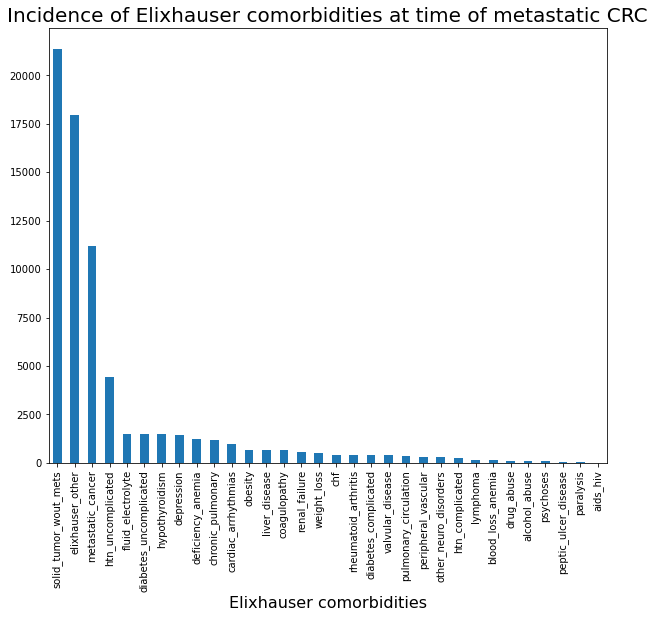

In [594]:
%matplotlib inline
diagnosis_elixhauser.iloc[:, 1:33].sum(axis = 0).sort_values(ascending = False).plot(kind = 'bar', figsize = (10,8))
plt.xlabel('Elixhauser comorbidities', fontsize = 16)
plt.title('Incidence of Elixhauser comorbidities at time of metastatic CRC', fontsize = 20)

Text(0.5, 1.0, 'Incidence of Elixhauser comorbidities at time of metastatic CRC')

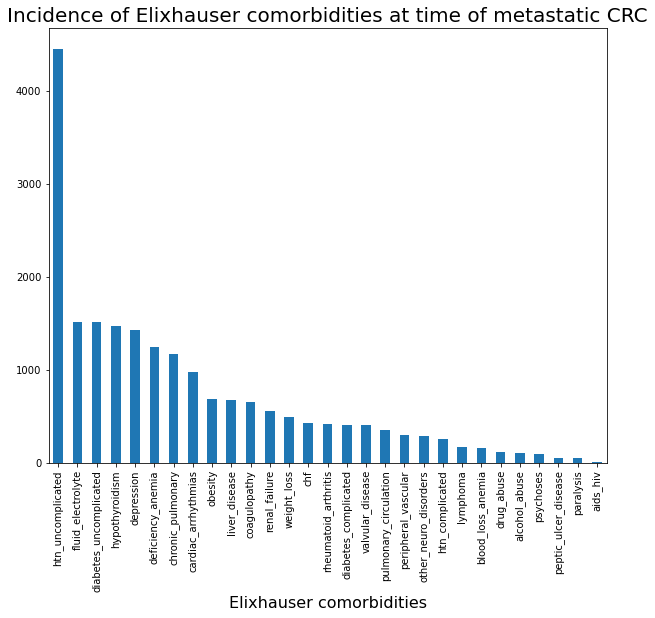

In [595]:
# Same plot as above but excluding tumor and mets.
%matplotlib inline
diagnosis_elixhauser.iloc[:, 1:33].sum(axis = 0).sort_values(ascending = False).tail(29).plot(kind = 'bar', figsize = (10,8))
plt.xlabel('Elixhauser comorbidities', fontsize = 16)
plt.title('Incidence of Elixhauser comorbidities at time of metastatic CRC', fontsize = 20)

In [596]:
# Append missing training IDs.
diagnosis_elixhauser = (
    diagnosis_elixhauser
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(diagnosis_elixhauser['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False)
    .fillna(0)
)

In [597]:
row_ID(diagnosis_elixhauser)

(25341, 25341)

In [598]:
diagnosis_elixhauser.sample(5)

,PatientID,chf,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,htn_uncomplicated,htn_complicated,paralysis,other_neuro_disorders,...,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemia,alcohol_abuse,drug_abuse,psychoses,depression,elixhauser_other,icd_count
5428,F3E886FE76880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14023,FA30F3FEFADF8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0
20430,F06B83CC7814F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2513,F1D0991198428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20.0
4432,F338016304D78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Other cancer 

##### ICD-9 Cancer codes 

In [599]:
# Select all ICD-9 cancer codes between 140-209.
# Exclude benign neoplasms: 210-229, carcinoma in site: 230-234, and neoplasms of uncertain behavior or nature: 235-239.
cancer_9 = (
    diagnosis_elix_9[diagnosis_elix_9['DiagnosisCode'].str.startswith(
        ('14','15', '16', '17', '18', '19', '20'))]
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [600]:
row_ID(cancer_9)

(20626, 12529)

**Remove the following ICD-9 codes representing colorectal cancer, metastasis, ill-defined neoplasms, and benign neoplasms of skin (BCC and SCC):**
* **174 - Malignant neoplasm of female breast**
* **175 - Malignant neoplasm of male breast**
* **173 - Other and unspecified malignant neoplasm of skin**
* **196 - Secondary and unspecified malignant neoplasm of lymph nodes**
* **197 - Secondary malignant neoplasm of respiratory and digestive systems**
* **198 - Secondary malignant neoplasm of other specified sites** 
* **199 - Malignant neoplasm without specification of site**

In [601]:
# Count ICD-9 neoplasm codes that represent breast cancer or its associated metastases.
(
    cancer_9[cancer_9['diagnosis_code'].str.match('17([345])|'
                                                  '19([6789])')]
    .DiagnosisCode
    .value_counts(normalize = True)
    .head(10)
)

174.9    0.284485
174.4    0.163807
198.5    0.122613
174.8    0.091298
174.1    0.046438
174.2    0.040328
196.3    0.036713
174.5    0.035440
197.0    0.024849
174.3    0.024085
Name: DiagnosisCode, dtype: float64

In [602]:
# Dataframe of ICD-9 neoplasm codes that exclude colorectal cancer, metastasis, or benign neoplasms.
other_cancer_9 = (
    cancer_9[~cancer_9['diagnosis_code'].str.match('17([345])|'
                                                   '19([6789])')]
)

In [603]:
other_cancer_9.DiagnosisCode.value_counts(normalize = True).head(10)

162.9     0.057751
193       0.050659
183.0     0.044580
182.0     0.041540
153.9     0.038501
162.3     0.032421
204.10    0.032421
202.80    0.026342
172.9     0.024316
189.0     0.023303
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-9 codes at time of diagnosis that aren't breast cancer, metastasis, or benign neoplasm:**
* **162.9 - Malignant neoplasm of bronchus and lung, unspecified**
* **193 - Malignant neoplasm of thyroid gland**
* **183.0 - Malignant neoplasm of ovary**
* **182.0 - Malignant neoplasm of corpus uteri, except isthmus**
* **153.9 - Malignant neoplasm of colon, unspecified site**
* **162.3 - Malignant neoplasm of upper lobe, bronchus or lung**
* **204.10 - Chronic lymphoid leukemia, without mention of having achieved remission**
* **202.80 - Other malignant lymphomas**
* **172.9 - Melanoma of skin, site unspecified**
* **189.0 - Malignant neoplasm of kidney and other and unspecified urinary organs**

In [604]:
other_cancer_9.DiagnosisCode.str[0:3].value_counts(normalize = True).head(10)

162    0.124620
153    0.104357
172    0.075988
202    0.064843
193    0.050659
182    0.047619
183    0.046606
204    0.042553
195    0.040527
189    0.030395
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-9 family codes at time of diagnosis that aren't breast cancer, metastasis, or benign neoplasm:**
* **162 - Malignant neoplasm of trachea bronchus and lung**
* **153 - Malignant neoplasm of colon**
* **172 - Malignant melanoma of skin**
* **202 - Other malignant neoplasms of lymphoid and histiocytic tissue**
* **193 - Malignant neoplasm of thyroid gland**
* **182 - Malignant neoplasm of body of uterus**
* **183 - Malignant neoplasm of ovary and other uterine adnexa**
* **204 - Lymphoid leukemia**
* **195 - Malignant neoplasm of other and ill-defined sites**
* **189 - Malignant neoplasm of kidney and other and unspecified urinary organs**

In [605]:
other_cancer_9.loc[:,'other_cancer_9'] = 1

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [606]:
other_cancer_9 = (
    other_cancer_9
    .drop_duplicates(subset = 'PatientID', keep = 'first')
    .filter(items = ['PatientID', 'other_cancer_9'])
)

In [607]:
row_ID(other_cancer_9)

(793, 793)

In [608]:
other_cancer_9 = (
    other_cancer_9
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(other_cancer_9['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False)
    .fillna(0)
)

In [609]:
row_ID(other_cancer_9)

(25341, 25341)

##### ICD-10 Cancer codes

In [610]:
# Select all ICD-10 codes between C00-D49 
# Exclude in situ neoplasms: D00-D09, benign neoplasms: D10-D36, benign neuroendocrine tumor: D3A, and neoplasms of unspecified behavior: D37 and D49
cancer_10 = (
    diagnosis_elix_10[diagnosis_elix_10['DiagnosisCode'].str.startswith(
        ('C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'D38', 'D39', 'D4'))]
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [611]:
row_ID(cancer_10)

(28066, 12833)

**Remove the following ICD-10 codes which capture breast cancer, metastasis, and benign skin neoplasms(eg., BCC and SCC).**
* **C50 - Malignant neoplasm of breast** 
* **C44 - Other and unspecified malignant neoplasm of skin**
* **C77 - Secondary and unspecified malignant neoplasm of lymph nodes**
* **C78 - Secondary malignant neoplasm of respiratory and digestive organs**
* **C79 - Secondary malignant neoplasm of other and unspecified sites**
* **C80 - Malignant neoplasm without specification of site**
* **D47.2 - Monoclonal gammopathy**
* **D48 - Neoplasm of uncertain behavior of other and unspecified sites**
* **D49 - Neoplasms of unspecified behavior** 

In [612]:
# Count of top 10 ICD-10 codes that represent lung cancer or metastasis. 
(
    cancer_10[cancer_10['diagnosis_code'].str.match('C50|'
                                                    'C44|'
                                                    'C7[789]|'
                                                    'C80|'
                                                    'D4(72|[89])')]
    .DiagnosisCode
    .value_counts(normalize = True)
    .head(10)
)

C79.51     0.182901
C50.919    0.079649
C50.412    0.059635
C50.912    0.059413
C50.411    0.055862
C50.911    0.055085
C78.7      0.044689
C77.3      0.041878
C50.812    0.033443
C50.811    0.030816
Name: DiagnosisCode, dtype: float64

In [613]:
# Dataframe of ICD-10 neoplasm codes that exclude lung cancer, metastasis, or benign neoplasms.
other_cancer_10 = (
    cancer_10[~cancer_10['diagnosis_code'].str.match('C50|'
                                                    'C44|'
                                                    'C7[789]|'
                                                    'C80|'
                                                    'D4(72|[89])')]
)

In [614]:
other_cancer_10.DiagnosisCode.value_counts(normalize = True).head(10)

C34.90    0.044444
C73       0.039614
D47.3     0.029952
C54.1     0.028986
C34.31    0.025121
C41.9     0.023188
C91.10    0.021256
C90.00    0.020290
C76.1     0.020290
D38.1     0.017391
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-10 codes at time of diagnosis that aren't breast cancer, metastasis, or benign neoplasm:**
* **C34.9 - Malignant neoplasm of unspecified part of bronchus or lung**
* **C73 - Malignant neoplasm of thyroid gland**
* **C47.3 - Malignant neoplasm of peripheral nerves of thorax**
* **C54.1 - Malignant neoplasm of endometrium**
* **C34.31 - Malignant neoplasm of lower lobe, right bronchus or lung**
* **C41.9 - Malignant neoplasm of bone and articular cartilage, unspecified**
* **C91.10 - Chronic lymphocytic leukemia of B-cell type not having achieved remission**
* **C90.00 - Multiple myeloma not having achieved remission**
* **C76.1 - Malignant neoplasm of thorax**
* **C38.1 - Malignant neoplasm of anterior mediastinum**

In [615]:
other_cancer_10.DiagnosisCode.str[0:3].value_counts(normalize = True).head(10)

C34    0.165217
C41    0.043478
C18    0.041546
C73    0.039614
D47    0.037681
C54    0.036715
C91    0.033816
C76    0.030918
C83    0.029952
C56    0.029952
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-10 family codes at time of diagnosis that aren't colorectal cancer, metastasis, or benign neoplasm:**
* **C34 - Malignant neoplasm of bronchus and lung**
* **C41 - Malignant neoplasm of bone and articular cartilage of other and unspecified sites**
* **C18 - Malignant neoplasm of colon**
* **C73 - Malignant neoplasm of thyroid gland**
* **C47 - Malignant neoplasm of peripheral nerves and autonomic nervous system**
* **C54 - Malignant neoplasm of corpus uteri**
* **C91 - Lymphoid leukemia**
* **C76 - Malignant neoplasm of other and ill-defined sites**
* **C83 - Non-follicular lymphoma**
* **C56 - Malignant neoplasm of ovary**

In [616]:
other_cancer_10.loc[:,'other_cancer_10'] = 1

In [617]:
# Drop duplicates.
other_cancer_10 = (
    other_cancer_10
    .drop_duplicates(subset = 'PatientID', keep = 'first')
    .filter(items = ['PatientID', 'other_cancer_10'])
)

In [618]:
row_ID(other_cancer_10)

(782, 782)

In [619]:
# Append missing training IDs.
other_cancer_10 = (
    other_cancer_10
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(other_cancer_10['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False)
    .fillna(0)
)

In [620]:
row_ID(other_cancer_10)

(25341, 25341)

In [621]:
other_cancer = pd.merge(other_cancer_9, other_cancer_10, on = 'PatientID')

In [622]:
# Combine other_cancer_9 and other_cancer_19; replace values equal to 2 with 1. 
other_cancer = (
    other_cancer
    .assign(other_cancer = other_cancer['other_cancer_9'] + other_cancer['other_cancer_10'])
    .filter(items = ['PatientID', 'other_cancer'])
    .replace(2, 1)
)

In [623]:
row_ID(other_cancer)

(25341, 25341)

In [624]:
# Percentage of patients with a cancer other than breast or mets. 
len(other_cancer[other_cancer['other_cancer'] == 1])/len(other_cancer)

0.058561224892466755

#### Sites of metastases

In [625]:
mets = pd.read_csv('Enhanced_MetBreastSitesOfMet.csv')

In [626]:
mets = mets[mets['PatientID'].isin(train_IDs)]

In [627]:
row_ID(mets)

(62969, 25234)

In [628]:
mets.sample(5)

,PatientID,DateOfMetastasis,SiteOfMetastasis
9299,F66EDAA8C2472,2015-04,Liver
49053,FEDC1148E0AB8,2016-12,Bone
62210,F0DE7E9BC8BB6,2019-08,Bone
40810,F9495D6EE6957,2015-06,Liver
39487,F6AF9A4F2AE1C,2019-12,Adrenal


In [629]:
mets = pd.merge(mets, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [630]:
mets.loc[:, 'DateOfMetastasis'] = pd.to_datetime(mets['DateOfMetastasis'])

In [631]:
mets.sample(5)

,PatientID,DateOfMetastasis,SiteOfMetastasis,met_date
51620,FB8F99B8BFF4A,2015-07-01,Lung,2015-07-22
61556,F344D2619705E,2014-12-01,Liver,2014-12-02
59359,F4E2EC143BC3D,2019-06-01,Bone,2019-06-06
50488,F18BBA99C0AD9,2019-02-01,Pleura,2019-02-18
13245,F929BF100A6D8,2019-07-01,Bone,2019-07-09


In [632]:
mets.loc[:, 'diagnosis_met_diff'] = (mets['DateOfMetastasis'] - mets['met_date']).dt.days

In [633]:
mets = mets.query('diagnosis_met_diff <= 30')

In [634]:
mets.SiteOfMetastasis.value_counts(normalize = True)

Bone                  0.356779
Lung                  0.161228
Distant lymph node    0.151943
Liver                 0.124087
Pleura                0.052285
Brain                 0.037276
Other                 0.024497
Skin                  0.019246
Soft tissue           0.018300
Peritoneum            0.013973
Bone marrow           0.012373
Adrenal               0.010637
CNS site              0.008992
Ovary                 0.003854
Spleen                0.001893
Pancreas              0.001240
Kidney                0.000969
Thyroid               0.000428
Name: SiteOfMetastasis, dtype: float64

In [635]:
(
    mets
    .groupby('PatientID').count()
    .describe()
)

,DateOfMetastasis,SiteOfMetastasis,met_date,diagnosis_met_diff
count,25105.000000,25105.000000,25105.000000,25105.000000
mean,1.767457,1.767457,1.767457,1.767457
std,1.068153,1.068153,1.068153,1.068153
min,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000,2.000000
max,12.000000,12.000000,12.000000,12.000000


In [636]:
mets['PatientID'].nunique()

25105

**The median number of mets at time of metastatic diagnosis is 1. The most common site is bone followed by lung, distant lymph node, and liver. Sites of metastasis will be simplified into the following groups:**

* **1. Bone or bone marrow**
* **2. Lung or pleura**
* **3. Distant lymph node**
* **4. Liver**
* **5. Brain or CNS site**
* **6. Skin or soft tissue**
* **7. Peritoneum**
* **8. Other: other, adrenal, ovary, spleen, pancreas, kidney, or thyroid**

In [637]:
# Recode mets
conditions = [
    (mets['SiteOfMetastasis'] == 'Bone') | 
    (mets['SiteOfMetastasis'] == 'Bone marrow'),
    (mets['SiteOfMetastasis'] == 'Lung') | 
    (mets['SiteOfMetastasis'] == 'Pleura'),
    (mets['SiteOfMetastasis'] == 'Distant lymph node'),
    (mets['SiteOfMetastasis'] == 'Liver'),
    (mets['SiteOfMetastasis'] == 'Brain') | 
    (mets['SiteOfMetastasis'] == 'CNS site'),
    (mets['SiteOfMetastasis'] == 'Skin') | 
    (mets['SiteOfMetastasis'] == 'Soft tissue'),
    (mets['SiteOfMetastasis'] == 'Peritoneum'),
    (mets['SiteOfMetastasis'] == 'Other') | 
    (mets['SiteOfMetastasis'] == 'Adrenal') |
    (mets['SiteOfMetastasis'] == 'Ovary') |
    (mets['SiteOfMetastasis'] == 'Spleen') |
    (mets['SiteOfMetastasis'] == 'Pancreas') |
    (mets['SiteOfMetastasis'] == 'Kidney') |
    (mets['SiteOfMetastasis'] == 'Thyroid')]

choices = ['bone_met', 'thorax_met', 'lymph_met', 'liver_met', 'cns_met', 'skin_met', 'peritoneum_met', 'other_met']

mets.loc[:, 'met_loc'] = np.select(conditions, choices)

In [638]:
mets['bone_met'] = np.where(mets['met_loc'] == 'bone_met', 1, 0)

In [639]:
mets['thorax_met'] = np.where(mets['met_loc'] == 'thorax_met', 1, 0)

In [640]:
mets['lymph_met'] = np.where(mets['met_loc'] == 'lymph_met', 1, 0)

In [641]:
mets['liver_met'] = np.where(mets['met_loc'] == 'liver_met', 1, 0)

In [642]:
mets['cns_met'] = np.where(mets['met_loc'] == 'cns_met', 1, 0)

In [643]:
mets['skin_met'] = np.where(mets['met_loc'] == 'skin_met', 1, 0)

In [644]:
mets['peritoneum_met'] = np.where(mets['met_loc'] == 'peritoneum_met', 1, 0)

In [645]:
mets['other_met'] = np.where(mets['met_loc'] == 'other_met', 1, 0)

In [646]:
# Drop unnecessary columns and condense. 
mets_wide = (
    mets
    .drop(columns = ['DateOfMetastasis', 'SiteOfMetastasis', 'met_date', 'diagnosis_met_diff', 'met_loc'])
    .groupby('PatientID').sum()
)

In [647]:
# Set any value greater than 1 to 1; leave 0 unchanged. 
mets_wide = (
    mets_wide
    .mask(mets_wide > 1, 1)
    .reset_index()
)

In [648]:
row_ID(mets_wide)

(25105, 25105)

In [649]:
# Append missing training IDs.
mets_wide = (
    mets_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(mets_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [650]:
row_ID(mets_wide)

(25341, 25341)

In [651]:
mets_wide = mets_wide.fillna(0)

In [652]:
mets_wide.sample(5)

,PatientID,bone_met,thorax_met,lymph_met,liver_met,cns_met,skin_met,peritoneum_met,other_met
18601,FBD9A4405452A,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4747,F30A7161105C4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21571,FDC918B478F27,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9525,F617CCB9671A5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23535,FEFD8C2043387,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [653]:
# Percentage breakdown of insurance by type at time of advanced diagnosis.
(mets_wide.iloc[:, 1:9].sum()/mets_wide.shape[0]).sort_values(ascending = False)

bone_met          0.627481
thorax_met        0.330492
lymph_met         0.266051
liver_met         0.217276
cns_met           0.074859
other_met         0.070992
skin_met          0.063020
peritoneum_met    0.024466
dtype: float64

#### Merge

In [654]:
diagnosis_wide = pd.merge(diagnosis_elixhauser, other_cancer, on = 'PatientID')

In [655]:
diagnosis_wide = pd.merge(diagnosis_wide, mets_wide, on = 'PatientID')

In [656]:
row_ID(diagnosis_wide)

(25341, 25341)

In [657]:
list(diagnosis_wide.columns)

['PatientID',
 'chf',
 'cardiac_arrhythmias',
 'valvular_disease',
 'pulmonary_circulation',
 'peripheral_vascular',
 'htn_uncomplicated',
 'htn_complicated',
 'paralysis',
 'other_neuro_disorders',
 'chronic_pulmonary',
 'diabetes_uncomplicated',
 'diabetes_complicated',
 'hypothyroidism',
 'renal_failure',
 'liver_disease',
 'peptic_ulcer_disease',
 'aids_hiv',
 'lymphoma',
 'metastatic_cancer',
 'solid_tumor_wout_mets',
 'rheumatoid_arthritis',
 'coagulopathy',
 'obesity',
 'weight_loss',
 'fluid_electrolyte',
 'blood_loss_anemia',
 'deficiency_anemia',
 'alcohol_abuse',
 'drug_abuse',
 'psychoses',
 'depression',
 'elixhauser_other',
 'icd_count',
 'other_cancer',
 'bone_met',
 'thorax_met',
 'lymph_met',
 'liver_met',
 'cns_met',
 'skin_met',
 'peritoneum_met',
 'other_met']

In [658]:
%whos DataFrame

Variable                 Type         Data/Info
-----------------------------------------------
biomarker_wide           DataFrame               PatientID     <...>n[25341 rows x 7 columns]
cancer_10                DataFrame                 PatientID Di<...>n[28066 rows x 3 columns]
cancer_9                 DataFrame                 PatientID Di<...>n[20626 rows x 3 columns]
demographics             DataFrame               PatientID gend<...>n[25341 rows x 7 columns]
diagnosis                DataFrame                 PatientID   <...>1252825 rows x 9 columns]
diagnosis_elix_10        DataFrame                 PatientID Di<...>134520 rows x 35 columns]
diagnosis_elix_10_wide   DataFrame               PatientID  chf<...>[14181 rows x 33 columns]
diagnosis_elix_9         DataFrame                 PatientID Di<...>[90009 rows x 35 columns]
diagnosis_elix_9_wide    DataFrame               PatientID  chf<...>[13746 rows x 33 columns]
diagnosis_elixhauser     DataFrame               PatientID

In [659]:
# Keep biomarker_wide, demographics, diagnosis_wide, ecog_diagnosis_wide, enhanced_met, insurance_wide, 
# lab_wide, med_admin_wide, mortality, and weight_wide
del cancer_10
del cancer_9
del diagnosis
del diagnosis_elix_10
del diagnosis_elix_10_wide
del diagnosis_elix_9
del diagnosis_elix_9_wide
del diagnosis_elixhauser
del mets
del mets_wide
del other_cancer
del other_cancer_10
del other_cancer_9

### 11. SocialDeterminantsOfHealth

In [660]:
sdoh = pd.read_csv('SocialDeterminantsOfHealth.csv')

In [661]:
sdoh = sdoh[sdoh['PatientID'].isin(train_IDs)]

In [662]:
row_ID(sdoh)

(21113, 21113)

In [663]:
sdoh.sample(5)

,PatientID,PracticeID,SESIndex2015_2019
18925,F48586A6ECEC9,S260DA7B3CE37,4
11285,F0DE3D421A5A3,SBB648C22FEF1,3
10981,F69CB7401CC0D,S57BBE18F8EB0,1 - Lowest SES
18153,FEFFCAE58BE59,SD2555DC0ACD7,2
2531,F4B808A482A38,S43F1EC350316,2


**Measures the area-level socioeconomic status (SES) of a patient between 2015 and 2019 based on their most recent address.**

In [664]:
conditions = [
    (sdoh['SESIndex2015_2019'] == '5 - Highest SES'),
    (sdoh['SESIndex2015_2019'] == '1 - Lowest SES')]    

choices = ['5', '1']
    
sdoh.loc[:, 'ses'] = np.select(conditions, choices, default = sdoh['SESIndex2015_2019'])

In [665]:
sdoh = sdoh.drop(columns = ['PracticeID', 'SESIndex2015_2019'])

In [666]:
sdoh_wide = (
    sdoh
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(sdoh['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [667]:
row_ID(sdoh_wide)

(25341, 25341)

In [668]:
sdoh_wide.ses.value_counts(dropna = False, normalize = True)

NaN    0.266446
4      0.160175
3      0.156426
2      0.142970
5      0.139931
1      0.134052
Name: ses, dtype: float64

In [669]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
biomarker_wide        DataFrame               PatientID     <...>n[25341 rows x 7 columns]
demographics          DataFrame               PatientID gend<...>n[25341 rows x 7 columns]
diagnosis_wide        DataFrame               PatientID  chf<...>[25341 rows x 43 columns]
ecog_diagnosis_wide   DataFrame                PatientID eco<...>n[25341 rows x 2 columns]
enhanced_met          DataFrame               PatientID diag<...>n[25341 rows x 7 columns]
insurance_wide        DataFrame               PatientID  med<...>n[25341 rows x 9 columns]
lab_wide              DataFrame               PatientID  alb<...>25341 rows x 129 columns]
med_admin_wide        DataFrame               PatientID  ste<...>[25341 rows x 14 columns]
mortality             DataFrame               PatientID  dea<...>n[25341 rows x 3 columns]
sdoh                  DataFrame               PatientID  ses<...>n[21113 rows x 2 columns]


In [670]:
# Keep biomarker_wide, demographics, ecog_diagnosis_wide, enhanced_met, mortality, 
# lab_wide, sdoh_wide, and weight wide
del sdoh

## Part 3: File merge

In [671]:
enhanced_met = enhanced_met.drop(columns = ['diagnosis_date', 'met_date', 'met_year_cat'])

In [672]:
train_full = pd.merge(demographics, enhanced_met, on = 'PatientID')

In [673]:
train_full = pd.merge(train_full, mortality, on = 'PatientID')

In [674]:
train_full = pd.merge(train_full, med_admin_wide, on = 'PatientID')

In [675]:
train_full = pd.merge(train_full, biomarker_wide, on = 'PatientID')

In [676]:
train_full = pd.merge(train_full, insurance_wide, on = 'PatientID')

In [677]:
train_full = pd.merge(train_full, ecog_diagnosis_wide, on = 'PatientID')

In [678]:
train_full = pd.merge(train_full, weight_wide, on = 'PatientID')

In [679]:
train_full = pd.merge(train_full, lab_wide, on = 'PatientID')

In [680]:
train_full = pd.merge(train_full, diagnosis_wide, on = 'PatientID')

In [681]:
train_full = pd.merge(train_full, sdoh_wide, on = 'PatientID')

In [682]:
row_ID(train_full)

(25341, 25341)

In [683]:
len(train_full.columns)

217

In [684]:
list(train_full.columns)

['PatientID',
 'gender',
 'race',
 'ethnicity',
 'age',
 'p_type',
 'region',
 'stage',
 'met_year',
 'delta_met_diagnosis',
 'death_status',
 'timerisk_activity',
 'steroid_diag',
 'opioid_PO_diag',
 'nonopioid_PO_diag',
 'pain_IV_diag',
 'ac_diag',
 'antiinfective_IV_diag',
 'antiinfective_diag',
 'antihyperglycemic_diag',
 'ppi_diag',
 'antidepressant_diag',
 'bta_diag',
 'thyroid_diag',
 'is_diag',
 'ER',
 'HER2',
 'PR',
 'BRCA',
 'PIK3CA',
 'pdl1_n',
 'medicare',
 'medicaid',
 'medicare_medicaid',
 'commercial',
 'patient_assistance',
 'other_govt',
 'self_pay',
 'other',
 'ecog_diagnosis',
 'weight_diag',
 'bmi_diag',
 'bmi_diag_na',
 'weight_pct_change',
 'weight_pct_na',
 'weight_slope',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'albumin_diag_na'

In [685]:
train_full.to_csv('train_full.csv', index = False, header = True)